## 1. IMPORTY I KONFIGURACJA WSTĘPNA

In [1]:
# Standard library imports
import argparse
import contextlib
import logging
import multiprocessing
import os
import platform
import random
import sys
import time
import warnings
from collections import deque, namedtuple
from functools import partial
from typing import Any, Dict, List, Optional, Tuple, Callable
import traceback
from dataclasses import dataclass, field

# ====== KOMÓRKA 1: Importy i definicje klas ======
import pandas as pd
import numpy as np
import os
import json
from dataclasses import dataclass, field, asdict
from typing import List, Dict, Any

# Third-party imports
import joblib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.dates as mdates

import numpy as np
import optuna
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm

# scikit-learn imports
from sklearn.feature_selection import RFECV
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler

In [2]:
# import torch

# if torch.cuda.is_available():
#     print("✅ Sukces! PyTorch może korzystać z Twojego GPU (ROCm).")
    
#     # ROCm używa API CUDA w PyTorch dla spójności
#     device_count = torch.cuda.device_count()
#     print(f"Znaleziono {device_count} urządzeń GPU.")
    
#     print("\n--- Dostępne urządzenia ---")
#     for i in range(device_count):
#         print(f"Urządzenie {i}: {torch.cuda.get_device_name(i)}")

#     # Domyślnie PyTorch wybierze najmocniejsze GPU jako 'cuda:0'
#     main_gpu = torch.device('cuda:0')
#     print(f"\nUżywam domyślnego GPU: {torch.cuda.get_device_name(0)}")

#     # Prosty test obliczeniowy na GPU
#     try:
#         tensor_a = torch.randn(12000, 12000).to(main_gpu)
#         tensor_b = torch.randn(12000, 12000).to(main_gpu)
#         wynik = tensor_a @ tensor_b # Mnożenie macierzy na GPU
#         print("Wynik testowej operacji na GPU:")
#         print(wynik)
#         print("\nKonfiguracja jest gotowa do pracy! 👍")
#     except Exception as e:
#         print(f"Wystąpił błąd podczas testu na GPU: {e}")

# else:
#     print("❌ Błąd: PyTorch nie wykrywa GPU. Sprawdź instalację ROCm i sterowników.")

# if torch.cuda.is_available():
#     print("✅ Sprawdzanie szczegółowych właściwości dostępnych GPU...\n")
#     device_count = torch.cuda.device_count()
    
#     for i in range(device_count):
#         properties = torch.cuda.get_device_properties(i)
#         print(f"--- Szczegóły dla urządzenia cuda:{i} ---")
#         print(f"  Nazwa (wg PyTorch): {properties.name}")
#         # To jest odpowiednik "Compute Unit" z rocminfo
#         print(f"  Jednostki Obliczeniowe (CU): {properties.multi_processor_count}")
        
#         # Konwersja pamięci z bajtów na GB dla czytelności
#         vram_gb = properties.total_memory / (1024**3)
#         print(f"  Całkowita pamięć VRAM: {vram_gb:.2f} GB")
#         print("-" * 35)

# else:
#     print("❌ Błąd: PyTorch nie wykrywa GPU.")


## 2. ZUNIFIKOWANA KONFIGURACJA PROJEKTU

In [3]:
@dataclass
class Config:
    """
    Główna klasa konfiguracyjna dla całego projektu, zachowująca wszystkie oryginalne parametry.
    """
    # --- Konfiguracja Cech i Danych ---
    COLUMN_CONFIG: Dict[str, Any] = field(default_factory=lambda: {
        'temp_pokoj': (['temp_pokoj'], 'numeric'), 'wilgotnosc': (['wilgotnosc'], 'numeric'),
        'temp_zewnatrz': (['temp_zewnatrz', 'pogoda_temperature'], 'numeric'), 'cisnienie': (['cisnienie'], 'numeric'),
        'iaq': (['iaq'], 'numeric'), 'voc': (['voc'], 'numeric'), 'nox': (['nox'], 'numeric'),
        'swiatlo_pokoj': (['swiatlo_pokoj'], 'numeric'), 'swiatlo_zewnatrz': (['swiatlo_zewnatrz'], 'numeric'),
        'moc': (['moc', 'moc_klima'], 'numeric'), 'klima_temp_ustawiona': (['klima_temp_ustawiona'], 'numeric'),
        'state': (['state', 'klima_stan'], 'categorical'), 'fan_mode_str': (['fan_mode_str', 'klima_wiatrak'], 'categorical'),
        'swing_mode_str': (['swing_mode_str', 'klima_wachlowanie'], 'categorical'), 'last_on_operation_str': (['last_on_operation_str', 'klima_ostatni_tryb'], 'categorical'),
    })
    
    RAW_SENSOR_COVARIATES: List[str] = field(default_factory=lambda: [
        'wilgotnosc', 'temp_zewnatrz', 'cisnienie', 'iaq', 'voc', 'nox',
        'swiatlo_pokoj', 'swiatlo_zewnatrz', 'klima_temp_ustawiona',
        'state_cool', 'state_off', 'fan_mode_str_auto', 'fan_mode_str_high', 
        'fan_mode_str_low', 'fan_mode_str_mid', 'swing_mode_str_any_swing',
    ])
    ENGINEERED_FEATURES: List[str] = field(default_factory=lambda: [
        'godzina_sin', 'godzina_cos', 'dzien_tygodnia_sin', 'dzien_tygodnia_cos',
        'state_changed', 'time_since_state_change', 'temp_diff_pogoda', 'temp_diff_ustawiona',
        'temp_pokoj_deriv_1m', 'temp_pokoj_deriv_2m', 'temp_pokoj_deriv_4m', 'temp_pokoj_deriv_8m',
        'temp_pokoj_deriv_12m', 'temp_pokoj_deriv_18m', 'temp_pokoj_deriv_32m',
        'moc_deriv_1m', 'moc_deriv_2m', 'moc_deriv_4m', 'moc_deriv_8m',
        'moc_deriv_12m', 'moc_deriv_18m', 'moc_deriv_32m',
        'temp_pokoj_mean_rolling_24m', 'temp_pokoj_std_rolling_24m', 'temp_pokoj_mean_rolling_48m',
        'temp_pokoj_std_rolling_48m', 'temp_pokoj_mean_rolling_144m', 'temp_pokoj_std_rolling_144m',
        'temp_pokoj_mean_rolling_288m', 'temp_pokoj_std_rolling_288m',
    ])
    COVARIATE_COLUMNS_TO_USE: List[str] = field(default_factory=list)
    DATA_DIRECTORY: str = 'dane_z_chronograf'
    DEVICE: str = "cpu"
    FREQ: str = 'min'
    DATA_PATH: str = "" # To pole zostanie ustawione z argumentu linii poleceń
    
    # --- Parametry Treningu i Walidacji ---
    OPTUNA_TRIALS: int = 3
    MIN_SAMPLES_FOR_TRAINING: int = 800
    OPTUNA_CV_N_WINDOWS: int = 6
    PREDICTION_HORIZON: int = 240
    SMOOTHING_WINDOW_FRACTION: float = 0.5
    N_SAMPLES_PREDICTION: int = 3 
    CV_FOLDS: int = 6 
    CV_FOLDS_EVAL: int = 3
    N_JOBS: int = 3
    
    # --- Konfiguracja Ścieżek (skonsolidowana) ---
    BASE_MODEL_DIR: str = 'trained_models'
    NBEATS_MODEL_FILE: str = 'nbeats_model.pkl'
    NBEATS_COLUMNS_FILE: str = 'nbeats_columns.pkl'
    NBEATS_SCALERS_FILE: str = "nbeats_scalers.pkl"
    NHITS_SAVE_DIR: str = "nhits_model_artifacts"
    NBEATS_OUTPUT_CHUNK_LENGTH: int = 24
    PROFILING_ENABLED: bool = True 
    USE_CHECKPOINTING: bool = True
    
    AGENT_MODEL_FILENAME: str = "drqn_agent.pth"
    BEST_AGENT_MODEL_FILENAME: str = "best_agent.pt"

    # --- Konfiguracja Przestrzeni Akcji ---
    ACTION_MODES: List[Dict] = field(default_factory=list)
    
    # --- Parametry specyficzne dla NHITS ---
    NHITS_TARGET_COLUMNS: List[str] = field(default_factory=lambda: ['temp_pokoj', 'moc'])
    NHITS_TARGET_PREFIXES: List[str] = field(default_factory=lambda: ['temp', 'moc'])
    NHITS_STUDY_NAME: str = "nhits_multivariate_study_final"
    NHITS_QUANTILES: List[float] = field(default_factory=lambda: [0.05, 0.5, 0.95])
    HPO_SAMPLE_RATIO: float = 0.72
    INITIAL_TRAIN_RATIO: float = 0.45
    TEST_SET_RATIO: float = 0.20
    VALIDATION_SET_RATIO: float = 0.40
    INPUT_SIZE_MULTIPLIER: int = 2 
    NHITS_MAX_STEPS_HPO: int = 650
    NHITS_MAX_STEPS_FINAL: int = 950 
    WINDOWS_BATCH_SIZE: int = 364 # Używana nazwa w skrypcie
    NHITS_BATCH_SIZE: int = 364 # Oryginalna nazwa dla spójności
    NHITS_EARLY_STOP_PATIENCE: int = 5
    NHITS_VAL_CHECK_STEPS: int = 50
    NHITS_HPO_ENABLED: bool = True
    NHITS_MODEL_PATH: str = "artefacts/nhits_model"
    NHITS_COLUMNS_PATH: str = "artefacts/nhits_columns.joblib"
    NHITS_SCALER_PATH: str = "artefacts/nhits_scaler.joblib"

    # --- Parametry Środowiska i Agenta ---
    TARGET_TEMP: float = 23.0; TEMP_TOLERANCE: float = 0.5; MAX_EPISODE_STEPS: int = 1440 
    COMFORT_BONUS: float = 1.0; COMFORT_PENALTY_FACTOR: float = 2.0; ENERGY_COST_PER_WATT: float = 0.0001 
    SWITCH_ACTION_PENALTY: float = 0.1; MIN_TEMP_LIMIT: float = 12.0; MAX_TEMP_LIMIT: float = 35.0
    MAX_POWER_LIMIT: float = 3000.0; TOTAL_FRAMES: int = 200_000; BUFFER_SIZE: int = 50_000
    LEARNING_STARTS: int = 10_000; BATCH_SIZE: int = 128; LR: float = 1e-4; GAMMA: float = 0.99
    TARGET_UPDATE_TAU: float = 0.005; PER_ALPHA: float = 0.6; PER_BETA_START: float = 0.4
    FRAMES_PER_BATCH: int = 256; TIME_WINDOW: int = 64
    UPDATE_TARGET_EVERY_STEPS: int = 10; UPDATE_EPOCHS: int = 1; NUM_WORKERS: int = 1
    GRU_HIDDEN_SIZE: int = 192; MLP_HIDDEN_SIZE: int = 192; DEBUG: bool = True
    
    def __post_init__(self):
        """Logika wykonywana po inicjalizacji obiektu."""
        self.COVARIATE_COLUMNS_TO_USE = self.RAW_SENSOR_COVARIATES
        self.NHITS_MODEL_PATH = os.path.join(self.NHITS_SAVE_DIR, "nhits_model") 
        self.NHITS_COLUMNS_PATH = os.path.join(self.NHITS_SAVE_DIR, "nhits_columns.joblib")
        self.ACTION_MODES = [
            {'state': 'off'}, {'state': 'cool', 'klima_temp_ustawiona': 23, 'fan_mode_str': 'mid'},
            {'state': 'cool', 'klima_temp_ustawiona': 23, 'fan_mode_str': 'low'},
            {'state': 'cool', 'klima_temp_ustawiona': 22, 'fan_mode_str': 'auto'},
            {'state': 'cool', 'klima_temp_ustawiona': 22, 'fan_mode_str': 'mid'},
            {'state': 'cool', 'klima_temp_ustawiona': 22, 'fan_mode_str': 'high'},
            {'state': 'cool', 'klima_temp_ustawiona': 20, 'fan_mode_str': 'high'},
            {'state': 'cool', 'klima_temp_ustawiona': 20, 'fan_mode_str': 'low'},
            {'state': 'cool', 'klima_temp_ustawiona': 20, 'fan_mode_str': 'mid'},
            {'state': 'cool', 'klima_temp_ustawiona': 19, 'fan_mode_str': 'high'},
            {'state': 'cool', 'klima_temp_ustawiona': 19, 'fan_mode_str': 'low'},
            {'state': 'cool', 'klima_temp_ustawiona': 19, 'fan_mode_str': 'mid'},
            {'state': 'cool', 'klima_temp_ustawiona': 18, 'fan_mode_str': 'high'},
            {'state': 'cool', 'klima_temp_ustawiona': 18, 'fan_mode_str': 'low'},
            {'state': 'cool', 'klima_temp_ustawiona': 18, 'fan_mode_str': 'mid'},
        ]
        for action in self.ACTION_MODES:
            if action['state'] == 'cool':
                action['swing_mode_str'] = 'any_swing'

## 3. PREPROCESSOR

In [4]:
class Preprocessor:
    """
    Kompletna i uodporniona klasa Preprocessora.
    """
    def __init__(self, cfg: 'Config', verbose: bool = True):
        self.config = cfg
        self.verbose = verbose

    def _vprint(self, message: str):
        if self.verbose:
            print(message)

    def _load_and_prepare_data(self) -> pd.DataFrame:
        self._vprint("--- PREPROCESSOR [Etap 1/3]: Wczytywanie i przygotowanie danych ---")
        data_dir = self.config.DATA_DIRECTORY
              
        all_csv_files = [f for f in os.listdir(data_dir) if f.lower().endswith('.csv')]
        if not all_csv_files:
            raise FileNotFoundError(f"Błąd krytyczny: Brak plików .csv w katalogu '{data_dir}'.")

        try:
            df_list = [pd.read_csv(os.path.join(data_dir, f), comment='#', low_memory=False) for f in sorted(all_csv_files)]
            df = pd.concat(df_list, ignore_index=True)
        except Exception as e:
            raise IOError(f"Błąd podczas wczytywania lub łączenia plików CSV: {e}")

        self._vprint(f"  -> Wczytano i połączono dane. Początkowy rozmiar: {df.shape}")

        rename_map = {raw_name: internal_name 
                      for internal_name, (raw_names, _) in self.config.COLUMN_CONFIG.items() 
                      for raw_name in raw_names if raw_name in df.columns}
        df.rename(columns=rename_map, inplace=True)
        
        time_col = '_time' if '_time' in df.columns else 'timestamp'
        
        cols_to_drop = [col for col in df.columns if 'Unnamed' in col or col in ['result', 'table', '_start', '_stop']]
        df.drop(columns=cols_to_drop, errors='ignore', inplace=True)

        df[time_col] = pd.to_datetime(df[time_col])
        df.sort_values(by=time_col, inplace=True)
        df.set_index(time_col, inplace=True)
        
        if df.index.tz is None: df = df.tz_localize('UTC')
        df = df.tz_convert('Europe/Warsaw')

        if 'swing_mode_str' in df.columns:
            self._vprint("  -> Ujednolicanie trybów wachlowania ('swing_mode_str') do jednej kategorii 'any_swing'...")
            df.loc[df['swing_mode_str'].notna(), 'swing_mode_str'] = 'any_swing'
        
        for col, (_, col_type) in self.config.COLUMN_CONFIG.items():
            if col_type == 'numeric' and col in df.columns:
                df[col] = pd.to_numeric(df[col], errors='coerce')
        
        self._vprint(f"  -> Rozmiar danych przed resamplingiem: {df.shape}")
        
        numeric_cols = [c for c, t in self.config.COLUMN_CONFIG.items() if t[1] == 'numeric' and c in df.columns]
        categorical_cols = [c for c, t in self.config.COLUMN_CONFIG.items() if t[1] == 'categorical' and c in df.columns]
        agg_dict = {**{col: 'mean' for col in numeric_cols}, 
                    **{col: 'last' for col in categorical_cols}}

        df_resampled = df.resample(self.config.FREQ).agg(agg_dict)
        self._vprint(f"  -> Rozmiar danych po resamplingu: {df_resampled.shape}")
        self._vprint(f"  -> Liczba komórek NaN po resamplingu (przed ffill): {df_resampled.isna().sum().sum()}")

        df_resampled.ffill(inplace=True)
        df_resampled.bfill(inplace=True)
        self._vprint(f"  -> Liczba komórek NaN po wypełnieniu (ffill/bfill): {df_resampled.isna().sum().sum()}")

        if df_resampled.isnull().values.any():
            raise ValueError("BŁĄD KRYTYCZNY: Po wypełnieniu w danych wciąż są luki (NaN).")
        if df_resampled.empty:
            raise ValueError("BŁĄD KRYTYCZNY: Dane po wczytaniu i resamplingu są puste.")

        return df_resampled

    def _create_features(self, df: pd.DataFrame) -> pd.DataFrame:
        self._vprint("\n--- PREPROCESSOR [Etap 2/3]: Tworzenie cech inżynieryjnych ---")
        df_copy = df.copy()

        self._vprint("  -> Tworzenie cech czasowych...")
        df_copy['godzina_sin'] = np.sin(2 * np.pi * df_copy.index.hour / 24)
        df_copy['godzina_cos'] = np.cos(2 * np.pi * df_copy.index.hour / 24)
        df_copy['dzien_tygodnia_sin'] = np.sin(2 * np.pi * df_copy.index.dayofweek / 7)
        df_copy['dzien_tygodnia_cos'] = np.cos(2 * np.pi * df_copy.index.dayofweek / 7)

        self._vprint("  -> Tworzenie cech opartych na stanie...")
        if 'state' in df_copy.columns:
            df_copy['state_changed'] = (df_copy['state'] != df_copy['state'].shift()).astype(int)
            state_blocks = df_copy['state_changed'].cumsum()
            df_copy['time_since_state_change'] = df_copy.groupby(state_blocks).cumcount() + 1
        
        if 'temp_pokoj' in df_copy.columns and 'temp_zewnatrz' in df_copy.columns:
            df_copy['temp_diff_pogoda'] = df_copy['temp_pokoj'] - df_copy['temp_zewnatrz']
        if 'temp_pokoj' in df_copy.columns and 'klima_temp_ustawiona' in df_copy.columns:
            df_copy['temp_diff_ustawiona'] = df_copy['temp_pokoj'] - df_copy['klima_temp_ustawiona']

        self._vprint("  -> Tworzenie cech dynamiki (pochodne i trendy)...")
        # WAŻNE: Użycie .shift(1) zapobiega przeciekowi informacji z teraźniejszości do cech.
        # Wartość cechy w czasie 't' bazuje na danych do 't-1'.
        short_term_windows = [1, 2, 4, 8, 12, 18, 32]
        for window in short_term_windows:
            if 'temp_pokoj' in df_copy.columns:
                df_copy[f'temp_pokoj_deriv_{window}m'] = df_copy['temp_pokoj'].diff(periods=window).shift(1)
            if 'moc' in df_copy.columns:
                df_copy[f'moc_deriv_{window}m'] = df_copy['moc'].diff(periods=window).shift(1)

        long_term_windows = [24, 48, 144, 288]
        for window in long_term_windows:
            if 'temp_pokoj' in df_copy.columns:
                rolling_temp = df_copy['temp_pokoj'].rolling(window=window, min_periods=1)
                df_copy[f'temp_pokoj_mean_rolling_{window}m'] = rolling_temp.mean().shift(1)
                df_copy[f'temp_pokoj_std_rolling_{window}m'] = rolling_temp.std().shift(1).fillna(0)

        self._vprint("  -> Kodowanie zmiennych kategorycznych...")
        categorical_cols_to_encode = [k for k, v in self.config.COLUMN_CONFIG.items() if v[1] == 'categorical' and k in df_copy.columns]
        df_copy = pd.get_dummies(df_copy, columns=categorical_cols_to_encode, dtype=float)

        self._vprint(f"  -> Rozmiar przed usunięciem wierszy z NaN (po inżynierii cech): {df_copy.shape}")
        df_copy.dropna(inplace=True)
        self._vprint(f"  -> Finalny rozmiar danych po wszystkich operacjach: {df_copy.shape}")
        
        if df_copy.empty:
            raise ValueError("BŁĄD KRYTYCZNY: Dane po usunięciu NaN są puste.")
            
        return df_copy

    def run(self) -> pd.DataFrame:
        self._vprint("\n--- PREPROCESSOR: Rozpoczynam pełen potok przetwarzania danych ---")
        df_prepared = self._load_and_prepare_data()
        
        if df_prepared.empty:
            raise ValueError("BŁĄD KRYTYCZNY w Preprocessor: Dane po wczytaniu i przygotowaniu są puste.")
            
        df_features = self._create_features(df_prepared)
        
        if df_features.empty:
            raise ValueError("BŁĄD KRYTYCZNY w Preprocessor: Dane po stworzeniu cech i usunięciu NaN są puste.")
            
        self._vprint("\n--- PREPROCESSOR: Przetwarzanie zakończone sukcesem. ---\n")
        return df_features

In [ ]:
df = Preprocessor(Config()).run()
df.describe()

## 3.5 EDA

In [7]:
class DataAnalyzer:
    """
    Finalna, zaawansowana klasa do Eksploracyjnej Analizy Danych (EDA),
    rozszerzona o analizę efektywności akcji na potrzeby RL.
    """
    def __init__(self, cfg: 'Config' = None): # Domyślny config dla testów
        self.config = cfg
        self.preprocessor = Preprocessor(cfg)
        self._setup_plot_styles()

    def _setup_plot_styles(self):
        sns.set_style("whitegrid", {'axes.edgecolor': '.8'})
        plt.rcParams['figure.facecolor'] = '#f2f2f2'
        plt.rcParams['figure.dpi'] = 110
        plt.rcParams['axes.titlesize'] = 16
        plt.rcParams['axes.labelsize'] = 12
        self.STYLE = {
            'colors': { 'temp_pokoj': '#005f73', 'temp_zewnatrz': '#0a9396', 'moc': '#ee9b00', 'zmiennosc': '#94d2bd',
                        'korelacja_pozytywna': 'viridis', 'korelacja_negatywna': 'coolwarm', 'feature_importance': 'plasma',
                        'primary_dist': '#0077b6', 'secondary_dist': '#fb8500', 'deriv_neg': '#d00000', 'deriv_pos': '#2b9348' },
            'fonts': { 'title': {'size': 18, 'weight': 'bold'}, 'subtitle': {'size': 14} }
        }

    def _setup_plot(self, fig, axes, title, subtitle=''):
        fig.suptitle(title, **self.STYLE['fonts']['title'], y=1.02)
        if subtitle:
            plt.figtext(0.5, 0.96, subtitle, ha='center', **self.STYLE['fonts']['subtitle'], color='gray')
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

    def run_analysis(self):
        print("\n--- Wybrano: Finalna, Zaawansowana Analiza Danych (EDA) ---")
        try:
            df_features = self.preprocessor.run()
            if df_features.empty:
                print("BŁĄD KRYTYCZNY: Preprocessor zwrócił pustą ramkę danych.")
                return

            print(f"\nAnaliza będzie przeprowadzona na zbiorze o wymiarach: {df_features.shape}")
            self._print_descriptive_stats(df_features)
            self._analyze_outliers(df_features) # <-- NOWA ANALIZA
            self._plot_distributions(df_features)
            self._plot_long_term_temperature_trend(df_features)
            self._plot_time_analysis_and_volatility(df_features)
            self._plot_activity_heatmap(df_features)
            self._plot_air_quality_analysis(df_features)
            self._plot_focused_correlation_matrices(df_features)
            self._plot_derivative_analysis(df_features)
            self._plot_detailed_ac_state_analysis(df_features)
            self._plot_action_effectiveness_analysis(df_features)
            self._plot_feature_importance(df_features, target='temp_pokoj')
            print("\nAnaliza EDA zakończona pomyślnie.")
        except Exception as e:
            print(f"\nWystąpił krytyczny błąd podczas analizy danych: {e}", file=sys.stderr)
            traceback.print_exc()

    def _print_descriptive_stats(self, df: pd.DataFrame):
        print("\n--- 1. Podstawowe statystyki dla kluczowych sensorów ---")
        pd.set_option('display.float_format', lambda x: f'{x:.2f}')
        key_vars = ['temp_pokoj', 'temp_zewnatrz', 'wilgotnosc', 'cisnienie', 'iaq', 'moc']
        valid_vars = [v for v in key_vars if v in df.columns]
        desc = df[valid_vars].describe()
        print(desc.to_string())
        print("-" * 60)

    def _analyze_outliers(self, df: pd.DataFrame):
        """
        [NOWOŚĆ] Identyfikuje i wizualizuje wartości odstające dla kluczowych zmiennych.
        """
        title = "Analiza Wartości Odstających (Outliers)"
        print(f"\n--- 2. {title} ---")
        
        outlier_vars = ['temp_pokoj', 'moc', 'wilgotnosc', 'cisnienie', 'iaq', 'temp_pokoj_deriv_1m']
        valid_vars = [v for v in outlier_vars if v in df.columns and pd.api.types.is_numeric_dtype(df[v])]

        print("Definicja outliera: Wartość < Q1 - 1.5*IQR lub Wartość > Q3 + 1.5*IQR")

        for var in valid_vars:
            # Dla mocy analizujemy tylko wartości, gdy klimatyzacja jest włączona (>10W)
            if var == 'moc':
                data_series = df[df[var] > 10][var].dropna()
            else:
                data_series = df[var].dropna()
                
            if data_series.empty:
                continue

            Q1 = data_series.quantile(0.25)
            Q3 = data_series.quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            outliers = data_series[(data_series < lower_bound) | (data_series > upper_bound)]

            print(f"\n--- Zmienna: '{var}' ---")
            if not outliers.empty:
                print(f"  - Wykryto {len(outliers)} wartości odstających ({len(outliers)/len(data_series):.2%})")
                print(f"  - Zakres prawidłowy: [{lower_bound:.2f}, {upper_bound:.2f}]")
                print(f"  - Wartości odstające: Min={outliers.min():.2f}, Max={outliers.max():.2f}, Średnia={outliers.mean():.2f}")

                # Wizualizacja tylko, gdy wykryto outliery
                fig, axes = plt.subplots(1, 2, figsize=(18, 5))

                # Wykres pudełkowy
                sns.boxplot(x=data_series, ax=axes[0], color='#ff6b6b')
                axes[0].set_title("Wykres pudełkowy")

                # Histogram z granicami
                sns.histplot(data_series, ax=axes[1], kde=True, color='#48cae4')
                axes[1].axvline(lower_bound, color='red', linestyle='--', label=f'Dolna granica ({lower_bound:.2f})')
                axes[1].axvline(upper_bound, color='red', linestyle='--', label=f'Górna granica ({upper_bound:.2f})')
                axes[1].set_title("Histogram z granicami")
                axes[1].legend()
                
                # [POPRAWKA] Wywołanie setup_plot na końcu, po narysowaniu wszystkiego
                self._setup_plot(fig, axes, f"Wizualizacja wartości odstających dla '{var}'")
            else:
                print("  - Nie wykryto wartości odstających.")

    def _plot_distributions(self, df: pd.DataFrame):
        title = "Rozkłady kluczowych zmiennych"
        print(f"\n--- 3. {title} ---")
        fig, axes = plt.subplots(1, 2, figsize=(18, 6))
        
        sns.histplot(df['temp_pokoj'], bins=50, ax=axes[0], kde=True, color=self.STYLE['colors']['primary_dist'])
        axes[0].set_title("Temperatura w pokoju", **self.STYLE['fonts']['subtitle'])
        
        power_on_df = df[df['moc'] > 10]
        if not power_on_df.empty:
            sns.histplot(power_on_df['moc'], bins=50, ax=axes[1], kde=True, color=self.STYLE['colors']['secondary_dist'])
            axes[1].set_title("Zużycie mocy (gdy włączona)", **self.STYLE['fonts']['subtitle'])
            
        self._setup_plot(fig, axes, title)

    def _plot_long_term_temperature_trend(self, df: pd.DataFrame):
        title = "Długoterminowy trend temperaturowy"
        print(f"\n--- 4. {title} ---")
        fig, ax = plt.subplots(figsize=(18, 8))
        
        rolling_window = 60 * 6
        
        if 'temp_pokoj' in df.columns:
            df['temp_pokoj'].rolling(window=rolling_window, min_periods=1).mean().plot(ax=ax, label=f'Temp. pokój (średnia krocząca {rolling_window//60}h)', color=self.STYLE['colors']['temp_pokoj'], lw=2.5)
        if 'temp_zewnatrz' in df.columns:
            df['temp_zewnatrz'].rolling(window=rolling_window, min_periods=1).mean().plot(ax=ax, label=f'Temp. zewnątrz (średnia krocząca {rolling_window//60}h)', color=self.STYLE['colors']['temp_zewnatrz'], linestyle='--', lw=2.5)
        
        ax.set(ylabel='Temperatura [°C]', xlabel='Data')
        ax.legend(loc='best')
        self._setup_plot(fig, ax, title, f"Cały okres: {df.index.min().date()} do {df.index.max().date()}")

    def _plot_time_analysis_and_volatility(self, df: pd.DataFrame):
        title = "Analiza zmienności temperatury (próbka 48h)"
        print(f"\n--- 5. {title} ---")
        sample_df = df.iloc[-min(len(df), 2880):]

        fig, ax1 = plt.subplots(figsize=(18, 8))
        ax1.plot(sample_df.index, sample_df['temp_pokoj'], color=self.STYLE['colors']['temp_pokoj'], label='Temp. w pokoju', lw=2)
        ax1.set_ylabel('Temperatura [°C]', color=self.STYLE['colors']['temp_pokoj'])
        ax1.tick_params(axis='y', labelcolor=self.STYLE['colors']['temp_pokoj'])
        ax1.grid(True, which='major', linestyle='--', axis='y')
        
        ax2 = ax1.twinx()
        if 'temp_pokoj_std_rolling_60m' in sample_df.columns:
            ax2.fill_between(sample_df.index, sample_df['temp_pokoj_std_rolling_60m'], color=self.STYLE['colors']['zmiennosc'], alpha=0.3, label='Zmienność temp. (Std Dev 60m)')
            ax2.set_ylabel('Odch. standardowe temp. [°C]', color='gray')
            ax2.tick_params(axis='y', labelcolor='gray')
            ax2.set_ylim(bottom=0)

        fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.9))
        self._setup_plot(fig, (ax1, ax2), title, f"Okres: {sample_df.index.min().strftime('%Y-%m-%d %H:%M')} do {sample_df.index.max().strftime('%Y-%m-%d %H:%M')}")

    def _plot_activity_heatmap(self, df: pd.DataFrame):
        title = "Mapa cieplna: Średnia temperatura wg dnia i godziny"
        print(f"\n--- 6. {title} ---")
        df_copy = df.copy()
        df_copy['hour'] = df_copy.index.hour
        df_copy['day_of_week'] = df_copy.index.day_name()
        
        heatmap_data = df_copy.pivot_table(values='temp_pokoj', index='day_of_week', columns='hour', aggfunc='mean')
        days_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
        heatmap_data = heatmap_data.reindex(days_order)
        
        fig, ax = plt.subplots(figsize=(20, 8))
        sns.heatmap(heatmap_data, cmap=self.STYLE['colors']['korelacja_negatywna'], annot=True, fmt=".1f", linewidths=.5, ax=ax)
        self._setup_plot(fig, ax, title)

    def _plot_air_quality_analysis(self, df: pd.DataFrame):
        title = "Jakość powietrza w czasie (średnia krocząca 60min)"
        print(f"\n--- 7. {title} ---")
        air_vars = [v for v in ['iaq', 'voc', 'nox'] if v in df.columns]
        if not air_vars:
            print("INFO: Brak kolumn jakości powietrza (iaq, voc, nox). Analiza pominięta.")
            return

        fig, axes = plt.subplots(len(air_vars), 1, figsize=(18, 4 * len(air_vars)), sharex=True, squeeze=False)
        axes = np.ravel(axes)
        
        colors = ['#046b99', '#f9844a', '#57a773']

        for i, var in enumerate(air_vars):
            ax = axes[i]
            series_to_plot = df[var].rolling(window=60, min_periods=1).mean()
            
            if series_to_plot.dropna().empty:
                print(f"OSTRZEŻENIE: Brak prawidłowych danych dla wskaźnika '{var}' do narysowania wykresu.")
                ax.text(0.5, 0.5, f"Brak danych dla {var.upper()}", ha='center', va='center', transform=ax.transAxes, fontsize=14, color='red')
            else:
                series_to_plot.plot(ax=ax, color=colors[i % len(colors)], lw=2.5)

            ax.set_title(f"Wskaźnik: {var.upper()}", loc='left', fontdict={'size': 12, 'style': 'italic'})
            ax.set_ylabel("Wartość")
            ax.grid(axis='y', linestyle='--', alpha=0.7)
            ax.set_ylim(bottom=0)
        
        self._setup_plot(fig, axes, title)

    def _plot_focused_correlation_matrices(self, df: pd.DataFrame):
        title = "Analiza korelacji"
        print(f"\n--- 8. {title} ---")
        
        core_vars = ['temp_pokoj', 'temp_zewnatrz', 'wilgotnosc', 'moc', 'iaq', 'temp_diff_pogoda', 'temp_diff_ustawiona']
        valid_core = [v for v in core_vars if v in df.columns]
        
        fig1, ax1 = plt.subplots(figsize=(12, 10))
        sns.heatmap(df[valid_core].corr(), annot=True, cmap=self.STYLE['colors']['korelacja_negatywna'], fmt=".2f", ax=ax1)
        self._setup_plot(fig1, ax1, title, "Główne sensory i różnice temperatur")

        dynamic_vars = ['temp_pokoj', 'moc', 'temp_pokoj_deriv_1m', 'temp_pokoj_mean_rolling_60m', 'temp_pokoj_std_rolling_60m']
        valid_dynamic = [v for v in dynamic_vars if v in df.columns]
        
        fig2, ax2 = plt.subplots(figsize=(10, 8))
        sns.heatmap(df[valid_dynamic].corr(), annot=True, cmap=self.STYLE['colors']['korelacja_pozytywna'], fmt=".2f", ax=ax2)
        self._setup_plot(fig2, ax2, title, "Dynamika temperatury")
        
    def _plot_derivative_analysis(self, df: pd.DataFrame):
        title = "Wpływ mocy na zmianę temperatury"
        print(f"\n--- 9. {title} ---")
        if 'temp_pokoj_deriv_1m' not in df.columns or 'moc' not in df.columns: return
            
        df_on = df[df['moc'] > 10]
        if not df_on.empty:
            fig, ax = plt.subplots(figsize=(12, 8))
            sns.regplot(x='moc', y='temp_pokoj_deriv_1m', data=df_on, ax=ax,
                        scatter_kws={'alpha': 0.3, 'color': self.STYLE['colors']['moc']},
                        line_kws={'color': self.STYLE['colors']['temp_pokoj'], 'lw': 2.5})
            ax.set(xlabel='Moc [W]', ylabel='Zmiana temp. [°C/min]')
            self._setup_plot(fig, ax, title, "Wykres rozrzutu z linią regresji")

    def _plot_detailed_ac_state_analysis(self, df: pd.DataFrame):
        title = "Szczegółowa analiza pracy klimatyzacji"
        print(f"\n--- 10. {title} ---")
        df_on = df[df['state_cool'] == 1.0] if 'state_cool' in df.columns else pd.DataFrame()
        if df_on.empty: return

        fig, axes = plt.subplots(1, 2, figsize=(20, 8))
        
        def add_percentage_labels(ax, total):
            if total == 0: return
            for p in ax.patches:
                percentage = f'{100 * p.get_height() / total:.1f}%'
                ax.annotate(percentage, (p.get_x() + p.get_width() / 2., p.get_height()), 
                            ha='center', va='center', xytext=(0, 5), textcoords='offset points')

        fan_cols = [c for c in df.columns if 'fan_mode_str' in c]
        if fan_cols:
            fan_counts = df_on[[c for c in fan_cols if c in df_on.columns]].sum().sort_values(ascending=False)
            fan_counts.index = fan_counts.index.str.replace('fan_mode_str_', '')
            sns.barplot(x=fan_counts.index, y=fan_counts.values, ax=axes[0], palette='YlGnBu_r')
            axes[0].set_title('Popularność trybów wiatraka', **self.STYLE['fonts']['subtitle'])
            add_percentage_labels(axes[0], len(df_on))

        swing_cols = [c for c in df.columns if 'swing_mode_str' in c]
        if swing_cols:
            swing_counts = df_on[[c for c in swing_cols if c in df_on.columns]].sum().sort_values(ascending=False)
            swing_counts.index = swing_counts.index.str.replace('swing_mode_str_', '')
            sns.barplot(x=swing_counts.index, y=swing_counts.values, ax=axes[1], palette='PuBuGn_r')
            axes[1].set_title('Popularność trybów nawiewu', **self.STYLE['fonts']['subtitle'])
            axes[1].tick_params(axis='x', rotation=45)
            add_percentage_labels(axes[1], len(df_on))
        
        self._setup_plot(fig, axes, title, "Analiza dla okresów, gdy klimatyzacja była włączona")

    def _plot_action_effectiveness_analysis(self, df: pd.DataFrame):
        """
        [ZMIENIONE] Analizuje efektywność różnych trybów pracy, dodając drugą, szczegółową analizę.
        """
        title = "Analiza Efektywności Akcji Klimatyzacji"
        print(f"\n--- 11. {title} ---")
        
        if 'state_cool' not in df.columns or 'temp_pokoj_deriv_1m' not in df.columns:
            print("OSTRZEŻENIE: Brak wymaganych kolumn. Analiza efektywności niemożliwa.")
            return
            
        df_on = df[df['state_cool'] == 1.0].copy()
        if df_on.empty:
            print("INFO: Brak danych o pracy w trybie chłodzenia. Analiza pominięta.")
            return

        fan_cols = [c for c in df.columns if 'fan_mode_str' in c]
        swing_cols = [c for c in df.columns if 'swing_mode_str' in c]

        if fan_cols:
            df_on['fan_mode'] = df_on[fan_cols].idxmax(axis=1).str.replace('fan_mode_str_', '')
        if swing_cols:
            df_on['swing_mode'] = df_on[swing_cols].idxmax(axis=1).str.replace('swing_mode_str_', '')

        # --- Podstawowa analiza (2x2) ---
        fig, axes = plt.subplots(2, 2, figsize=(22, 16))
        axes = axes.ravel()

        if 'fan_mode' in df_on:
            sns.boxplot(x='fan_mode', y='temp_pokoj_deriv_1m', data=df_on.sort_values('fan_mode'), ax=axes[0], palette="coolwarm")
            axes[0].set_title("Efektywność chłodzenia wg trybu wentylatora", **self.STYLE['fonts']['subtitle'])
            axes[0].set_ylabel("Zmiana temperatury [°C/min]")
            axes[0].set_xlabel("Tryb wentylatora")
            axes[0].axhline(0, color='grey', linestyle='--')

        if 'swing_mode' in df_on:
            sns.boxplot(x='swing_mode', y='temp_pokoj_deriv_1m', data=df_on.sort_values('swing_mode'), ax=axes[1], palette="viridis")
            axes[1].set_title("Efektywność chłodzenia wg trybu nawiewu", **self.STYLE['fonts']['subtitle'])
            axes[1].set_ylabel("Zmiana temperatury [°C/min]")
            axes[1].set_xlabel("Tryb nawiewu")
            axes[1].tick_params(axis='x', rotation=45)
            axes[1].axhline(0, color='grey', linestyle='--')

        if 'fan_mode' in df_on:
            sns.boxplot(x='fan_mode', y='moc', data=df_on.sort_values('fan_mode'), ax=axes[2], palette="autumn")
            axes[2].set_title("Zużycie mocy wg trybu wentylatora", **self.STYLE['fonts']['subtitle'])
            axes[2].set_ylabel("Moc [W]")
            axes[2].set_xlabel("Tryb wentylatora")

        if 'klima_temp_ustawiona' in df_on.columns and not df_on['klima_temp_ustawiona'].isnull().all():
            df_on['temp_ustawiona_binned'] = df_on['klima_temp_ustawiona'].round().astype(int)
            order = sorted(df_on['temp_ustawiona_binned'].unique())
            sns.boxplot(x='temp_ustawiona_binned', y='temp_pokoj_deriv_1m', data=df_on, ax=axes[3], palette="winter", order=order)
            axes[3].set_title("Ogólna efektywność chłodzenia wg temp. ustawionej", **self.STYLE['fonts']['subtitle'])
            axes[3].set_ylabel("Zmiana temperatury [°C/min]")
            axes[3].set_xlabel("Temperatura ustawiona (grupowana) [°C]")
            axes[3].axhline(0, color='grey', linestyle='--')

        self._setup_plot(fig, axes, title, "Analiza ogólna wpływu akcji na zmianę temperatury i zużycie mocy")
        
        # --- [NOWOŚĆ] Analiza szczegółowa do weryfikacji hipotezy ---
        if 'klima_temp_ustawiona' in df_on.columns and 'fan_mode' in df_on.columns:
            
            fig_detail, ax_detail = plt.subplots(figsize=(20, 10))
            
            # Upewniamy się, że kolumna do grupowania istnieje
            if 'temp_ustawiona_binned' not in df_on.columns:
                 df_on['temp_ustawiona_binned'] = df_on['klima_temp_ustawiona'].round().astype(int)
            
            order = sorted(df_on['temp_ustawiona_binned'].unique())
            fan_order = sorted(df_on['fan_mode'].unique())

            sns.boxplot(x='temp_ustawiona_binned', y='temp_pokoj_deriv_1m', hue='fan_mode', 
                        data=df_on, ax=ax_detail, palette="Set2", order=order, hue_order=fan_order)
            
            ax_detail.axhline(0, color='grey', linestyle='--')
            ax_detail.set_title("Szczegółowa efektywność (wg Temp. Ustawionej i Trybu Wentylatora)", **self.STYLE['fonts']['subtitle'])
            ax_detail.set_xlabel("Temperatura ustawiona (grupowana) [°C]")
            ax_detail.set_ylabel("Zmiana temperatury [°C/min]")
            ax_detail.legend(title='Tryb Wentylatora')
            
            self._setup_plot(fig_detail, ax_detail, 
                             "Analiza Efektywności Akcji (Głęboka Analiza)",
                             "Wpływ trybu wentylatora przy konkretnych temperaturach ustawionych")


    def _plot_feature_importance(self, df: pd.DataFrame, target: str):
        title = "Analiza Ważności Cech"
        subtitle = f"Cel predykcji: {target}"
        print(f"\n--- 12. {title} ({subtitle}) ---")
        if target not in df.columns: return

        y = df[target]
        X = df.drop(columns=[target]).select_dtypes(include=np.number).fillna(0)

        cols_to_drop = [c for c in X.columns if target in c]
        X = X.drop(columns=cols_to_drop, errors='ignore')
        
        if X.empty:
            print("OSTRZEŻENIE: Brak cech do analizy ważności po odfiltrowaniu.")
            return

        model = lgb.LGBMRegressor(n_estimators=100, random_state=42, n_jobs=-1, verbosity=-1)
        model.fit(X, y)

        importances = pd.DataFrame({'feature': X.columns, 'importance': model.feature_importances_})
        top_20 = importances.sort_values('importance', ascending=False).head(20)

        fig, ax = plt.subplots(figsize=(12, 10))
        sns.barplot(x='importance', y='feature', data=top_20, palette=self.STYLE['colors']['feature_importance'], ax=ax)
        self._setup_plot(fig, ax, title, subtitle)

Loaded 74835 unique samples.

--- START PIPELINE (v11 - Environmental Shocks Model) ---
Aggregated to 14967 samples (5-min bins)
Identified 1481 'clean air' samples (9.9%) for model training.

-- Training Huber Regressor to model the full environmental response --
Saved unscaled linear coefficients to results_iaq_v11_shocks\huber_model_coefficients_unscaled.csv

-- Deriving firmware parameters --

Saved suggested firmware params to results_iaq_v11_shocks\firmware_params_suggested.csv
                                                                                0
hum_weighting                                                            0.230415
hum_baseline                                                                 64.0
SIGNIFICANTLY_HIGHER_THRESHOLD                                           1.101509
ADAPTATION_UP_FACTOR                                                         0.02
ADAPTATION_DECAY_FACTOR                                                    0.0005
notes              

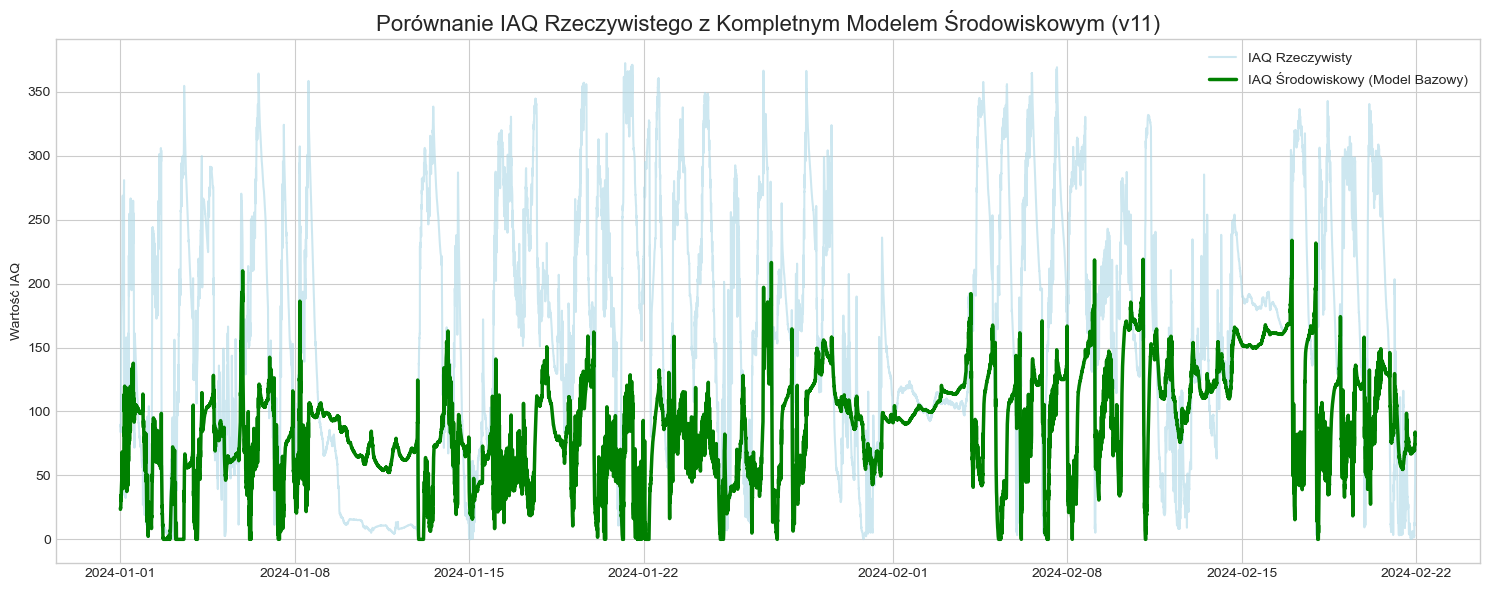

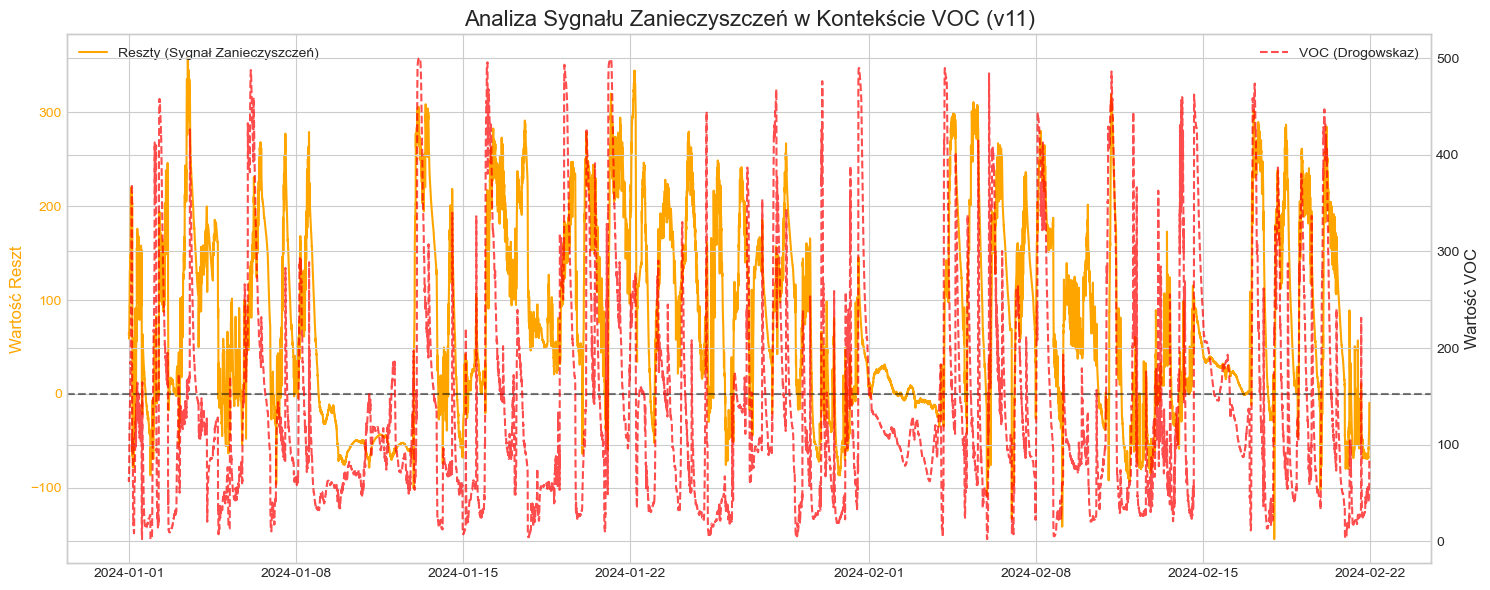

In [13]:
# optimal_iaq_pipeline_v11_shocks.py
"""
Final Advanced Pipeline modeling both stable trends and environmental shocks
to derive a comprehensive baseline and robust firmware parameters.

Core Ideological Change:
The baseline model is now trained to understand that IAQ is a function of
both slow-moving trends (EWMA of temp/hum) and rapid shocks (deltas of temp/hum).

1.  "Clean Air" periods are identified to train a pure environmental response model.
2.  A Huber model is trained on these clean periods using BOTH stable (EWMA)
    and shock (delta) features.
3.  The prediction from this model (`IAQ_environmental`) becomes the new, intelligent
    baseline that can react to legitimate environmental spikes.
4.  The final residual (`IAQ_original - IAQ_environmental`) is a much cleaner
    signal representing external pollutants (VOC/NOx).

This provides the most accurate separation of environmental effects from
pollutant events.
"""

import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from joblib import dump

from sklearn.linear_model import HuberRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import shap

# ------------------ Settings ------------------
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
OUT_DIR = "results_iaq_v11_shocks"
os.makedirs(OUT_DIR, exist_ok=True)

# ------------------ Input DF ------------------
if 'df' not in globals():
    raise RuntimeError("Please provide DataFrame `df` with columns: 'iaq','temp_pokoj','wilgotnosc','voc','nox' (and optional 'timestamp')")

required_cols = {'voc', 'nox', 'temp_pokoj', 'wilgotnosc', 'iaq'}
missing = required_cols - set(df.columns)
if missing:
    raise RuntimeError(f"Missing columns: {missing}")

if 'timestamp' not in df.columns:
    df['timestamp'] = pd.to_datetime(pd.date_range(start='2024-01-01', periods=len(df), freq='T'))
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values('timestamp').drop_duplicates(subset=['timestamp']).reset_index(drop=True)
df[list(required_cols)] = df[list(required_cols)].ffill().bfill()
print(f"Loaded {len(df)} unique samples.")

# ------------------ Helpers ------------------
def aggregate_data(input_df, freq='5T'):
    numeric_cols = ['iaq','voc','nox','temp_pokoj','wilgotnosc']
    cols = [c for c in numeric_cols if c in input_df.columns]
    df_agg = input_df.set_index('timestamp')[cols].resample(freq).median().interpolate()
    return df_agg.reset_index()

def feature_engineering(input_df):
    df_feat = input_df.copy()
    df_feat['delta_wilgotnosc'] = df_feat['wilgotnosc'].diff().abs().fillna(0)
    df_feat['delta_temp'] = df_feat['temp_pokoj'].diff().abs().fillna(0)
    df_feat['temp_ewma_10'] = df_feat['temp_pokoj'].ewm(span=10, adjust=False).mean()
    df_feat['wilg_ewma_10'] = df_feat['wilgotnosc'].ewm(span=10, adjust=False).mean()
    return df_feat

# ------------------ Pipeline Start ------------------
print("\n--- START PIPELINE (v11 - Environmental Shocks Model) ---")

# 1) Preprocessing
df_agg = aggregate_data(df, freq='5T')
print(f"Aggregated to {len(df_agg)} samples (5-min bins)")

# 2) Identify "Clean Air" periods
voc_clean_threshold = df_agg['voc'].quantile(0.25)
voc_roll_std = df_agg['voc'].rolling(window=6, center=True).std()
voc_stable_threshold = voc_roll_std.quantile(0.25)
is_clean_air = (df_agg['voc'] <= voc_clean_threshold) & (voc_roll_std <= voc_stable_threshold)
df_clean_air = df_agg[is_clean_air].reset_index(drop=True)
print(f"Identified {len(df_clean_air)} 'clean air' samples ({len(df_clean_air)/len(df_agg):.1%}) for model training.")

if len(df_clean_air) < 200:
    raise RuntimeError("Not enough 'clean air' samples to build a reliable model.")

# 3) Model the full environmental response (trends + shocks) on CLEAN DATA
df_proc_clean = feature_engineering(df_clean_air)

# Features now include both stable trends and rapid shocks
ENVIRONMENTAL_FEATURES = ['temp_ewma_10', 'wilg_ewma_10', 'delta_temp', 'delta_wilgotnosc']
X_train = df_proc_clean[ENVIRONMENTAL_FEATURES].fillna(0)
y_train = df_proc_clean['iaq'].values

print("\n-- Training Huber Regressor to model the full environmental response --")
final_model = Pipeline([('scaler', StandardScaler()), ('huber', HuberRegressor())])
final_model.fit(X_train, y_train)

# 4) Export model coefficients for firmware
scaler = final_model.named_steps['scaler']
huber = final_model.named_steps['huber']
coef_unscaled = huber.coef_ / scaler.scale_
intercept_unscaled = huber.intercept_ - np.sum((huber.coef_ * scaler.mean_) / scaler.scale_)
coeffs_df = pd.DataFrame(coef_unscaled, index=X_train.columns, columns=['beta'])
coeffs_df.loc['intercept'] = intercept_unscaled
coeffs_df.to_csv(os.path.join(OUT_DIR,'huber_model_coefficients_unscaled.csv'))
print(f"Saved unscaled linear coefficients to {os.path.join(OUT_DIR,'huber_model_coefficients_unscaled.csv')}")

# 5) Compute firmware-ready parameters
print("\n-- Deriving firmware parameters --")
beta_temp_trend = coeffs_df.loc['temp_ewma_10', 'beta']
beta_hum_trend = coeffs_df.loc['wilg_ewma_10', 'beta']
# Weighting is based on the influence of the stable trends
hum_weighting = float(abs(beta_hum_trend) / (abs(beta_hum_trend) + abs(beta_temp_trend)))

COMFORT_HUM_MIN = 35
COMFORT_HUM_MAX = 65
df_clean_air['hum_bin'] = pd.cut(df_clean_air['wilgotnosc'], bins=np.arange(0, 101, 1), labels=np.arange(0, 100, 1), right=False).astype(float)
iaq_stats_by_hbin = df_clean_air.groupby('hum_bin')['iaq'].agg(['mean', 'count'])
count_threshold = iaq_stats_by_hbin['count'].quantile(0.20)
reliable_bins = iaq_stats_by_hbin[iaq_stats_by_hbin['count'] > count_threshold]
comfort_zone_iaq = reliable_bins.loc[COMFORT_HUM_MIN:COMFORT_HUM_MAX]

if not comfort_zone_iaq.empty:
    best_hbin = comfort_zone_iaq['mean'].idxmax()
    hum_baseline = float(best_hbin)
else:
    hum_baseline = 45.0

# Other parameters remain the same as they are based on pollutant behavior
voc = df.set_index('timestamp')['voc'].resample('1H').median().interpolate().fillna(method='ffill')
rolling = voc.rolling(24, min_periods=1).mean()
ratios = (rolling / (rolling.shift(1).replace(0,np.nan))).dropna()
SIGNIFICANTLY_HIGHER_THRESHOLD = 1.1 if len(ratios) == 0 else float(1.0 + (ratios.quantile(0.95) - 1.0))
ADAPTATION_UP_FACTOR = 0.02
ADAPTATION_DECAY_FACTOR = 0.0005

fw_params = {
    'hum_weighting': hum_weighting,
    'hum_baseline': hum_baseline,
    'SIGNIFICANTLY_HIGHER_THRESHOLD': SIGNIFICANTLY_HIGHER_THRESHOLD,
    'ADAPTATION_UP_FACTOR': ADAPTATION_UP_FACTOR,
    'ADAPTATION_DECAY_FACTOR': ADAPTATION_DECAY_FACTOR,
    'notes': 'Derived from a model of trends and shocks on clean air data.'
}
fw_df = pd.DataFrame([fw_params])
fw_df.to_csv(os.path.join(OUT_DIR,'firmware_params_suggested.csv'), index=False)
print(f"\nSaved suggested firmware params to {os.path.join(OUT_DIR,'firmware_params_suggested.csv')}")
print(fw_df.T)

# 6) Apply model to ALL data to calculate residuals
print("\n-- Applying environmental model to full dataset for residual analysis --")
df_full_feat = feature_engineering(df_agg)
X_full = df_full_feat[ENVIRONMENTAL_FEATURES].fillna(0)
df_agg['iaq_environmental'] = final_model.predict(X_full)
df_agg['reszty'] = df_agg['iaq'] - df_agg['iaq_environmental']
df_agg['iaq_environmental'] = df_agg['iaq_environmental'].clip(lower=0)

df_agg.to_csv(os.path.join(OUT_DIR,'final_results_with_residuals.csv'), index=False)
dump(final_model, os.path.join(OUT_DIR,'final_huber_model.joblib'))

print("\n--- PIPELINE COMPLETE ---")
print(f"All artifacts saved in: {OUT_DIR}")

# 7) Visualization
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(15,6))
plt.plot(df_agg['timestamp'], df_agg['iaq'], label='IAQ Rzeczywisty', alpha=0.6, zorder=1, color='lightblue')
plt.plot(df_agg['timestamp'], df_agg['iaq_environmental'], label='IAQ Środowiskowy (Model Bazowy)', color='green', linewidth=2.5, zorder=2)
plt.title('Porównanie IAQ Rzeczywistego z Kompletnym Modelem Środowiskowym (v11)', fontsize=16)
plt.ylabel('Wartość IAQ')
plt.legend(); plt.tight_layout(); plt.show()

fig, ax1 = plt.subplots(figsize=(15, 6))
ax1.plot(df_agg['timestamp'], df_agg['reszty'], label='Reszty (Sygnał Zanieczyszczeń)', color='orange')
ax1.axhline(0, color='black', linestyle='--', alpha=0.5)
ax1.set_ylabel("Wartość Reszt", color='orange', fontsize=12)
ax1.tick_params(axis='y', labelcolor='orange')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.plot(df_agg['timestamp'], df_agg['voc'], label='VOC (Drogowskaz)', color='red', linestyle='--', alpha=0.7)
ax2.set_ylabel("Wartość VOC", fontsize=12)
ax2.legend(loc='upper right')
plt.title("Analiza Sygnału Zanieczyszczeń w Kontekście VOC (v11)", fontsize=16)
fig.tight_layout()
plt.show()


## 4. LOGIKA FAZY 2: TRENING MODELU ŚRODOWISKA

### LGBMRegressor (porzucono nie ma możlwiości dobrej ekstrapolacji dla modelu RL)

In [ ]:
# class LGBMVisualizer:
#     """Klasa dedykowana do wizualizacji wyników treningu modelu LGBM."""
#     def __init__(self):
#         sns.set_style("whitegrid")
#         plt.rcParams['figure.dpi'] = 100
#         plt.rcParams['figure.facecolor'] = 'white'

#     def plot_rfe_results(self, selector: RFECV, target_name: str):
#         """Wizualizuje wyniki selekcji cech RFECV."""
#         try:
#             fig, ax = plt.subplots(figsize=(12, 6))
#             cv_results = selector.cv_results_
#             mean_scores = cv_results["mean_test_score"]
#             feature_counts = selector.n_features_to_select_

#             ax.plot(feature_counts, mean_scores, marker='o', linestyle='-')
#             ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
#             ax.set_title(f'Wyniki RFECV dla celu: {target_name}')
#             ax.set_xlabel("Liczba wybranych cech")
#             ax.set_ylabel("Cross-Validation Score (Negatywny MAE)")
#             ax.axvline(selector.n_features_, color='r', linestyle='--', label=f'Optymalnie: {selector.n_features_} cech')
#             ax.legend()
#             ax.grid(True, which='both', linestyle='--')
#             plt.tight_layout()
#             plt.show()
#         except Exception as e:
#             print(f"Błąd podczas wizualizacji RFECV: {e}")

#     def plot_feature_importance(self, model: MultiOutputRegressor, feature_names: List[str], target_columns: List[str]):
#         """Wizualizuje ważność cech dla każdego z wielu celów."""
#         try:
#             if not hasattr(model, 'estimators_'): return
            
#             num_estimators = len(model.estimators_)
#             n_cols = 2
#             n_rows = (num_estimators + n_cols - 1) // n_cols

#             fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
#             axes = axes.flatten()

#             for i, (est, target_name) in enumerate(zip(model.estimators_, target_columns)):
#                 importances = pd.DataFrame({'feature': feature_names, 'importance': est.feature_importances_}).sort_values('importance', ascending=False).head(20)
#                 sns.barplot(x='importance', y='feature', data=importances, ax=axes[i], palette='viridis_r')
#                 axes[i].set_title(f'Top 20 Cech dla Celu: {target_name}')
#                 axes[i].set_xlabel("Ważność")
#                 axes[i].set_ylabel("Cecha")

#             for j in range(i + 1, len(axes)):
#                 fig.delaxes(axes[j])

#             fig.suptitle("Ważność Cech w Modelach LGBM (dla kwantyla 0.5)", fontsize=18, weight='bold')
#             plt.tight_layout(rect=[0, 0.03, 1, 0.96])
#             plt.show()
#         except Exception as e:
#             print(f"Błąd podczas wizualizacji ważności cech: {e}")
            
#     def plot_optuna_study(self, study: optuna.Study):
#         """Tworzy kompletny pulpit wizualizacji dla badania Optuny."""
#         print("\n-> Wizualizacja wyników optymalizacji hiperparametrów...")
#         try:
#             if not optuna.visualization.is_available(): return

#             valid_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE and t.values is not None and all(np.isfinite(v) and abs(v) < 1e10 for v in t.values)]
#             if not valid_trials: return
            
#             pruned_study = optuna.create_study(directions=study.directions)
#             pruned_study.add_trials(valid_trials)

#             optuna.visualization.plot_pareto_front(pruned_study, target_names=["MAE Temp", "MAE Moc"]).show()
#             optuna.visualization.plot_optimization_history(pruned_study, target=lambda t: t.values[0], target_name="MAE Temp").show()
#             optuna.visualization.plot_optimization_history(pruned_study, target=lambda t: t.values[1], target_name="MAE Moc").show()
#             optuna.visualization.plot_param_importances(pruned_study, target=lambda t: t.values[0], target_name="MAE Temp").show()
#         except Exception as e:
#             print(f"Błąd podczas wizualizacji badania Optuny: {e}")
            
#     def plot_predictions(self, y_true: pd.DataFrame, y_pred: pd.DataFrame, initial_state: pd.DataFrame, title_suffix: str, sample_size: int = None):
#         """Wizualizuje predykcje modelu z ograniczeniem osi Y dla czytelności."""
#         print(f"\n-> Wizualizacja predykcji ({title_suffix})...")
        
#         df = initial_state[['temp_pokoj', 'moc']].join(y_true, how='inner').join(y_pred, how='inner')
        
#         if df.empty:
#             print("Nie można zwizualizować predykcji - brak wspólnych danych po złączeniu.")
#             return
            
#         for q in [0.05, 0.5, 0.95]:
#             if f'temp_delta_target_{q}' in df.columns:
#                 df[f'temp_pred_{q}'] = df['temp_pokoj'] + df[f'temp_delta_target_{q}']
#                 df[f'moc_pred_{q}'] = df['moc'] + df[f'moc_delta_target_{q}']
        
#         df['temp_true_target'] = df['temp_pokoj'] + df['temp_delta_target']
#         df['moc_true_target'] = df['moc'] + df['moc_delta_target']
        
#         df.dropna(subset=['temp_true_target', 'temp_pred_0.5', 'moc_true_target', 'moc_pred_0.5'], inplace=True)
        
#         if df.empty:
#             print("Brak danych do narysowania po usunięciu wartości NaN.")
#             return
            
#         plot_data = df.tail(sample_size) if sample_size and sample_size < len(df) else df
#         title = f"Porównanie Predykcji z Rzeczywistością - {title_suffix}"
#         if sample_size:
#             title += f"\n(ostatnie {len(plot_data)} punktów)"

#         fig, axes = plt.subplots(2, 1, figsize=(18, 12), sharex=True, gridspec_kw={'height_ratios': [3, 2]})
        
#         # Wykres Temperatury
#         axes[0].plot(plot_data.index, plot_data['temp_true_target'], label='Wartość rzeczywista', color='#003f5c', marker='.', markersize=2, linestyle='-')
#         axes[0].plot(plot_data.index, plot_data['temp_pred_0.5'], label='Predykcja (mediana)', color='#ffa600', lw=2, linestyle='--')
#         axes[0].fill_between(plot_data.index, plot_data['temp_pred_0.05'], plot_data['temp_pred_0.95'], color='#ffa600', alpha=0.2, label='Przedział ufności (90%)')
#         axes[0].set_title('Predykcja Temperatury w Pokoju')
#         axes[0].set_ylabel('Temperatura [°C]')
#         axes[0].legend()
#         axes[0].grid(True)
        
#         sane_temp_data = pd.concat([plot_data['temp_true_target'], plot_data['temp_pred_0.5']])
#         q1, q99 = sane_temp_data.quantile(0.02), sane_temp_data.quantile(0.98)
#         margin = (q99 - q1) * 0.1
#         axes[0].set_ylim(q1 - margin, q99 + margin)

#         # Wykres Mocy
#         axes[1].plot(plot_data.index, plot_data['moc_true_target'], label='Wartość rzeczywista', color='#003f5c', marker='.', markersize=2, linestyle='-')
#         axes[1].plot(plot_data.index, plot_data['moc_pred_0.5'], label='Predykcja (mediana)', color='#bc5090', lw=2, linestyle='--')
#         axes[1].fill_between(plot_data.index, plot_data['moc_pred_0.05'], plot_data['moc_pred_0.95'], color='#bc5090', alpha=0.2, label='Przedział ufności (90%)')
#         axes[1].set_title('Predykcja Mocy Klimatyzacji')
#         axes[1].set_ylabel('Moc [W]')
#         axes[1].legend()
#         axes[1].grid(True)

#         sane_moc_data = pd.concat([plot_data['moc_true_target'], plot_data['moc_pred_0.5']])
#         q1_moc, q99_moc = sane_moc_data.quantile(0.01), sane_moc_data.quantile(0.99)
#         margin_moc = (q99_moc - q1_moc) * 0.1
#         axes[1].set_ylim(max(0, q1_moc - margin_moc), q99_moc + margin_moc)
        
#         fig.suptitle(title, fontsize=18, weight='bold')
#         plt.tight_layout(rect=[0, 0, 1, 0.95])
#         plt.show()


In [ ]:
# class EnvironmentModelTrainerLGBM:
#     """
#     Trenuje model LGBM, a następnie konwertuje go i zapisuje w dwóch formatach:
#     1. Oryginalny format LightGBM (.pkl) - do analiz i inspekcji.
#     2. Natywny format PyTorch (.pt) - do wysokowydajnej inferencji w środowisku RL.
#     """
#     def __init__(self, cfg: 'Config', preprocessor: 'Preprocessor'):
#         self.config = cfg
#         self.preprocessor = preprocessor
#         self.model = None
#         self.scaler = None
#         self.model_columns = None
#         self.n_jobs = self.config.N_JOBS
#         self.visualizer = LGBMVisualizer() # Odkomentuj, jeśli klasa jest dostępna

#     def _prepare_model_data(self, df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame, pd.Series]:
#         """
#         [FINALNA POPRAWIONA LOGIKA] Tworzy cele (delty) na podstawie przyszłości wygładzonej
#         ADAPTACYJNYM oknem, stosując wygładzanie tylko wtedy, gdy jest to sensowne.
#         """
#         print("-> Tworzenie celów predykcyjnych (delta) dla wielu horyzontów z użyciem adaptacyjnego wygładzania...")
#         df_copy = df.copy()

#         self.horizons = [
#             self.config.PREDICTION_HORIZON_MIN1, self.config.PREDICTION_HORIZON_MIN2,
#             self.config.PREDICTION_HORIZON_MIN3, self.config.PREDICTION_HORIZON_MIN4,
#         ]
        
#         target_columns = []
#         for h in self.horizons:
#             smoothing_fraction = getattr(self.config, 'SMOOTHING_WINDOW_FRACTION', 0.5)
            
#             smoothing_window = max(1, int(h * smoothing_fraction))
#             if smoothing_window > 1 and smoothing_window % 2 == 0:
#                 smoothing_window -= 1
            
#             if smoothing_window <= 1:
#                 print(f"   -> Generowanie celów dla horyzontu: {h} min (bez wygładzania, okno <= 1)")
#                 smoothed_temp = df_copy['temp_pokoj']
#                 smoothed_moc = df_copy['moc']
#             else:
#                 print(f"   -> Generowanie celów dla horyzontu: {h} min (okno wygładzania: {smoothing_window} min)")
#                 smoothed_temp = df_copy['temp_pokoj'].rolling(window=smoothing_window, center=True, min_periods=1).mean()
#                 smoothed_moc = df_copy['moc'].rolling(window=smoothing_window, center=True, min_periods=1).mean()

#             temp_col_name = f'temp_delta_target_{h}m'
#             moc_col_name = f'moc_delta_target_{h}m'
            
#             df_copy[temp_col_name] = smoothed_temp.shift(-h) - df_copy['temp_pokoj']
#             df_copy[moc_col_name] = smoothed_moc.shift(-h) - df_copy['moc']
            
#             target_columns.extend([temp_col_name, moc_col_name])

#         full_data = df_copy.dropna(subset=target_columns)

#         final_weights = pd.Series(1.0, index=full_data.index)
#         if 'state' in full_data.columns:
#             is_active = full_data['state'].isin(['cool'])
#             final_weights[is_active] = 2.0
#         if 'state_changed' in full_data.columns:
#             has_changed = full_data['state_changed'] == 1.0
#             final_weights[has_changed] = 5.0
#         print("-> Zastosowano wagi: 5.0 dla zmian stanu, 2.0 dla aktywnych stanów, 1.0 dla pozostałych.")

#         feature_cols = [
#             c for c in df.columns 
#             if c not in target_columns and 
#             c not in ['temp_pokoj', 'moc', 'state_changed', 'state'] and 
#             '_lag_' not in c
#         ]
        
#         return full_data[feature_cols], full_data[target_columns], final_weights

#     def _run_feature_selection(self, X: pd.DataFrame, y: pd.DataFrame, target_name: str, target_idx: int) -> List[str]:
#         print(f"\n-> Uruchamianie selekcji cech (RFECV) dla głównego celu: {target_name}...")
#         estimator = lgb.LGBMRegressor(random_state=42, objective='regression_l1', n_jobs=1)
#         selector = RFECV(estimator=estimator, step=1, cv=TimeSeriesSplit(n_splits=self.config.N_SPLITS_FOR_CV), scoring="neg_mean_absolute_error", min_features_to_select=10, n_jobs=self.n_jobs)
#         selector.fit(X, y.iloc[:, target_idx])
#         self.visualizer.plot_rfe_results(selector, target_name)
#         selected_features = list(X.columns[selector.support_])
#         print(f"-> RFECV dla '{target_name}' wybrało {len(selected_features)} z {len(X.columns)} cech.")
#         return selected_features

#     def _optimize_hyperparams(self, X: pd.DataFrame, y: pd.DataFrame, sample_weight: pd.Series) -> Dict[str, Any]:
#         print("\n-> Uruchamianie optymalizacji wielokryterialnej dla LGBM (Multi-Horizon)...")
#         study_name = f"lgbm_multihorizon_features_{abs(hash('_'.join(sorted(X.columns)))) % (10**8)}"
#         storage_name = f"sqlite:///{study_name}.db"
#         print(f"-> Używanie badania Optuny: {study_name}")

#         def objective(trial: optuna.Trial) -> Tuple[float, float]:
#             params = {
#                 'objective': 'regression_l1', 'metric': 'mae', 'random_state': 42, 'verbose': -1, 'n_jobs': 1,
#                 'n_estimators': trial.suggest_int('n_estimators', 200, 1500), 'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.45, log=True),
#                 'num_leaves': trial.suggest_int('num_leaves', 5, 150), 'max_depth': trial.suggest_int('max_depth', 5, 32),
#                 'min_child_samples': trial.suggest_int('min_child_samples', 30, 150), 'feature_fraction': trial.suggest_float('feature_fraction', 0.05, 1.0),
#                 'bagging_fraction': trial.suggest_float('bagging_fraction', 0.05, 1.0), 'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
#                 'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True), 'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
#             }
#             tscv = TimeSeriesSplit(n_splits=self.config.N_SPLITS_FOR_CV)
#             total_weighted_error_temp, total_weighted_error_moc = 0, 0
#             horizon_weights = [1.0, 0.7, 0.4, 0.2]

#             for train_idx, val_idx in tscv.split(X):
#                 X_train, y_train, w_train = X.iloc[train_idx], y.iloc[train_idx], sample_weight.iloc[train_idx]
#                 X_val, y_val, w_val = X.iloc[val_idx], y.iloc[val_idx], sample_weight.iloc[val_idx]
#                 model = MultiOutputRegressor(lgb.LGBMRegressor(**params), n_jobs=self.n_jobs).fit(X_train, y_train, sample_weight=w_train)
#                 preds = model.predict(X_val)
#                 fold_weighted_error_temp, fold_weighted_error_moc = 0, 0
#                 for i, weight in enumerate(horizon_weights):
#                     temp_col_idx, moc_col_idx = i * 2, i * 2 + 1
#                     error_temp = mean_absolute_error(y_val.iloc[:, temp_col_idx], preds[:, temp_col_idx], sample_weight=w_val)
#                     error_moc = mean_absolute_error(y_val.iloc[:, moc_col_idx], preds[:, moc_col_idx], sample_weight=w_val)
#                     fold_weighted_error_temp += error_temp * weight
#                     fold_weighted_error_moc += error_moc * weight
#                 total_weighted_error_temp += fold_weighted_error_temp
#                 total_weighted_error_moc += fold_weighted_error_moc

#             return total_weighted_error_temp / self.config.N_SPLITS_FOR_CV, total_weighted_error_moc / self.config.N_SPLITS_FOR_CV

#         study = optuna.create_study(directions=['minimize', 'minimize'], sampler=optuna.samplers.TPESampler(seed=42), pruner=optuna.pruners.MedianPruner(), study_name=study_name, storage=storage_name, load_if_exists=True)
#         study.optimize(objective, n_trials=self.config.OPTUNA_TRIALS, n_jobs=1)
        
#         self.visualizer.plot_optuna_study(study)
        
#         valid_trials = [t for t in study.best_trials if t.state == optuna.trial.TrialState.COMPLETE and t.values is not None and all(np.isfinite(v) for v in t.values)]
#         if not valid_trials: return {}
#         if len(valid_trials) == 1:
#             best_trial = valid_trials[0]
#         else:
#             values = np.array([t.values for t in valid_trials])
#             min_vals, max_vals = np.min(values, axis=0), np.max(values, axis=0)
#             range_vals = np.where(max_vals - min_vals == 0, 1, max_vals - min_vals)
#             normalized_values = (values - min_vals) / range_vals
#             best_trial = valid_trials[np.argmin(np.linalg.norm(normalized_values, axis=1))]
        
#         print(f"\n-> Wybrano parametry z próby {best_trial.number} jako najlepszy kompromis.")
#         return best_trial.params
        
#     def run_training_pipeline(self) -> None:
#         warnings.filterwarnings("ignore", category=UserWarning)
        
#         print("="*50); print("ROZPOCZYNANIE POTOKU TRENINGOWEGO MODELU LGBM (SMOOTHED TARGETS)"); print("="*50)
        
#         df_full = self.preprocessor.run()
#         if df_full.empty: return

#         X_cand, y_delta_multitask, sample_weights = self._prepare_model_data(df_full)

#         split_index = int(len(X_cand) * 0.8)
#         X_dev, X_test = X_cand[:split_index], X_cand[split_index:]
#         y_dev, y_test = y_delta_multitask[:split_index], y_delta_multitask[split_index:]
#         weights_dev = sample_weights[:split_index]
#         print(f"\n-> Podział danych: {len(X_dev)} w deweloperskim, {len(X_test)} w testowym.")

#         self.scaler = StandardScaler().fit(X_dev)
#         X_dev_scaled = pd.DataFrame(self.scaler.transform(X_dev), index=X_dev.index, columns=X_dev.columns)
        
#         selected_features_temp = self._run_feature_selection(X_dev_scaled, y_dev, "Temperatura (Horyzont 1)", 0)
#         selected_features_moc = self._run_feature_selection(X_dev_scaled, y_dev, "Moc (Horyzont 1)", 1)
        
#         combined_auto_features = set(selected_features_temp) | set(selected_features_moc)
#         protected_features = {c for c in X_dev_scaled.columns if any(p in c for p in ['state_', 'fan_mode_str_', 'swing_mode_str_'])}
#         self.model_columns = [c for c in X_cand.columns if c in (combined_auto_features | protected_features)]
        
#         print(f"-> Finalny zestaw {len(self.model_columns)} cech zostanie użyty do treningu.")
#         X_dev_final = X_dev_scaled[self.model_columns]

#         best_params = self._optimize_hyperparams(X_dev_final, y_dev, weights_dev)
#         if not best_params: return
        
#         print("\n-> Trening finalnych modeli kwantylowych (Multi-Horizon)...")
#         self.model = {}
#         for q in [0.05, 0.5, 0.95]:
#             quantile_params = {**best_params, 'objective': 'quantile', 'alpha': q, 'metric': 'quantile'}
#             self.model[q] = MultiOutputRegressor(lgb.LGBMRegressor(random_state=42, **quantile_params), n_jobs=self.n_jobs).fit(X_dev_final, y_dev, sample_weight=weights_dev)
#         print("-> Trening finalny zakończony.")
        
#         if 0.5 in self.model:
#             self.visualizer.plot_feature_importance(self.model[0.5], self.model_columns, y_dev.columns.tolist())

#         self._convert_and_save_models(X_dev_final.iloc[:1])


#     def _convert_and_save_models(self, sample_input: pd.DataFrame) -> None:
#         """
#         Konwertuje wytrenowane modele LGBM do formatu PyTorch za pomocą hummingbird-ml
#         i zapisuje oba formaty (oryginalny i skonwertowany) wraz z pozostałymi artefaktami.
#         """
#         print("\n-> Zapisywanie artefaktów...")
#         try:
#             os.makedirs(self.config.BASE_MODEL_DIR, exist_ok=True)
            
#             # 1. Zapis oryginalnych modeli LGBM (.pkl)
#             joblib.dump(self.model, os.path.join(self.config.BASE_MODEL_DIR, self.config.LGBM_MODEL_FILE))
            
#             # 2. Zapis pozostałych artefaktów
#             joblib.dump(self.model_columns, os.path.join(self.config.BASE_MODEL_DIR, self.config.LGBM_COLUMNS_FILE))
#             joblib.dump(self.scaler, os.path.join(self.config.BASE_MODEL_DIR, self.config.LGBM_SCALER_FILE))
            
#             print("-> Oryginalne modele i artefakty zapisane.")

#             # 3. Konwersja i zapis natywnych modeli PyTorch (.pt)
#             print("-> Konwersja modeli do formatu PyTorch za pomocą hummingbird-ml...")
#             pytorch_models = {}
#             for q, lgbm_model in self.model.items():
#                 print(f"  -> Konwertowanie modelu dla kwantyla: {q}")
#                 # Używamy przykładowego wejścia do inferencji typów danych
#                 pytorch_models[q] = hummingbird.ml.convert(lgbm_model, 'pytorch', sample_input).model
            
#             # Dodajemy nową nazwę pliku do konfiguracji, jeśli jej tam nie ma
#             if not hasattr(self.config, 'LGBM_PYTORCH_MODEL_FILE'):
#                 self.config.LGBM_PYTORCH_MODEL_FILE = 'lgbm_probabilistic_model.pt'

#             pytorch_model_path = os.path.join(self.config.BASE_MODEL_DIR, self.config.LGBM_PYTORCH_MODEL_FILE)
#             torch.save(pytorch_models, pytorch_model_path)
#             print(f"-> Skonwertowane modele PyTorch zapisane w: {pytorch_model_path}")
            
#             print(">>> Proces zakończony sukcesem!")

#         except Exception as e:
#             print(f"BŁĄD podczas zapisywania artefaktów: {e}")

### N-BEATS u8darts

In [ ]:
# # --- Konfiguracja logowania i ostrzeżeń ---
# logging.getLogger('lightning').setLevel(logging.ERROR)
# warnings.filterwarnings("ignore", category=UserWarning)
# warnings.filterwarnings("ignore", category=FutureWarning)
# warnings.filterwarnings("ignore", category=optuna.exceptions.ExperimentalWarning)
# logging.getLogger("lightning.pytorch.utilities.rank_zero").setLevel(logging.WARNING)

# class EnvironmentModelTrainerNBEATS:
#     def __init__(self, cfg: 'Config', preprocessor: 'Preprocessor'):
#         self.config = cfg
#         self.preprocessor = preprocessor
#         self.model = None
#         self.target_scalers = {}
#         self.covs_scaler = None
#         self.covariate_columns = None
#         self.target_columns = None
#         self.study = None
#         self.input_chunk_length = self.config.PREDICTION_HORIZON_MIN3

#         self.pl_trainer_kwargs_for_training = {
#             "accelerator": "cpu", "devices": 1, "strategy": "auto",
#             "enable_progress_bar": False, "enable_model_summary": False,
#             "logger": False, "gradient_clip_val": 1.0,
#         }
#         sns.set_style("whitegrid")
#         plt.rcParams['figure.dpi'] = 450
#         plt.rcParams['figure.facecolor'] = 'white'

#     def _objective(self, trial: optuna.Trial, dev_target_series: TimeSeries, dev_covs_series: TimeSeries, sample_weights_full_dev: pd.Series, tscv: TimeSeriesSplit) -> tuple[float, float]:
#         torch.set_num_threads(12)
#         params = {
#             'generic_architecture': True,
#             'num_stacks': trial.suggest_int('num_stacks', 1, 4),
#             'num_blocks': trial.suggest_int('num_blocks', 1, 3),
#             'num_layers': trial.suggest_int('num_layers', 1, 63),
#             'layer_widths': trial.suggest_int('layer_widths', 12, 192),
#             'expansion_coefficient_dim': trial.suggest_int('expansion_coefficient_dim', 2, 16),
#             'dropout': trial.suggest_float('dropout', 0.0, 0.25),
#             'lr': trial.suggest_float('lr', 1e-5, 1e-2, log=True),
#             'weight_decay': trial.suggest_float('weight_decay', 1e-6, 1e-2, log=True),
#             'n_epochs': trial.suggest_int('n_epochs', 10, 55),
#             'batch_size': trial.suggest_int('batch_size', 128, 2560),
#         }
#         trainer_kwargs = self.pl_trainer_kwargs_for_training.copy()
#         trainer_kwargs['callbacks'] = [EarlyStopping(monitor="train_loss", patience=8, min_delta=0.001, mode='min')]
        
#         model_params = params.copy()
#         temp_optimizer_kwargs = {'lr': model_params.pop('lr'), 'weight_decay': model_params.pop('weight_decay')}
        
#         common_model_args = {
#             "input_chunk_length": self.input_chunk_length,
#             "output_chunk_length": self.config.PREDICTION_HORIZON_MIN3,
#             "pl_trainer_kwargs": trainer_kwargs,
#             "optimizer_kwargs": temp_optimizer_kwargs, "random_state": 42, **model_params
#         }
        
#         fold_errors_temp, fold_errors_moc = [], []
#         dev_target_df = dev_target_series.pd_dataframe()
        
#         for train_indices, val_indices in tscv.split(dev_target_df):
#             model_multi = NBEATSModel(
#                 likelihood=QuantileRegression(quantiles=[0.05, 0.5, 0.95]), 
#                 **common_model_args
#             )

#             train_target_df_fold = dev_target_df.iloc[train_indices]
#             val_target_df_fold = dev_target_df.iloc[val_indices]

#             train_target_fold_orig = TimeSeries.from_dataframe(train_target_df_fold, freq=self.config.FREQ)
#             val_target_fold_orig = TimeSeries.from_dataframe(val_target_df_fold, freq=self.config.FREQ)

#             if len(val_target_fold_orig) == 0 or len(train_target_fold_orig) < common_model_args["input_chunk_length"]:
#                 continue

#             train_covs_fold_orig = dev_covs_series.slice_intersect(train_target_fold_orig)
#             w_val_fold = sample_weights_full_dev.loc[val_target_fold_orig.time_index]
#             if w_val_fold.empty: continue

#             target_scaler_fold = Scaler(StandardScaler())
#             cov_scaler_fold = Scaler(StandardScaler())
#             train_target_fold_scaled = target_scaler_fold.fit_transform(train_target_fold_orig)
#             train_covs_fold_scaled = cov_scaler_fold.fit_transform(train_covs_fold_orig)
            
#             model_multi.fit(series=train_target_fold_scaled, past_covariates=train_covs_fold_scaled, verbose=False)
            
#             dev_covs_series_scaled_for_fold = cov_scaler_fold.transform(dev_covs_series)

#             n_to_predict = min(len(val_target_fold_orig), self.config.PREDICTION_HORIZON_MIN3)
#             if n_to_predict <= 0:
#                 continue

#             forecast_multi_scaled = model_multi.predict(
#                 n=n_to_predict,
#                 series=train_target_fold_scaled,
#                 past_covariates=dev_covs_series_scaled_for_fold,
#                 predict_likelihood_parameters=True,
#                 show_warnings=False,
#             )
            
#             scaler = target_scaler_fold._fitted_params[0][1]['fitted']
#             scaled_values = forecast_multi_scaled.values()
#             mean_ = scaler.mean_
#             scale_ = scaler.scale_
#             num_quantiles = len(model_multi.likelihood.quantiles)
#             unscale_mean = np.tile(mean_, num_quantiles)
#             unscale_std = np.tile(scale_, num_quantiles)
#             unscaled_values = scaled_values * unscale_std + unscale_mean
#             forecast_multi_unscaled = TimeSeries.from_times_and_values(
#                 times=forecast_multi_scaled.time_index,
#                 values=unscaled_values,
#                 columns=forecast_multi_scaled.columns,
#                 freq=forecast_multi_scaled.freq
#             )
            
#             y_pred_df = forecast_multi_unscaled.pd_dataframe()
#             y_true_df = val_target_fold_orig.slice_n_points_after(val_target_fold_orig.start_time(), n_to_predict).pd_dataframe()
            
#             median_temp_col, median_moc_col = 'temp_delta_target_0.5', 'moc_delta_target_0.5'
#             if median_temp_col not in y_pred_df.columns or median_moc_col not in y_pred_df.columns:
#                 print(f"OSTRZEŻENIE: Brak oczekiwanych kolumn kwantyli w foldzie. Dostępne kolumny: {y_pred_df.columns.tolist()}")
#                 return float('inf'), float('inf')

#             y_true_temp, y_pred_temp = y_true_df['temp_delta_target'], y_pred_df[median_temp_col]
#             y_true_moc, y_pred_moc = y_true_df['moc_delta_target'], y_pred_df[median_moc_col]
            
#             if y_pred_temp.isnull().any() or y_pred_moc.isnull().any():
#                 return float('inf'), float('inf')

#             fold_errors_temp.append(mean_absolute_error(y_true_temp, y_pred_temp, sample_weight=w_val_fold.values[:n_to_predict]))
#             fold_errors_moc.append(mean_absolute_error(y_true_moc, y_pred_moc, sample_weight=w_val_fold.values[:n_to_predict]))

#         if not fold_errors_temp or not fold_errors_moc:
#             return float('inf'), float('inf')
#         return np.mean(fold_errors_temp), np.mean(fold_errors_moc)

#     def _optimize_hyperparams(self, dev_target_series, dev_covs_series, sample_weights_full_dev):
#         print("\n-> Uruchamianie optymalizacji wielokryterialnej dla zunifikowanego modelu NBEATS...")
#         tscv = TimeSeriesSplit(n_splits=self.config.N_SPLITS_FOR_CV)
#         self.study = optuna.create_study(
#             directions=['minimize', 'minimize'], 
#             sampler=optuna.samplers.TPESampler(seed=42), 
#             pruner=optuna.pruners.MedianPruner(), 
#             study_name="nbeats_generic_v2", 
#             storage=f"sqlite:///nbeats_generic_v2.db", 
#             load_if_exists=True
#         )
#         self.study.optimize(
#             lambda trial: self._objective(trial, dev_target_series, dev_covs_series, sample_weights_full_dev, tscv), 
#             n_trials=self.config.OPTUNA_TRIALS, 
#             show_progress_bar=True
#         )
        
#         pareto_front = self.study.best_trials
#         if not pareto_front:
#             print("BŁĄD: Nie znaleziono żadnych pomyślnych prób w optymalizacji.")
#             return {}

#         values1 = np.array([t.values[0] for t in pareto_front])
#         values2 = np.array([t.values[1] for t in pareto_front])
        
#         norm_values1 = (values1 - values1.min()) / (values1.max() - values1.min() + 1e-9)
#         norm_values2 = (values2 - values2.min()) / (values2.max() - values2.min() + 1e-9)
        
#         distances = np.sqrt(norm_values1**2 + norm_values2**2)
#         best_trial_index = np.argmin(distances)
#         best_trial = pareto_front[best_trial_index]

#         print(f"\n-> Znaleziono {len(pareto_front)} prób na froncie Pareto.")
#         print(f"-> Wybrano parametry z próby {best_trial.number} jako najlepszy kompromis (najbliżej punktu utopijnego).")
#         print(f"   - Wartości błędów (Temp, Moc): ({best_trial.values[0]:.4f}, {best_trial.values[1]:.4f})")
#         return best_trial.params

#     def _prepare_model_data(self, df):
#         horizon = self.config.PREDICTION_HORIZON_MIN3
#         df_copy = df.copy()
#         print("-> Przygotowywanie danych dla modelu...")
#         if df_copy.index.tz is not None: df_copy.index = df_copy.index.tz_localize(None)
#         for col in df_copy.select_dtypes(include=['float64']).columns: df_copy[col] = df_copy[col].astype('float32')
        
#         df_copy['temp_delta_target'] = df_copy['temp_pokoj'].shift(-horizon) - df_copy['temp_pokoj']
#         df_copy['moc_delta_target'] = df_copy['moc'].shift(-horizon) - df_copy['moc']
#         df_copy.dropna(subset=['temp_delta_target', 'moc_delta_target'], inplace=True)
        
#         self.target_columns = ['temp_delta_target', 'moc_delta_target']
#         self.covariate_columns = [col for col in self.config.COVARIATE_COLUMNS_TO_USE if col in df_copy.columns]
        
#         missing_cols = set(self.config.COVARIATE_COLUMNS_TO_USE) - set(df_copy.columns)
#         if missing_cols:
#             print(f"OSTRZEŻENIE: Następujące kowarianty zdefiniowane w konfiguracji nie zostały znalezione w danych i zostaną pominięte: {missing_cols}")
        
#         print(f"-> Używane kolumny docelowe ({len(self.target_columns)}): {self.target_columns}")
#         print(f"-> Używane kowarianty ({len(self.covariate_columns)}): {self.covariate_columns}")
        
#         target_series = TimeSeries.from_dataframe(df_copy, value_cols=self.target_columns, freq=self.config.FREQ)
#         covariate_series = TimeSeries.from_dataframe(df_copy, value_cols=self.covariate_columns, freq=self.config.FREQ)
        
#         final_weights = pd.Series(1.0, index=df_copy.index, dtype='float32')
#         return df_copy.loc[target_series.time_index], target_series, covariate_series, final_weights.loc[target_series.time_index]

#     def _visualize_results(self, df_base: pd.DataFrame, oof_result: tuple, test_result: tuple):
#         print("-> Rekonstrukcja i wizualizacja wyników (OOF + Test)...")
#         fig, axes = plt.subplots(2, 1, figsize=(20, 14), sharex=True)
        
#         def plot_predictions(ax_temp, ax_moc, df_plot, label_suffix, color):
#             if df_plot.empty:
#                 print(f"OSTRZEŻENIE: Brak danych do wizualizacji dla {label_suffix}.")
#                 return
            
#             df_plot['temp_true_reconstructed'] = df_plot['temp_pokoj'] + df_plot['temp_delta_target_true']
#             ax_temp.plot(df_plot.index, df_plot['temp_true_reconstructed'], color='#003f5c', label=f'Rzeczywistość', marker='.', markersize=2, linestyle='-')
#             df_plot['moc_true_reconstructed'] = df_plot['moc'] + df_plot['moc_delta_target_true']
#             ax_moc.plot(df_plot.index, df_plot['moc_true_reconstructed'], color='#003f5c', label=f'Rzeczywistość', marker='.', markersize=2, linestyle='-')

#             median_temp_col = 'temp_delta_target_0.5'
#             lower_temp_col, upper_temp_col = 'temp_delta_target_0.05', 'temp_delta_target_0.95'
#             median_moc_col = 'moc_delta_target_0.5'
#             lower_moc_col, upper_moc_col = 'moc_delta_target_0.05', 'moc_delta_target_0.95'

#             if median_temp_col in df_plot.columns:
#                 df_plot['temp_pred_reconstructed'] = df_plot['temp_pokoj'] + df_plot[median_temp_col]
#                 ax_temp.plot(df_plot.index, df_plot['temp_pred_reconstructed'], color=color, lw=1.5, linestyle='--', label=f'Predykcja ({label_suffix})')
#                 mae_temp = mean_absolute_error(df_plot['temp_true_reconstructed'], df_plot['temp_pred_reconstructed'])
#                 print(f"   -> {label_suffix} MAE Temp: {mae_temp:.4f} °C")
                
#                 if lower_temp_col in df_plot.columns and upper_temp_col in df_plot.columns:
#                     df_plot['temp_pred_lower'] = df_plot['temp_pokoj'] + df_plot[lower_temp_col]
#                     df_plot['temp_pred_upper'] = df_plot['temp_pokoj'] + df_plot[upper_temp_col]
#                     ax_temp.fill_between(df_plot.index, df_plot['temp_pred_lower'], df_plot['temp_pred_upper'], color=color, alpha=0.2, label='Przedział ufności 90%')

#             if median_moc_col in df_plot.columns:
#                 df_plot['moc_pred_reconstructed'] = df_plot['moc'] + df_plot[median_moc_col]
#                 ax_moc.plot(df_plot.index, df_plot['moc_pred_reconstructed'], color=color, lw=1.5, linestyle='--', label=f'Predykcja ({label_suffix})')
#                 mae_moc = mean_absolute_error(df_plot['moc_true_reconstructed'], df_plot['moc_pred_reconstructed'])
#                 print(f"   -> {label_suffix} MAE Moc: {mae_moc:.2f} W")

#                 if lower_moc_col in df_plot.columns and upper_moc_col in df_plot.columns:
#                     df_plot['moc_pred_lower'] = df_plot['moc'] + df_plot[lower_moc_col]
#                     df_plot['moc_pred_upper'] = df_plot['moc'] + df_plot[upper_moc_col]
#                     ax_moc.fill_between(df_plot.index, df_plot['moc_pred_lower'], df_plot['moc_pred_upper'], color=color, alpha=0.2, label='Przedział ufności 90%')

#         y_true_oof_df, y_pred_oof_df = oof_result
#         if not y_true_oof_df.empty and not y_pred_oof_df.empty:
#             y_true_oof_df_renamed = y_true_oof_df.rename(columns=lambda c: c + '_true')
#             df_oof_combined = y_true_oof_df_renamed.join(y_pred_oof_df, how='inner')
#             df_oof = df_base[['temp_pokoj', 'moc']].join(df_oof_combined, how='inner')
#             plot_predictions(axes[0], axes[1], df_oof, "OOF", color='#ffa600')

#         y_true_test_df, y_pred_test_df = test_result
#         if not y_true_test_df.empty and not y_pred_test_df.empty:
#             y_true_test_renamed = y_true_test_df.rename(columns=lambda c: c + '_true')
#             df_test_combined = y_true_test_renamed.join(y_pred_test_df, how='inner')
#             df_test = df_base[['temp_pokoj', 'moc']].join(df_test_combined, how='inner')
#             plot_predictions(axes[0], axes[1], df_test, "Test", color='#bc5090')
            
#         handles, labels = axes[0].get_legend_handles_labels()
#         by_label = dict(zip(labels, handles))
#         axes[0].legend(by_label.values(), by_label.keys())
#         handles, labels = axes[1].get_legend_handles_labels()
#         by_label = dict(zip(labels, handles))
#         axes[1].legend(by_label.values(), by_label.keys())

#         axes[0].set_title('Predykcja Temperatury'); axes[0].set_ylabel('Temperatura [°C]')
#         axes[1].set_title('Predykcja Mocy'); axes[1].set_ylabel('Moc [W]')
#         plt.tight_layout(rect=[0, 0.03, 1, 0.95]); plt.show()

#     def run_training_pipeline(self):
#         print("-> Rozpoczynanie ZOPTYMALIZOWANEGO potoku treningowego dla N-BEATS...")
#         df_features = self.preprocessor.run()
#         if df_features.empty or len(df_features) < self.config.MIN_SAMPLES_FOR_TRAINING:
#             print("ZBYT MAŁO DANYCH DO TRENINGU. PRZERYWAM.")
#             return

#         df_features.ffill(inplace=True); df_features.bfill(inplace=True)
#         df_cleaned, target_series_orig, covariate_series_orig, sample_weights = self._prepare_model_data(df_features)
        
#         split_point = int(len(target_series_orig) * 0.84)
#         dev_target_series_orig, test_target_series_orig = target_series_orig[:split_point], target_series_orig[split_point:]
#         dev_covs_series_orig, test_covs_series_orig = covariate_series_orig[:split_point], covariate_series_orig[split_point:]
#         dev_sample_weights = sample_weights.loc[dev_target_series_orig.time_index]
        
#         best_params = self._optimize_hyperparams(dev_target_series_orig, dev_covs_series_orig, dev_sample_weights)
#         if not best_params:
#             print("OPTYMALIZACJA NIE POWIODŁA SIĘ. PRZERYWAM.")
#             return

#         print("\n-> Trening finalnego, zunifikowanego modelu NBEATS na pełnym zbiorze deweloperskim...")
        
#         self.target_scalers = Scaler(StandardScaler())
#         self.covs_scaler = Scaler(StandardScaler())
#         dev_target_series_scaled = self.target_scalers.fit_transform(dev_target_series_orig).astype(np.float32)
#         dev_covs_series_scaled = self.covs_scaler.fit_transform(dev_covs_series_orig).astype(np.float32)

#         model_final_params = best_params.copy()
#         final_optimizer_kwargs = {'lr': model_final_params.pop('lr'), 'weight_decay': model_final_params.pop('weight_decay')}
#         final_trainer_kwargs = self.pl_trainer_kwargs_for_training.copy()
#         final_trainer_kwargs["enable_progress_bar"], final_trainer_kwargs["callbacks"] = True, [EarlyStopping(monitor="train_loss", patience=8, min_delta=0.001, mode='min')]
        
#         final_model = NBEATSModel(
#             input_chunk_length=self.input_chunk_length, 
#             output_chunk_length=self.config.PREDICTION_HORIZON_MIN3,
#             likelihood=QuantileRegression(quantiles=[0.05, 0.5, 0.95]), 
#             pl_trainer_kwargs=final_trainer_kwargs, 
#             optimizer_kwargs=final_optimizer_kwargs,
#             random_state=42, 
#             **model_final_params
#         )
        
#         final_model.fit(
#             series=dev_target_series_scaled, 
#             past_covariates=dev_covs_series_scaled, 
#             verbose=True
#         )
        
#         print("\n-> Generowanie predykcji OOF i Test do wizualizacji...")
        
#         oof_forecast_scaled = final_model.historical_forecasts(
#             series=dev_target_series_scaled, past_covariates=dev_covs_series_scaled,
#             start=self.input_chunk_length, forecast_horizon=self.config.PREDICTION_HORIZON_MIN3,
#             stride=self.config.PREDICTION_HORIZON_MIN3, retrain=False, verbose=True,
#             predict_likelihood_parameters=True, 
#             show_warnings=False
#         )
        
#         # KLUCZOWA ZMIANA: Poprawiony dostęp do dopasowanego obiektu skalera
#         scaler_oof = self.target_scalers._fitted_params[0][1]['fitted']
#         scaled_values_oof = oof_forecast_scaled.values()
#         mean_oof = scaler_oof.mean_
#         scale_oof = scaler_oof.scale_
#         num_quantiles_oof = len(final_model.likelihood.quantiles)
#         unscale_mean_oof = np.tile(mean_oof, num_quantiles_oof)
#         unscale_std_oof = np.tile(scale_oof, num_quantiles_oof)
#         unscaled_values_oof = scaled_values_oof * unscale_std_oof + unscale_mean_oof
#         oof_forecast_unscaled = TimeSeries.from_times_and_values(
#             times=oof_forecast_scaled.time_index,
#             values=unscaled_values_oof,
#             columns=oof_forecast_scaled.columns,
#             freq=oof_forecast_scaled.freq
#         )
#         y_pred_oof_df = oof_forecast_unscaled.pd_dataframe()

#         print("\n[DEBUG] Kolumny predykcji OOF (out-of-fold):", y_pred_oof_df.columns.tolist())
#         y_true_oof_df = dev_target_series_orig.slice_intersect(oof_forecast_unscaled).pd_dataframe()
        
#         y_true_test_df, y_pred_test_df = pd.DataFrame(), pd.DataFrame()
#         if len(test_target_series_orig) > 0:
#             preds_test_scaled = final_model.historical_forecasts(
#                 series=dev_target_series_scaled,
#                 past_covariates=self.covs_scaler.transform(covariate_series_orig),
#                 start=test_target_series_orig.start_time(),
#                 forecast_horizon=self.config.PREDICTION_HORIZON_MIN3,
#                 stride=self.config.PREDICTION_HORIZON_MIN3,
#                 retrain=False,
#                 verbose=False,
#                 predict_likelihood_parameters=True,
#                 show_warnings=False
#             )

#             # KLUCZOWA ZMIANA: Poprawiony dostęp do dopasowanego obiektu skalera
#             scaler_test = self.target_scalers._fitted_params[0][1]['fitted']
#             scaled_values_test = preds_test_scaled.values()
#             mean_test = scaler_test.mean_
#             scale_test = scaler_test.scale_
#             num_quantiles_test = len(final_model.likelihood.quantiles)
#             unscale_mean_test = np.tile(mean_test, num_quantiles_test)
#             unscale_std_test = np.tile(scale_test, num_quantiles_test)
#             unscaled_values_test = scaled_values_test * unscale_std_test + unscale_mean_test
#             preds_test_unscaled = TimeSeries.from_times_and_values(
#                 times=preds_test_scaled.time_index,
#                 values=unscaled_values_test,
#                 columns=preds_test_scaled.columns,
#                 freq=preds_test_scaled.freq
#             )
#             y_pred_test_df = preds_test_unscaled.pd_dataframe()
#             print("[DEBUG] Kolumny predykcji Test:", y_pred_test_df.columns.tolist())
#             y_true_test_df = test_target_series_orig.pd_dataframe()

#         self._visualize_results(df_cleaned, (y_true_oof_df, y_pred_oof_df), (y_true_test_df, y_pred_test_df))
        
#         print("\n-> Zapisywanie artefaktów...")
#         try:
#             os.makedirs(self.config.BASE_MODEL_DIR, exist_ok=True)
#             model_path = os.path.join(self.config.BASE_MODEL_DIR, self.config.NBEATS_MODEL_FILE)
#             columns_path = os.path.join(self.config.BASE_MODEL_DIR, self.config.NBEATS_COLUMNS_FILE)
#             scalers_path = os.path.join(self.config.BASE_MODEL_DIR, self.config.NBEATS_SCALERS_FILE)
            
#             final_model.save(model_path)
            
#             columns_to_save = {
#                 'target_columns': self.target_columns,
#                 'covariate_columns': self.covariate_columns
#             }
#             joblib.dump(columns_to_save, columns_path)
            
#             scalers_to_save = {
#                 'targets': self.target_scalers,
#                 'covariates': self.covs_scaler
#             }
#             joblib.dump(scalers_to_save, scalers_path)
            
#             print(f">>> Modele i artefakty N-BEATS zostały pomyślnie zapisane w katalogu: '{self.config.BASE_MODEL_DIR}'")
#             print(f"    (Model znajduje się w podkatalogu: '{model_path}')")

#         except Exception as e:
#             print(f"BŁĄD podczas zapisywania artefaktów: {e}")

# # if __name__ == '__main__':
# #     config = Config()
# #     preprocessor = Preprocessor(config)
# #     trainer = EnvironmentModelTrainerNBEATS(cfg=config, preprocessor=preprocessor)
# #     trainer.run_training_pipeline()


In [ ]:
# # --- Krok 2: Sprawdzenie zapisanych artefaktów ---
# print("\n" + "="*80)
# print(" ROZPOCZYNANIE WERYFIKACJI ZAPISANYCH ARTEFAKTÓW")
# print("="*80)

# cfg = Config()
# device = torch.device("cpu")

# # --- Sprawdzenie istnienia plików ---
# model_path = os.path.join(cfg.BASE_MODEL_DIR, cfg.NBEATS_MODEL_FILE)
# columns_path = os.path.join(cfg.BASE_MODEL_DIR, cfg.NBEATS_COLUMNS_FILE)
# scaler_path = os.path.join(cfg.BASE_MODEL_DIR, cfg.NBEATS_SCALERS_FILE)

# print(f"\n[INFO] Oczekiwana ścieżka do modelu: {model_path}")
# print(f"[INFO] Czy plik istnieje? -> {os.path.exists(model_path)}")

# print(f"\n[INFO] Oczekiwana ścieżka do kolumn: {columns_path}")
# print(f"[INFO] Czy plik istnieje? -> {os.path.exists(columns_path)}")

# print(f"\n[INFO] Oczekiwana ścieżka do skalerów: {scaler_path}")
# print(f"[INFO] Czy plik istnieje? -> {os.path.exists(scaler_path)}")

# # --- Wczytanie i inspekcja pliku ze skalerami ---
# print("\n" + "="*50)
# print("Analiza pliku ze skalerami...")
# print("="*50)
# try:
#     scaler_params = joblib.load(scaler_path)
#     print("[OK] Plik ze skalerami załadowany pomyślnie.")
    
#     print("\n--- Struktura słownika `scaler_params`: ---")
#     print(f"Typ obiektu: {type(scaler_params)}")
#     if isinstance(scaler_params, dict):
#         print(f"Klucze główne: {list(scaler_params.keys())}")
        
#         # Analiza skalerów kowariantów
#         if 'covariates' in scaler_params:
#             print("\n--- Analiza `scaler_params['covariates']`: ---")
#             cov_scalers = scaler_params['covariates']
#             print(f"  Typ: {type(cov_scalers)}")

#         # Analiza skalerów celów
#         if 'targets' in scaler_params:
#             print("\n--- Analiza `scaler_params['targets']`: ---")
#             target_scalers = scaler_params['targets']
#             print(f"  Typ: {type(target_scalers)}")

# except FileNotFoundError:
#     print(f"[BŁĄD] Nie znaleziono pliku ze skalerami w ścieżce: {scaler_path}")
# except Exception as e:
#     print(f"[BŁĄD] Wystąpił nieoczekiwany błąd podczas ładowania skalerów: {e}")

# # --- Wczytanie i inspekcja pliku z kolumnami ---
# print("\n" + "="*50)
# print("Analiza pliku z kolumnami...")
# print("="*50)
# try:
#     loaded_columns = joblib.load(columns_path)
#     print("[OK] Plik z kolumnami załadowany pomyślnie.")
#     print(f"Typ obiektu: {type(loaded_columns)}")
#     if isinstance(loaded_columns, dict):
#         print("Klucze: ", list(loaded_columns.keys()))
#         if 'covariate_columns' in loaded_columns:
#                 print(f"Kolumny kowariantów: {loaded_columns['covariate_columns']}")
#         if 'target_columns' in loaded_columns:
#                 print(f"Kolumny docelowe: {loaded_columns['target_columns']}")
#     else:
#         print(f"Zawartość (starszy format): {loaded_columns}")

# except FileNotFoundError:
#     print(f"[BŁĄD] Nie znaleziono pliku z kolumnami w ścieżce: {columns_path}")
# except Exception as e:
#     print(f"[BŁĄD] Wystąpił nieoczekiwany błąd podczas ładowania kolumn: {e}")

# # --- Wczytanie i inspekcja modelu N-BEATS ---
# print("\n" + "="*50)
# print("Analiza modelu N-BEATS...")
# print("="*50)
# try:
#     model = NBEATSModel.load(model_path, map_location=device)
#     print("[OK] Model N-BEATS załadowany pomyślnie.")
#     print(f"Typ obiektu: {type(model)}")
    
#     # Wyświetlenie kluczowych atrybutów modelu
#     print("\n--- Atrybuty modelu: ---")
#     if hasattr(model, 'input_chunk_length'):
#         print(f"  Długość okna wejściowego (input_chunk_length): {model.input_chunk_length}")
#     if hasattr(model, 'output_chunk_length'):
#         print(f"  Horyzont predykcji (output_chunk_length): {model.output_chunk_length}")
#     if hasattr(model, 'likelihood'):
#         print(f"  Użyta funkcja wiarygodności (likelihood): {model.likelihood}")
#     else:
#         print("  Model nie ma atrybutu 'likelihood' - prawdopodobnie jest deterministyczny.")

# except ImportError:
#     print("[OSTRZEŻENIE] Biblioteka `darts` nie jest zainstalowana. Pomijam analizę modelu.")
# except FileNotFoundError:
#     print(f"[BŁĄD] Nie znaleziono pliku modelu w ścieżce: {model_path}")
# except Exception as e:
#     print(f"[BŁĄD] Wystąpił nieoczekiwany błąd podczas ładowania modelu: {e}")

# print("\n--- ZAKOŃCZONO WERYFIKACJĘ ---")

### N-BEATS NITAXA

In [ ]:
# # ====== KROK 1: Import wszystkich potrzebnych bibliotek ======
# import pandas as pd
# import numpy as np
# import torch
# import torch.multiprocessing as mp
# import optuna
# import os
# import joblib
# import logging
# from dataclasses import dataclass
# from typing import List, Optional, Dict, Any, Tuple

# # Biblioteki ML/DL
# from sklearn.model_selection import TimeSeriesSplit
# from sklearn.metrics import mean_absolute_error
# from sklearn.preprocessing import StandardScaler
# from torch.optim.lr_scheduler import CosineAnnealingLR
# from neuralforecast import NeuralForecast
# from neuralforecast.models import NHITS
# from neuralforecast.losses.pytorch import MQLoss

# # Wykresy
# import matplotlib.pyplot as plt

# # Konfiguracja logowania
# logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s', force=True)

# @dataclass
# class PreparedData:
#     """Kontener na dane przygotowane dla modelu."""
#     base_data: pd.DataFrame
#     train_df: pd.DataFrame
#     test_df: pd.DataFrame
#     covariate_scaler: StandardScaler


# class NHitsPipeline:
#     """Kompletny, zrefaktoryzowany potok do trenowania i ewaluacji modelu NHITS."""
#     def __init__(self, config: Config, preprocessor: Preprocessor):
#         self.config = config
#         self.preprocessor = preprocessor
#         self.input_size = self.config.PREDICTION_HORIZON * self.config.INPUT_SIZE_MULTIPLIER
#         self.used_covariates: Optional[List[str]] = None
#         self.median_col_name: Optional[str] = None
#         self.q_low_col_name: Optional[str] = None
#         self.q_high_col_name: Optional[str] = None

#     def run(self):
#         """Uruchamia cały potok treningowy."""
#         logging.info(">>> START: Zrefaktoryzowany potok treningowy NHITS...")
#         try:
#             df_features = self.preprocessor.run()
#             if df_features.empty or len(df_features) < self.config.MIN_SAMPLES_FOR_TRAINING:
#                 logging.error("ZBYT MAŁO DANYCH DO TRENINGU. PRZERYWAM.")
#                 return
            
#             prepared_data = self._prepare_data(df_features)
#             best_params = self._run_hpo(prepared_data.train_df) if self.config.NHITS_HPO_ENABLED else self._get_default_params()
#             final_model = self._train_final_model(prepared_data.train_df, best_params)
#             self._evaluate_and_visualize(final_model, prepared_data)
#             self._save_artifacts(final_model, prepared_data.covariate_scaler)
            
#             logging.info(">>> SUKCES: Potok treningowy zakończony.")
#         except Exception as e:
#             logging.error(f"!!! BŁĄD KRYTYCZNY: Potok zakończony niepowodzeniem: {e}", exc_info=True)

#     def _prepare_data(self, df: pd.DataFrame) -> PreparedData:
#         """Orkiestruje przygotowanie danych: transformuje, dzieli i skaluje."""
#         logging.info("--- Etap 1: Przygotowywanie danych dla modelu NHITS ---")
#         df_copy = df.copy()
#         if df_copy.index.tz is not None: df_copy.index = df_copy.index.tz_localize(None)
#         df_copy.index = pd.to_datetime(df_copy.index).floor(self.config.FREQ)
#         df_base = df_copy.groupby(level=0).mean().sort_index()

#         for col, prefix in zip(self.config.NHITS_TARGET_COLUMNS, self.config.NHITS_TARGET_PREFIXES):
#             df_base[f"{prefix}_delta_target"] = df_base[col].shift(-self.config.PREDICTION_HORIZON) - df_base[col]

#         target_delta_cols = [f"{p}_delta_target" for p in self.config.NHITS_TARGET_PREFIXES]
#         df_base.dropna(subset=target_delta_cols, inplace=True)
#         self.used_covariates = [col for col in self.config.COVARIATE_COLUMNS_TO_USE if col in df_base.columns]
#         if not self.used_covariates: raise ValueError("Brak kowariantów w danych.")
#         if df_base[self.used_covariates].isnull().values.any():
#             df_base[self.used_covariates] = df_base[self.used_covariates].ffill().bfill()

#         df_base.index.name = "ds"
#         df_long = pd.melt(df_base.reset_index(), id_vars=["ds"] + self.used_covariates, value_vars=target_delta_cols, var_name="unique_id", value_name="y")
#         unique_dates = sorted(df_long["ds"].unique())
#         train_end_idx = int(len(unique_dates) * 0.72)
#         train_end_date = unique_dates[train_end_idx]
#         train_df = df_long[df_long['ds'] <= train_end_date].copy()
#         test_df = df_long[df_long['ds'] > train_end_date].copy()
#         scaler = StandardScaler()
#         train_df.loc[:, self.used_covariates] = scaler.fit_transform(train_df[self.used_covariates])
#         test_df.loc[:, self.used_covariates] = scaler.transform(test_df[self.used_covariates])
#         return PreparedData(base_data=df_base, train_df=train_df, test_df=test_df, covariate_scaler=scaler)

#     def _create_model_instance(self, params: Dict[str, Any], max_steps: int, **kwargs) -> NeuralForecast:
#         """Tworzy instancję modelu NHITS, pozwalając na automatyczne wykrycie GPU."""
#         num_stacks = params["num_stacks"]
#         model = NHITS(
#             h=self.config.PREDICTION_HORIZON, input_size=self.input_size, 
#             hist_exog_list=self.used_covariates, loss=MQLoss(self.config.NHITS_QUANTILES), 
#             scaler_type="robust", early_stop_patience_steps=-1, 
#             optimizer=torch.optim.AdamW, optimizer_kwargs={"weight_decay": params["weight_decay"]}, 
#             lr_scheduler=CosineAnnealingLR, lr_scheduler_kwargs={"T_max": max_steps}, 
#             max_steps=max_steps, batch_size=self.config.NHITS_BATCH_SIZE, 
#             learning_rate=params["learning_rate"], dropout_prob_theta=params.get("dropout_prob_theta", 0.1), 
#             stack_types=["identity"] * num_stacks, n_blocks=[params["n_blocks"]] * num_stacks, 
#             mlp_units=[[params["layer_widths"]] * params["n_layers"]] * num_stacks, 
#             random_seed=params.get("seed", 42), **kwargs
#         )
        
#         # POPRAWKA: Usunięcie jawnych argumentów GPU. Biblioteka powinna
#         # automatycznie wykryć GPU, jeśli jest dostępne w środowisku.
#         return NeuralForecast(models=[model], freq=self.config.FREQ)

#     def _run_hpo(self, train_df: pd.DataFrame) -> Dict[str, Any]:
#         """Przeprowadza optymalizację hiperparametrów."""
#         logging.info("--- Etap 2: Optymalizacja hiperparametrów (HPO) ---")
        
#         def objective(trial: optuna.Trial) -> Tuple[float, ...]:
#             params = {
#                 "num_stacks": trial.suggest_int("num_stacks", 2, 4), "n_blocks": trial.suggest_int("n_blocks", 1, 4),
#                 "n_layers": trial.suggest_int("n_layers", 2, 4), "layer_widths": trial.suggest_categorical("layer_widths", [32, 64, 128, 256]),
#                 "dropout_prob_theta": trial.suggest_float("dropout_prob_theta", 0.0, 0.3),
#                 "learning_rate": trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True),
#                 "weight_decay": trial.suggest_float("weight_decay", 1e-5, 1e-2, log=True), "seed": trial.number
#             }
#             try:
#                 nf = self._create_model_instance(params, self.config.NHITS_MAX_STEPS_HPO, enable_model_summary=False, enable_progress_bar=False)
#                 cv_df = nf.cross_validation(df=train_df, n_windows=self.config.CV_FOLDS_HPO, step_size=self.config.PREDICTION_HORIZON, refit=False)
#                 median_col = self._get_median_col_name(cv_df.columns)
#                 if cv_df.empty or not median_col or cv_df[median_col].isnull().any():
#                     return tuple(float('inf') for _ in self.config.NHITS_TARGET_PREFIXES)
                
#                 errors = []
#                 for prefix in self.config.NHITS_TARGET_PREFIXES:
#                     target_id = f"{prefix}_delta_target"
#                     df_target = cv_df[cv_df['unique_id'] == target_id]
#                     errors.append(mean_absolute_error(df_target['y'], df_target[median_col]) if not df_target.empty else float('inf'))
                
#                 return tuple(errors)
#             except Exception as e:
#                 logging.warning(f"Próba {trial.number} nie powiodła się: {e}")
#                 return tuple(float('inf') for _ in self.config.NHITS_TARGET_PREFIXES)

#         storage_name = f"sqlite:///{self.config.NHITS_STUDY_NAME}.db"
#         study = optuna.create_study(directions=['minimize'] * len(self.config.NHITS_TARGET_PREFIXES), study_name=self.config.NHITS_STUDY_NAME, storage=storage_name, load_if_exists=True)
#         study.optimize(objective, n_trials=self.config.OPTUNA_TRIALS, show_progress_bar=True)

#         valid_trials = [t for t in study.best_trials if t.values and all(v is not None and v != float('inf') for v in t.values)]
#         if not valid_trials: raise RuntimeError("HPO nie znalazło żadnych poprawnych prób.")
        
#         if len(valid_trials) == 1: best_trial = valid_trials[0]
#         else:
#             all_values = np.array([t.values for t in valid_trials])
#             norm_values = (all_values - all_values.min(axis=0)) / (all_values.max(axis=0) - all_values.min(axis=0) + 1e-9)
#             best_trial = valid_trials[np.argmin(np.linalg.norm(norm_values, axis=1))]

#         logging.info(f"Najlepsze parametry: {best_trial.params}")
#         return best_trial.params

#     def _train_final_model(self, train_df: pd.DataFrame, best_params: Dict[str, Any]) -> NeuralForecast:
#         """Trenuje finalny model na pełnym zbiorze treningowym."""
#         logging.info("--- Etap 3: Trening finalnego modelu ---")
#         final_model = self._create_model_instance(best_params, self.config.NHITS_MAX_STEPS_FINAL, enable_model_summary=True, enable_progress_bar=True)
#         final_model.fit(df=train_df)
#         return final_model

#     def _evaluate_and_visualize(self, model: NeuralForecast, data: PreparedData):
#         """Przeprowadza ewaluację i wizualizację."""
#         logging.info("--- Etap 4: Ewaluacja i wizualizacja ---")
#         full_df = pd.concat([data.train_df, data.test_df])
#         predictions_df = model.cross_validation(df=full_df, n_windows=self.config.CV_FOLDS_EVAL, step_size=self.config.PREDICTION_HORIZON, refit=True)
#         if predictions_df is None or predictions_df.empty:
#             logging.error("Walidacja krzyżowa nie zwróciła żadnych predykcji.")
#             return
#         self._plot_results(predictions_df, data.base_data)

#     def _plot_results(self, predictions_df: pd.DataFrame, base_data: pd.DataFrame):
#         """Generuje wykresy porównujące predykcje z rzeczywistością."""
#         self.median_col_name = self._get_median_col_name(predictions_df.columns)
#         if not self.median_col_name: return
        
#         quantiles = sorted([q for q in self.config.NHITS_QUANTILES if q != 0.5])
#         if len(quantiles) >= 2:
#             self.q_low_col_name = f"NHITS-q-{int(min(quantiles) * 100)}"
#             self.q_high_col_name = f"NHITS-q-{int(max(quantiles) * 100)}"

#         fig, axes = plt.subplots(len(self.config.NHITS_TARGET_PREFIXES), 1, figsize=(20, 7 * len(self.config.NHITS_TARGET_PREFIXES)), sharex=True)
#         if len(self.config.NHITS_TARGET_PREFIXES) == 1: axes = [axes]
        
#         for i, prefix in enumerate(self.config.NHITS_TARGET_PREFIXES):
#             target_col, target_id = self.config.NHITS_TARGET_COLUMNS[i], f"{prefix}_delta_target"
#             ax = axes[i]
#             plot_df = predictions_df[predictions_df["unique_id"] == target_id].copy()
#             if plot_df.empty: continue
            
#             base_at_cutoff = base_data[target_col].to_dict()
#             plot_df['base_at_cutoff'] = plot_df['cutoff'].map(base_at_cutoff)
#             true_at_ds = base_data[[target_col]].rename(columns={target_col: 'true_value_at_ds'})
#             plot_df = pd.merge(plot_df, true_at_ds, left_on='ds', right_index=True, how='inner').dropna()

#             pred_recon = plot_df['base_at_cutoff'] + plot_df[self.median_col_name]
#             true_recon = plot_df['true_value_at_ds']
#             plot_df.set_index('ds', inplace=True)
            
#             ax.plot(plot_df.index, true_recon, marker=".", label="Wartość rzeczywista")
#             ax.plot(plot_df.index, pred_recon, marker=".", label="Predykcja (Mediana)")

#             if self.q_low_col_name and self.q_high_col_name in plot_df.columns:
#                 lower = plot_df['base_at_cutoff'] + plot_df[self.q_low_col_name]
#                 upper = plot_df['base_at_cutoff'] + plot_df[self.q_high_col_name]
#                 ax.fill_between(plot_df.index, lower, upper, alpha=0.2, label="Przedział ufności")
            
#             mae = mean_absolute_error(true_recon, pred_recon)
#             ax.set_title(f"Predykcja dla: '{target_col}' | Test MAE: {mae:.4f}")
#             ax.legend()

#         plt.tight_layout()
#         plt.show()

#     def _save_artifacts(self, model: NeuralForecast, scaler: StandardScaler):
#         """Zapisuje wytrenowany model, listę kolumn i skaler."""
#         logging.info(f"--- Etap 5: Zapisywanie artefaktów do '{self.config.BASE_MODEL_DIR}' ---")
#         os.makedirs(self.config.BASE_MODEL_DIR, exist_ok=True)
#         model.save(path=self.config.NHITS_MODEL_PATH, overwrite=True)
#         joblib.dump(self.used_covariates, self.config.NHITS_COLUMNS_PATH)
#         joblib.dump(scaler, self.config.NHITS_SCALER_PATH)
#         logging.info("Artefakty zapisano pomyślnie.")

#     def _get_median_col_name(self, df_columns: list) -> Optional[str]:
#         if 'NHITS-median' in df_columns: return 'NHITS-median'
#         if f"NHITS-q-50" in df_columns: return f"NHITS-q-50"
#         return None
        
#     def _get_default_params(self) -> Dict[str, Any]:
#         logging.warning("HPO jest wyłączone. Używanie domyślnych parametrów.")
#         return {"num_stacks": 3, "n_blocks": 1, "n_layers": 2, "layer_widths": 256, "dropout_prob_theta": 0.1, "learning_rate": 0.001, "weight_decay": 0.0001, "seed": 42}


# # ====== KROK 3: Uruchomienie potoku ======

# try:
#     # Ustawienie metody startu 'spawn' jest nadal ważne, zwłaszcza w notatnikach.
#     if mp.get_start_method(allow_none=True) != 'spawn':
#         mp.set_start_method('spawn', force=True)
#         logging.info("Ustawiono metodę startu wieloprocesowości na 'spawn'.")
# except RuntimeError as e:
#     logging.warning(f"Nie można ustawić metody startu 'spawn': {e}.")

# # POPRAWKA: Usunięto jawne sprawdzanie GPU, aby uniknąć wczesnej inicjalizacji CUDA.
# # Pytorch-lightning (używany przez neuralforecast) sam wykryje dostępne GPU.
# logging.info("Rozpoczynanie potoku. GPU zostanie wykryte automatycznie.")

# cfg = Config()
# preprocessor = Preprocessor(cfg)
# pipeline = NHitsPipeline(config=cfg, preprocessor=preprocessor)
# pipeline.run()


In [ ]:
# # 1. Inicjalizacja
# cfg = Config()
# preprocessor = Preprocessor(cfg)

# # 2. Uruchomienie preprocesora
# df_features = preprocessor.run()

# # 3. Zapisanie przetworzonych danych do pliku Parquet
# DATA_FILE_PATH = "processed_features.parquet"
# df_features.to_parquet(DATA_FILE_PATH)
# print(f"Przetworzone dane zapisano w: {DATA_FILE_PATH}")
# CONFIG_FILE_PATH = "training_config.json"

# with open(CONFIG_FILE_PATH, 'w') as f:
#     json.dump(asdict(cfg), f, indent=4)
# print(f"Konfigurację zapisano w: {CONFIG_FILE_PATH}")

# python_executable = sys.executable
# print(f"Ścieżka do Pythona używanego przez notatnik:\n{python_executable}")

# !PYTORCH_HIP_ALLOC_CONF=expandable_segments:True CUDA_VISIBLE_DEVICES=0 {python_executable} train_nhits.py --data-path {DATA_FILE_PATH} --config-path {CONFIG_FILE_PATH}

In [10]:
# -*- coding: utf-8 -*-
"""
Wizualizator NHITS z rozbudowaną diagnostyką i bezpiecznym workflow dopasowania skalerów.
Wersja dostosowana do uruchamiania w notebooku (bez argparse).
"""
import os
import json
import logging
from pathlib import Path
from typing import Optional, Dict, Any, List
import joblib

import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

from neuralforecast import NeuralForecast
from neuralforecast.models import NHITS
from neuralforecast.losses.pytorch import MQLoss, MAE

# ---------------------- Konfiguracja ----------------------
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - [%(filename)s:%(lineno)d] - %(message)s",
    force=True,
)
log = logging.getLogger("NHITS-Visualizer")

FREQ_MAP = {
    'H': '1h', '1H': '1h', 'D': '1d', 'W': '1w', 'M': '1mo', 'Q': '1q', 'Y': '1y',
    'T': '1min', 'min': '1min', 'S': '1s'
}

# ---------------------- Helper Model Class ----------------------
class CheckpointingNHITS(NHITS):
    """
    Custom NHITS model class with methods for saving and loading weights.
    This allows for easier handling of model states outside the standard
    NeuralForecast training loop.
    """
    def save_weights(self, filepath: str):
        """Saves the model's state dictionary to a file."""
        torch.save(self.state_dict(), filepath)
        log.info(f"Zapisano wagi -> {filepath}")

    def load_weights(self, filepath: str, map_location='cpu'):
        """
        Loads weights from a file into the model.
        Handles different state_dict formats that might be encountered.
        """
        if not Path(filepath).exists():
            raise FileNotFoundError(f"Brak pliku wag: {filepath}")
        
        state_dict = torch.load(filepath, map_location=map_location)
        # Handle state_dict saved within a checkpoint dictionary
        if isinstance(state_dict, dict) and 'state_dict' in state_dict:
            state_dict = state_dict['state_dict']
        # Handle state_dict from DataParallel/DistributedDataParallel
        if any(k.startswith('module.') for k in state_dict):
            state_dict = {k.replace('module.', ''): v for k, v in state_dict.items()}
        
        self.load_state_dict(state_dict)
        self.eval() # Set the model to evaluation mode
        log.info(f"Wczytano wagi z -> {filepath}")

# ---------------------- Visualizer ----------------------
class ResultVisualizer:
    """
    Manages loading of model artifacts, running predictions, and plotting results.
    """
    def __init__(self, artifacts_path: str):
        self.artifacts_path = Path(artifacts_path)
        if not self.artifacts_path.exists():
            raise FileNotFoundError(f"Nie znaleziono katalogu artefaktów: {self.artifacts_path}")

        self.config: Optional[Dict[str, Any]] = None
        self.metadata: Optional[Dict[str, Any]] = None
        self.model_wrapper: Optional[NeuralForecast] = None
        self.freq: Optional[str] = None
        self.model_state_path = self.artifacts_path / "nhits_model_state.pth"
        self.train_initial = self.artifacts_path / "train_initial.parquet"
        self.scalers_path = self.artifacts_path / "visualizer_scalers.joblib"

    def diagnostics(self):
        """Logs the contents and sizes of the artifacts directory."""
        log.info("=== DIAGNOSTYKA ARTEFAKTÓW ===")
        for p in sorted(self.artifacts_path.iterdir()):
            try:
                log.info(f" - {p.name} | size: {p.stat().st_size:,} B")
            except Exception:
                log.info(f" - {p.name} | size: (n/a)")
        log.info("===============================")

    def _load_metadata_and_config(self):
        """Loads training configuration and model metadata from JSON files."""
        cfg_path = self.artifacts_path / "training_run_config.json"
        meta_path = self.artifacts_path / "model_metadata.json"
        if not cfg_path.exists() or not meta_path.exists():
            raise FileNotFoundError("Brak plików konfiguracyjnych/metadanych w katalogu artefaktów.")

        self.config = json.loads(cfg_path.read_text())
        self.metadata = json.loads(meta_path.read_text())

        # Determine the frequency for the time series
        freq_raw = str(self.config.get("FREQ") or self.metadata.get("freq", "D")).upper()
        self.freq = FREQ_MAP.get(freq_raw, freq_raw)
        log.info(f"Użyto freq: {self.freq}")

    def _initialize_model_from_artifacts(self):
        """Initializes the NHITS model and loads its pre-trained weights."""
        if not self.model_state_path.exists():
            raise FileNotFoundError("Brak pliku nhits_model_state.pth w artefaktach.")

        use_quantiles = bool(self.config.get('NHITS_QUANTILES'))
        loss = MQLoss(self.config['NHITS_QUANTILES']) if use_quantiles else MAE()

        model = CheckpointingNHITS(
            h=self.metadata['prediction_horizon'],
            input_size=self.metadata['input_size'],
            loss=loss,
            hist_exog_list=self.metadata.get('used_covariates', []),
            scaler_type=self.metadata.get('hyperparameters', {}).get('scaler_type', 'robust'),
            **self.metadata.get('hyperparameters', {})
        )
        model.load_weights(str(self.model_state_path))
        self.model_wrapper = NeuralForecast(models=[model], freq=self.freq)

    def _fit_or_load_scalers(self):
        """
        Fits the model's scalers using historical data or loads them from a file.
        This is a crucial step to ensure predictions are on the correct scale.
        It saves the scalers to a file to avoid re-fitting on subsequent runs.
        """
        if self.scalers_path.exists():
            log.info(f"Loading pre-fitted scalers from {self.scalers_path}")
            self.model_wrapper.scalers_ = joblib.load(self.scalers_path)
        else:
            log.info("Scaler file not found. Fitting scalers on historical data...")
            history_files = [self.train_initial] + sorted(self.artifacts_path.glob("fold_*.parquet"))
            history_files = [f for f in history_files if f.exists()]
            if not history_files:
                raise FileNotFoundError("Brak plików historycznych do dopasowania skalerów.")

            full_history_df = pd.concat([pd.read_parquet(p) for p in history_files], ignore_index=True)
            full_history_df['ds'] = pd.to_datetime(full_history_df['ds'], errors='coerce')
            
            # FIX: Use `val_size=0` to fit scalers without training.
            # The `max_steps` argument is deprecated. `val_size=0` tells the trainer
            # to use all data for fitting scalers and to skip the training step.
            self.model_wrapper.fit(df=full_history_df, val_size=0)
            
            log.info(f"Saving fitted scalers to {self.scalers_path}")
            joblib.dump(self.model_wrapper.scalers_, self.scalers_path)

        self._ensure_model_marked_fitted_and_cpu()

    def _ensure_model_marked_fitted_and_cpu(self):
        """
        Manually sets the fitted flags on the model and the wrapper.
        This is necessary because we are not running a full training loop.
        The wrapper's `fitted` property is read-only, so we set the internal `_fitted` attribute.
        """
        m = self.model_wrapper.models[0]
        m.fitted = True
        self.model_wrapper._fitted = True
        m.trainer_kwargs = {'accelerator': 'cpu', 'devices': 1}
        log.info("Model and wrapper marked as fitted for CPU execution.")

    def load_artifacts_and_model(self):
        """Orchestrates the loading and preparation of the model."""
        self.diagnostics()
        self._load_metadata_and_config()
        self._initialize_model_from_artifacts()
        self._fit_or_load_scalers()
        # Set column names for the wrapper
        self.model_wrapper.id_col = 'unique_id'
        self.model_wrapper.time_col = 'ds'
        self.model_wrapper.target_col = 'y'
        log.info("Model loaded and ready for predictions.")

    def generate_predictions(self, data_path: Path) -> Optional[pd.DataFrame]:
        """
        Generates predictions for the data provided in the data_path.
        """
        if not self.model_wrapper:
            log.error("Model not loaded. Call load_artifacts_and_model() first.")
            return None
        if not data_path.exists():
            log.warning(f"Data file not found: {data_path}")
            return None

        test_pd = pd.read_parquet(data_path)
        test_pd['ds'] = pd.to_datetime(test_pd['ds'], errors='coerce')

        # Ensure 'unique_id' column exists
        if 'unique_id' not in test_pd:
            uid = 'default_series_id'
            log.warning(f"'unique_id' not in test data. Using '{uid}'.")
            test_pd['unique_id'] = uid

        # Create the future dataframe for prediction
        future_shell_df = self.model_wrapper.make_future_dataframe(df=test_pd)
        
        # Merge to get future covariates
        futr_df = pd.merge(future_shell_df, test_pd.drop(columns='y', errors='ignore'), on=['unique_id', 'ds'], how='left')
        futr_df = futr_df.sort_values(['unique_id', 'ds'])

        # Forward-fill and back-fill any missing covariate values
        covariate_cols = self.metadata.get('used_covariates', [])
        for col in covariate_cols:
            if col in futr_df:
                futr_df[col] = futr_df.groupby('unique_id')[col].ffill().bfill()
            else:
                # If a required covariate is missing entirely, add it with NAs
                log.warning(f"Required covariate '{col}' not found in data. Adding as NA.")
                futr_df[col] = pd.NA

        # Pass the historical dataframe (`test_pd`) to the `predict` method.
        preds_pd = self.model_wrapper.predict(df=test_pd, futr_df=futr_df)
        
        if preds_pd is None or preds_pd.empty:
            log.warning("Prediction resulted in an empty dataframe.")
            return None
            
        # Merge predictions back with the original test data
        return pd.merge(test_pd, preds_pd, on=['unique_id', 'ds'], how='left')

    def plot_results(self, eval_df: pd.DataFrame, title: str):
        """Plots the actual vs. predicted values and saves the plot to a file."""
        if eval_df is None or eval_df.empty:
            log.warning("Cannot plot empty dataframe.")
            return
            
        uid = eval_df['unique_id'].iloc[0]
        sub = eval_df[eval_df['unique_id'] == uid]
        pred_col = 'NHITS'
        
        plt.figure(figsize=(16, 6))
        
        if 'y' in sub and not sub['y'].isnull().all():
            plt.plot(sub['ds'], sub['y'], label='Rzeczywista', marker='.', zorder=2)
        
        if pred_col in sub and not sub[pred_col].isnull().all():
            plt.plot(sub['ds'], sub[pred_col], '--', label='Predykcja', marker='.', zorder=2)
            # Calculate MAE only on overlapping, non-null data
            merged_for_mae = pd.merge(
                sub[['ds', 'y']].dropna(),
                sub[['ds', pred_col]].dropna(),
                on='ds'
            )
            if not merged_for_mae.empty:
                mae = mean_absolute_error(merged_for_mae['y'], merged_for_mae[pred_col])
                plt.title(f"Wizualizacja dla: {uid} (MAE: {mae:.4f})")
            else:
                plt.title(f"Wizualizacja dla: {uid} (brak danych do MAE)")
        else:
             plt.title(f"Wizualizacja dla: {uid}")

        plt.legend()
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.xlabel("Data")
        plt.ylabel("Wartość")
        
        self.artifacts_path.mkdir(parents=True, exist_ok=True)
        save_path = self.artifacts_path / f"plot_{title}.png"
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        plt.close()
        log.info(f"Wykres zapisano w -> {save_path}")

# -------------------- Uruchomienie --------------------
def run_visualization(artifacts_dir: str, data_file: Path):
    """
    Main function to run the visualization process.
    """
    try:
        vis = ResultVisualizer(artifacts_dir)
        vis.load_artifacts_and_model()
        merged_df = vis.generate_predictions(data_file)
        if merged_df is not None:
            vis.plot_results(merged_df, f"wizualizacja_{data_file.stem}")
    except FileNotFoundError as e:
        log.error(f"Błąd pliku: {e}")
    except Exception as e:
        log.error(f"Wystąpił nieoczekiwany błąd: {e}", exc_info=True)

if __name__ == "__main__":
    # Define paths to your artifacts and test data
    # Upewnij się, że te ścieżki są poprawne dla Twojego środowiska
    ARTIFACTS_DIRECTORY = "./nhits_model_artifacts"
    TEST_DATA_FILE = Path(ARTIFACTS_DIRECTORY) / "test_data.parquet"

    if not Path(ARTIFACTS_DIRECTORY).exists():
        log.error(f"Katalog artefaktów nie istnieje: {ARTIFACTS_DIRECTORY}")
    elif not TEST_DATA_FILE.exists():
        log.error(f"Plik z danymi testowymi nie istnieje: {TEST_DATA_FILE}")
    else:
        run_visualization(ARTIFACTS_DIRECTORY, TEST_DATA_FILE)


2025-08-12 19:16:33,317 - INFO - [959586721.py:87] - === DIAGNOSTYKA ARTEFAKTÓW ===
2025-08-12 19:16:33,317 - INFO - [959586721.py:90] -  - .scalers_fitted | size: 1 B
2025-08-12 19:16:33,317 - INFO - [959586721.py:90] -  - fold_1.parquet | size: 247,291 B
2025-08-12 19:16:33,317 - INFO - [959586721.py:90] -  - fold_2.parquet | size: 219,402 B
2025-08-12 19:16:33,317 - INFO - [959586721.py:90] -  - fold_3.parquet | size: 191,577 B
2025-08-12 19:16:33,317 - INFO - [959586721.py:90] -  - fold_4.parquet | size: 209,659 B
2025-08-12 19:16:33,317 - INFO - [959586721.py:90] -  - fold_5.parquet | size: 233,194 B
2025-08-12 19:16:33,317 - INFO - [959586721.py:90] -  - fold_6.parquet | size: 227,867 B
2025-08-12 19:16:33,317 - INFO - [959586721.py:90] -  - model_metadata.json | size: 1,198 B
2025-08-12 19:16:33,324 - INFO - [959586721.py:90] -  - nhits_covariate_columns.joblib | size: 263 B
2025-08-12 19:16:33,324 - INFO - [959586721.py:90] -  - nhits_model_state.pth | size: 44,427,462 B
2025-0

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...
2025-08-12 19:16:45,167 - ERROR - [959586721.py:285] - Wystąpił nieoczekiwany błąd: name 'exit' is not defined
Traceback (most recent call last):
  File "e:\MiniForge3\envs\Analiza\Lib\site-packages\pytorch_lightning\trainer\call.py", line 48, in _call_and_handle_interrupt
    return trainer_fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\MiniForge3\envs\Analiza\Lib\site-packages\pytorch_lightning\trainer\trainer.py", line 599, in _fit_impl
    self._run(model, ckpt_path=ckpt_path)
  File "e:\MiniForge3\envs\Analiza\Lib\site-packages\pytorch_lightning\trainer\trainer.py", line 1012, in _run
    results = self._run_stage()
              ^^^^^^^^^^^^^^^^^
  File "e:\MiniForge3\envs\Analiza\Lib\site-packages\pytorch_lightning\trainer\trainer.py", line 1056, in _run_stage
    self.fit_loop.run()
  File "e:\MiniForge3\envs\Analiza\Lib\site-packages\pytorch_lightning\loops\fit_loop.py", line 216, in run
    s

### NHITS nitaxa

## 5. LOGIKA FAZY 3: ŚRODOWISKO I AGENT RL

### N-BEATS RL

In [ ]:
# # --- Imports from TensorDict ---
# from tensordict import TensorDict, TensorDictBase
# from tensordict.nn import TensorDictSequential

# # --- Imports from TorchRL ---
# from torchrl.data import (
#     Unbounded,
#     Composite,
#     TensorDictReplayBuffer,
#     LazyTensorStorage,
#     CompositeSpec,
#     UnboundedContinuousTensorSpec,
#     Categorical,
#     Binary,
#     DiscreteTensorSpec
# )
# from torchrl.data.replay_buffers.samplers import PrioritizedSliceSampler
# from torchrl.envs.common import EnvBase
# from torchrl.envs import TransformedEnv
# from torchrl.envs.transforms import (
#     Compose,
#     Transform,
#     TensorDictPrimer,
#     StepCounter,
#     RewardSum,
#     InitTracker,
# )
# from torchrl.envs.utils import set_exploration_type, ExplorationType
# from torchrl.modules import QValueActor, NoisyLinear, GRUModule
# from torchrl.objectives import DQNLoss, ValueEstimators
# from torchrl.objectives.utils import SoftUpdate
# from torchrl.collectors import SyncDataCollector

# class DuelingMlp(nn.Module):
#     """Sieć Dueling do aproksymacji funkcji Q."""
#     def __init__(self, cfg: 'Config', num_actions: int):
#         super().__init__()
#         self.adv_head = nn.Sequential(NoisyLinear(cfg.GRU_HIDDEN_SIZE, cfg.MLP_HIDDEN_SIZE), nn.Mish(), NoisyLinear(cfg.MLP_HIDDEN_SIZE, num_actions))
#         self.val_head = nn.Sequential(NoisyLinear(cfg.GRU_HIDDEN_SIZE, cfg.MLP_HIDDEN_SIZE), nn.Mish(), NoisyLinear(cfg.MLP_HIDDEN_SIZE, 1))
    
#     def forward(self, features: torch.Tensor) -> torch.Tensor:
#         adv, val = self.adv_head(features), self.val_head(features)
#         return val + adv - adv.mean(dim=-1, keepdim=True)

# class LearnedNBEATSEnvironment(EnvBase):
#     """
#     Zwektoryzowane środowisko RL wykorzystujące wytrenowany model N-BEATS
#     do symulacji dynamiki krok po kroku. Operuje w pełni na tensorach.
#     """
#     metadata = {'render_modes': []}

#     def __init__(self, cfg: 'Config', base_data: pd.DataFrame, batch_size: torch.Size, device: str | torch.device = "cpu"):
#         super().__init__(device=device, batch_size=batch_size)
#         self.cfg = cfg
#         self.base_data_original = base_data.copy()
        
#         self.input_chunk_length = self.cfg.PREDICTION_HORIZON_MIN3 * 4
#         self.output_chunk_length = self.cfg.PREDICTION_HORIZON_MIN3
        
#         self._load_environment_model()
#         self._prepare_data_structures()

#         self.history_buffer = torch.zeros(
#             *self.batch_size, self.input_chunk_length, len(self.internal_state_columns),
#             dtype=torch.float32, device=self.device
#         )

#         observation_size = len(self.observation_columns) + 2 # +2 na niepewność
        
#         self.observation_spec = Composite({
#             "observation": Unbounded(shape=(*self.batch_size, observation_size), dtype=torch.float32, device=device)
#         }, shape=self.batch_size)
        
#         self.action_spec = Categorical(n=len(cfg.ACTION_MODES), shape=self.batch_size, device=device)
#         self.reward_spec = Unbounded(shape=(*self.batch_size, 1), device=self.device)
        
#         self.done_spec = Composite({
#             "terminated": Binary(shape=(*self.batch_size, 1), dtype=torch.bool, device=device),
#             "truncated": Binary(shape=(*self.batch_size, 1), dtype=torch.bool, device=device)
#         }, shape=self.batch_size)
        
#         self.current_state = torch.zeros(*self.batch_size, len(self.internal_state_columns), dtype=torch.float32, device=self.device)
#         self.last_action: Optional[torch.Tensor] = None

#     def _load_environment_model(self):
#         print("-> Wczytywanie modeli środowiska N-BEATS...")
#         try:
#             self.models = {}
#             temp_path = self.cfg.NBEATS_MODEL_FILE.replace('.pt', '_temp.pt')
#             moc_path = self.cfg.NBEATS_MODEL_FILE.replace('.pt', '_moc.pt')

#             self.models['temp'] = NBEATSModel.load(temp_path, map_location=self.device)
#             self.models['moc'] = NBEATSModel.load(moc_path, map_location=self.device)
            
#             self.target_scalers = joblib.load(self.cfg.NBEATS_TARGET_SCALER_FILE)
#             self.covs_scaler = joblib.load(self.cfg.NBEATS_COVARIATES_SCALER_FILE)
#             self.covariate_columns = joblib.load(self.cfg.NBEATS_COLUMNS_FILE)
            
#             print("-> Modele N-BEATS i artefakty wczytane pomyślnie.")
#         except Exception as e:
#             raise RuntimeError(f"BŁĄD KRYTYCZNY: Nie udało się wczytać modeli N-BEATS. {e}")

#     def _prepare_data_structures(self):
#         all_action_cols = {'klima_temp_ustawiona'}
#         for mode_dict in self.cfg.ACTION_MODES:
#             for key, value in mode_dict.items():
#                 if isinstance(value, str):
#                     all_action_cols.add(f"{key}_{value}".strip())
        
#         all_expected_cols = set(self.base_data_original.columns) | all_action_cols | {'temp_pokoj', 'moc'}
#         self.internal_state_columns = sorted(list(all_expected_cols))
#         self.feature_to_idx = {name: i for i, name in enumerate(self.internal_state_columns)}
#         self.base_data_tensor = torch.tensor(self.base_data_original.reindex(columns=self.internal_state_columns, fill_value=0.0).values.astype(np.float32), device=self.device)
        
#         if 'temp_pokoj' not in self.feature_to_idx or 'moc' not in self.feature_to_idx:
#             raise KeyError("'temp_pokoj' lub 'moc' brakuje w danych.")
            
#         self.temp_pokoj_idx = self.feature_to_idx['temp_pokoj']
#         self.moc_idx = self.feature_to_idx['moc']
        
#         action_prefixes = ('state_', 'fan_mode_str_', 'swing_mode_str_')
#         self.all_action_indices = [idx for col, idx in self.feature_to_idx.items() if col.startswith(action_prefixes)]
#         action_flags = {col for col, idx in self.feature_to_idx.items() if idx in self.all_action_indices or col == 'klima_temp_ustawiona'}
        
#         self.observation_columns = sorted([c for c in self.internal_state_columns if c not in action_flags])
#         self.observation_indices = torch.tensor([self.feature_to_idx[c] for c in self.observation_columns], device=self.device, dtype=torch.long)
        
#         self.covariate_indices = torch.tensor([self.feature_to_idx[c] for c in self.covariate_columns], device=self.device, dtype=torch.long)

#     def _set_seed(self, seed: Optional[int]):
#         generator = torch.Generator(device=self.device)
#         if seed is not None:
#             generator.manual_seed(seed)
#         self.sampler_generator = generator

#     def _reset(self, tensordict: Optional[TensorDictBase] = None) -> TensorDictBase:
#         if not hasattr(self, 'sampler_generator'): self._set_seed(None)

#         if tensordict is None or tensordict.is_empty():
#             reset_mask = torch.ones(self.batch_size, dtype=torch.bool, device=self.device)
#         else:
#             reset_mask = tensordict.get("_reset", torch.ones(self.batch_size, dtype=torch.bool, device=self.device))

#         num_to_reset = reset_mask.sum().item()
#         if num_to_reset > 0:
#             for i in torch.where(reset_mask)[0]:
#                 random_idx = torch.randint(0, len(self.base_data_tensor) - self.input_chunk_length, (1,), generator=self.sampler_generator).item()
#                 history_chunk = self.base_data_tensor[random_idx : random_idx + self.input_chunk_length].clone()
#                 self.history_buffer[i] = history_chunk
            
#             self.current_state[reset_mask] = self.history_buffer[reset_mask, -1, :]

#         if self.last_action is None:
#             self.last_action = torch.zeros(self.batch_size, dtype=torch.long, device=self.device)
#         self.last_action[reset_mask] = 0

#         obs = self._get_observation(torch.zeros(*self.batch_size, 2, dtype=torch.float32, device=self.device))
#         return TensorDict({"observation": obs, "is_init": reset_mask.unsqueeze(-1)}, batch_size=self.batch_size)
    
#     def _update_history_buffer(self, new_state: torch.Tensor):
#         self.history_buffer = torch.roll(self.history_buffer, shifts=-1, dims=1)
#         self.history_buffer[:, -1, :] = new_state

#     def _step(self, tensordict: TensorDictBase) -> TensorDictBase:
#         action = tensordict.get("action")
        
#         self.current_state, uncertainty = self._update_state(action)
#         self._update_history_buffer(self.current_state)
        
#         new_temp = self.current_state[..., self.temp_pokoj_idx]
#         new_power = self.current_state[..., self.moc_idx]
        
#         reward = self._calculate_reward(new_temp, new_power, action)
        
#         self.last_action = action
#         obs = self._get_observation(uncertainty)
        
#         done = torch.zeros((*self.batch_size, 1), dtype=torch.bool, device=self.device)
        
#         return TensorDict({
#             "observation": obs, "reward": reward, "done": done, 
#             "terminated": done.clone(), "truncated": done.clone()
#         }, batch_size=self.batch_size)

#     def _get_observation(self, uncertainty: torch.Tensor) -> torch.Tensor:
#         state_observation = self.current_state.index_select(-1, self.observation_indices)
#         return torch.cat([state_observation, uncertainty], dim=-1)

#     def _update_state(self, action: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
#         next_state_pre_model = self.current_state.clone()
        
#         history_for_pred = self.history_buffer.clone()
        
#         if self.all_action_indices:
#             history_for_pred[:, -1, self.all_action_indices] = 0.0

#         for i, params in enumerate(self.cfg.ACTION_MODES):
#             action_mask = (action == i)
#             if not action_mask.any(): continue
#             for key, value in params.items():
#                 if isinstance(value, str):
#                     col_name = f"{key}_{value}".strip()
#                     if col_name in self.feature_to_idx:
#                         history_for_pred[action_mask, -1, self.feature_to_idx[col_name]] = 1.0
#                 elif isinstance(value, (int, float)) and key in self.feature_to_idx:
#                     history_for_pred[action_mask, -1, self.feature_to_idx[key]] = float(value)

#         # Wsadowe przygotowanie danych dla Darts
#         with torch.no_grad():
#             past_covariates_list = [TimeSeries.from_values(history_for_pred[i, :, self.covariate_indices].cpu().numpy()) for i in range(self.batch_size[0])]
#             target_temp_list = [TimeSeries.from_values(history_for_pred[i, :, self.temp_pokoj_idx].cpu().numpy()) for i in range(self.batch_size[0])]
#             target_moc_list = [TimeSeries.from_values(history_for_pred[i, :, self.moc_idx].cpu().numpy()) for i in range(self.batch_size[0])]

#             # Wsadowe skalowanie
#             past_covariates_scaled = self.covs_scaler.transform(past_covariates_list)
#             target_temp_scaled = self.target_scalers['temp'].transform(target_temp_list)
#             target_moc_scaled = self.target_scalers['moc'].transform(target_moc_list)
            
#             # Wsadowa predykcja
#             preds_temp = self.models['temp'].predict(n=1, series=target_temp_scaled, past_covariates=past_covariates_scaled, num_samples=200)
#             preds_moc = self.models['moc'].predict(n=1, series=target_moc_scaled, past_covariates=past_covariates_scaled, num_samples=200)
            
#             # Wsadowa inwersja skalowania
#             preds_temp_unscaled = self.target_scalers['temp'].inverse_transform(preds_temp)
#             preds_moc_unscaled = self.target_scalers['moc'].inverse_transform(preds_moc)

#             # Konwersja z powrotem do tensora
#             temp_deltas = torch.cat([torch.from_numpy(ts.all_values(copy=False)).float() for ts in preds_temp_unscaled], dim=0).to(self.device)
#             moc_deltas = torch.cat([torch.from_numpy(ts.all_values(copy=False)).float() for ts in preds_moc_unscaled], dim=0).to(self.device)
            
#         temp_delta_q50 = temp_deltas[:, 1]
#         moc_delta_q50 = moc_deltas[:, 1]
        
#         next_state_post_model = next_state_pre_model.clone()
#         next_state_post_model[:, self.temp_pokoj_idx] += temp_delta_q50
#         next_state_post_model[:, self.moc_idx] += moc_delta_q50

#         uncertainty_temp = torch.abs(temp_deltas[:, 2] - temp_deltas[:, 0])
#         uncertainty_moc = torch.abs(moc_deltas[:, 2] - moc_deltas[:, 0])
#         uncertainty = torch.stack([uncertainty_temp, uncertainty_moc], dim=-1)
        
#         next_state_post_model[:, self.temp_pokoj_idx] = torch.clamp(next_state_post_model[:, self.temp_pokoj_idx], self.cfg.MIN_TEMP_LIMIT, self.cfg.MAX_TEMP_LIMIT)
#         next_state_post_model[:, self.moc_idx] = torch.clamp(next_state_post_model[:, self.moc_idx], 0, self.cfg.MAX_POWER_LIMIT)
        
#         return next_state_post_model, uncertainty

#     def _calculate_reward(self, temp: torch.Tensor, power: torch.Tensor, action: torch.Tensor) -> torch.Tensor:
#         temp_error = temp - self.cfg.TARGET_TEMP
#         energy_penalty = self.cfg.ENERGY_COST_PER_WATT * power
        
#         comfort_mask = torch.abs(temp_error) <= self.cfg.TEMP_TOLERANCE
#         reward = torch.zeros_like(temp)
        
#         reward[comfort_mask] = self.cfg.COMFORT_BONUS * (1 - torch.abs(temp_error[comfort_mask]) / self.cfg.TEMP_TOLERANCE)
        
#         outside_error = torch.abs(temp_error[~comfort_mask]) - self.cfg.TEMP_TOLERANCE
#         reward[~comfort_mask] = -self.cfg.COMFORT_PENALTY_FACTOR * (outside_error**2)
        
#         switch_penalty = torch.zeros_like(temp)
#         if self.last_action is not None:
#             action_changed = (action != self.last_action)
#             switch_penalty[action_changed] = self.cfg.SWITCH_ACTION_PENALTY

#         return (reward - energy_penalty - switch_penalty).unsqueeze(-1)

# class TorchRLProjectRunner:
#     def __init__(self, cfg: 'Config', preprocessor: 'Preprocessor', use_nbeats=True):
#         self.cfg = cfg
#         self.device = torch.device(cfg.DEVICE)
#         self.use_nbeats = use_nbeats
#         print(f"-> Używane urządzenie dla agenta RL: {self.device}")
#         try:
#             self.base_data = preprocessor.run()
#             if self.base_data.empty: sys.exit("BŁĄD: Preprocessor zwrócił puste dane.")
#         except NameError:
#              print("OSTRZEŻENIE: Klasa 'Preprocessor' niezdefiniowana. Używam pustej ramki danych.")
#              self.base_data = pd.DataFrame({'temp_pokoj': [22], 'moc': [0]})

#         self.env = self._setup_env()
#         self.policy = self._setup_agent()
#         self.replay_buffer = self._setup_replay_buffer()
#         self.loss_module, self.optimizer, self.target_net_updater = self._setup_loss_and_optimizer()
#         self.collector = self._setup_collector()

#     def _setup_env(self) -> "TransformedEnv":
#         print("-> Inicjalizacja WEKTOROWEGO środowiska RL...")
#         num_envs = getattr(self.cfg, "NUM_ENVS", 1)
#         env_batch_size = torch.Size([num_envs])
        
#         if self.use_nbeats:
#             print("-> Wybrano model środowiska: N-BEATS")
#             env_base = LearnedNBEATSEnvironment(self.cfg, self.base_data, batch_size=env_batch_size, device=self.device)
#         else:
#             raise NotImplementedError("Implementacja LGBM nie jest tutaj dołączona. Użyj `use_nbeats=True`.")
        
#         return TransformedEnv(env_base, Compose(InitTracker(), StepCounter(self.cfg.MAX_EPISODE_STEPS), RewardSum()))

#     def _setup_agent(self) -> "TensorDictSequential":
#         print("-> Tworzenie agenta DRQN...")
#         obs_size = self.env.observation_spec["observation"].shape[-1]
#         action_spec = self.env.action_spec
#         primer_shape = (*action_spec.shape, 1, self.cfg.GRU_HIDDEN_SIZE)
#         primer = TensorDictPrimer({"recurrent_state": Unbounded(shape=primer_shape, dtype=torch.float32, device=self.device)})
        
#         gru_module = GRUModule(
#             input_size=obs_size, 
#             hidden_size=self.cfg.GRU_HIDDEN_SIZE, 
#             in_keys=["observation", "recurrent_state", "is_init"], 
#             out_keys=["gru_features", ("next", "recurrent_state")]
#         )
        
#         mlp_module = DuelingMlp(self.cfg, action_spec.n)
#         q_value_actor = QValueActor(module=mlp_module, spec=action_spec, in_keys=["gru_features"])
#         return TensorDictSequential(primer, gru_module, q_value_actor).to(self.device)
        
#     def _setup_replay_buffer(self) -> "TensorDictReplayBuffer":
#         print("-> Inicjalizacja bufora powtórek (PER)...")
#         return TensorDictReplayBuffer(
#             storage=LazyTensorStorage(max_size=self.cfg.BUFFER_SIZE), 
#             sampler=PrioritizedSliceSampler(
#                 max_capacity=self.cfg.BUFFER_SIZE, 
#                 alpha=self.cfg.PER_ALPHA, 
#                 beta=self.cfg.PER_BETA_START, 
#                 slice_len=self.cfg.TIME_WINDOW
#             ), 
#             batch_size=self.cfg.BATCH_SIZE
#         )

#     def _setup_loss_and_optimizer(self) -> Tuple[DQNLoss, optim.Optimizer, SoftUpdate]:
#         print("-> Konfiguracja modułu strat i optymalizatora...")
#         loss_policy = self.policy[1:]
#         loss_module = DQNLoss(value_network=loss_policy, action_space=self.env.action_spec, loss_function='smooth_l1', double_dqn=True, delay_value=True)
#         loss_module.make_value_estimator(ValueEstimators.TD0, gamma=self.cfg.GAMMA)
#         optimizer = optim.Adam(self.policy.parameters(), lr=self.cfg.LR)
#         target_net_updater = SoftUpdate(loss_module, eps=self.cfg.TARGET_UPDATE_TAU)
#         return loss_module.to(self.device), optimizer, target_net_updater

#     def _setup_collector(self) -> "SyncDataCollector":
#         print("-> Inicjalizacja kolektora danych...")
#         collector = SyncDataCollector(
#             self.env, 
#             self.policy, 
#             frames_per_batch=self.cfg.FRAMES_PER_BATCH, 
#             total_frames=self.cfg.TOTAL_FRAMES, 
#             device=self.device, 
#             storing_device=self.device, # Dane zostają na tym samym urządzeniu
#         )
#         return collector
        
#     def train(self):
#         """ Logika treningu z zapisywaniem najlepszego modelu i zaawansowanym logowaniem."""
#         print("\n" + "="*60 + f"\n     ROZPOCZYNAM TRENING AGENTA DRQN NA {self.device} (TRYB WEKTOROWY)\n" + "="*60)
        
#         scores = deque(maxlen=100)
#         pbar = tqdm(total=self.cfg.TOTAL_FRAMES)
#         total_frames, optim_steps = 0, 0
#         best_avg_reward = -float('inf')
        
#         avg_loss = deque(maxlen=100)
#         avg_q_val = deque(maxlen=100)

#         for data in self.collector:
#             if total_frames >= self.cfg.TOTAL_FRAMES:
#                 break

#             self.replay_buffer.extend(data.reshape(-1))
#             current_frames = data.numel()
#             total_frames += current_frames
#             pbar.update(current_frames)

#             if ("next", "episode_reward") in data.keys(True, True):
#                 for r in data[("next", "episode_reward")][data[("next", "done")]]: scores.append(r.item())

#             if total_frames > self.cfg.LEARNING_STARTS:
#                 beta = min(1.0, self.cfg.PER_BETA_START + (1.0 - self.cfg.PER_BETA_START) * (total_frames - self.cfg.LEARNING_STARTS) / (self.cfg.TOTAL_FRAMES - self.cfg.LEARNING_STARTS))
#                 if hasattr(self.replay_buffer.sampler, "set_beta"): self.replay_buffer.sampler.set_beta(beta)
                
#                 num_updates = max(1, int(current_frames / self.cfg.BATCH_SIZE))
#                 for _ in range(num_updates):
#                     batch = self.replay_buffer.sample().to(self.device)
#                     loss_info = self.loss_module(batch)
#                     loss = loss_info["loss"]
                    
#                     self.optimizer.zero_grad()
#                     loss.backward()
#                     torch.nn.utils.clip_grad_norm_(self.policy.parameters(), 1.0)
#                     self.optimizer.step()
#                     optim_steps += 1
                    
#                     avg_loss.append(loss.item())
                    
#                     if "chosen_action_value" in loss_info:
#                         avg_q_val.append(loss_info["chosen_action_value"].mean().item())
                    
#                     if "td_error" in loss_info:
#                         priority = loss_info["td_error"].detach().abs().mean(dim=1)
#                         self.replay_buffer.update_priority(batch.get("index"), priority.cpu())
                    
#                     if optim_steps % getattr(self.cfg, 'UPDATE_TARGET_EVERY_STEPS', 10) == 0:
#                         self.target_net_updater.step()
            
#             if scores:
#                 mean_reward = np.mean(scores)
#                 mean_q_val = np.mean(avg_q_val) if avg_q_val else 0.0
#                 pbar.set_description(
#                     f"Krok: {total_frames} | "
#                     f"Śr. nagroda: {mean_reward:.2f} | "
#                     f"Loss: {np.mean(avg_loss):.4f} | "
#                     f"Q-val: {mean_q_val:.2f}"
#                 )
                
#                 if total_frames > self.cfg.LEARNING_STARTS and mean_reward > best_avg_reward:
#                     best_avg_reward = mean_reward
#                     best_agent_path = os.path.join(self.cfg.BASE_MODEL_DIR, self.cfg.BEST_AGENT_MODEL_FILENAME)
#                     os.makedirs(self.cfg.BASE_MODEL_DIR, exist_ok=True)
#                     torch.save(self.policy.state_dict(), best_agent_path)
#                     pbar.set_postfix_str(f"Nowy najlepszy model zapisany! Nagroda: {best_avg_reward:.2f}")

#         pbar.close()
#         agent_path = os.path.join(self.cfg.BASE_MODEL_DIR, self.cfg.AGENT_MODEL_FILENAME)
#         torch.save(self.policy.state_dict(), agent_path)
#         print(f"\nTrening zakończony. Finalny agent zapisany w: {agent_path}")


In [ ]:
# def main():
#     """Funkcja uruchamiająca projekt."""
#     print(">>> Inicjalizacja projektu <<<")
#     Cfg = Config()
#     print("-> Klasa 'Config' zainicjalizowana.")
    
#     menu_actions = {
#         '1': lambda cfg: DataAnalyzer(Cfg).run_analysis(),
#         '3': lambda cfg: EnvironmentModelTrainerNBEATS(Cfg, Preprocessor(Cfg)).run_training_pipeline(),
#         '4': lambda cfg: TorchRLProjectRunner(Cfg, Preprocessor(cfg)).train(),
#         '5': lambda cfg: TorchRLProjectRunner(Cfg, Preprocessor(Cfg)).run_demonstration()
#     }

#     nbeats_path = os.path.join(Cfg.BASE_MODEL_DIR, Cfg.NBEATS_MODEL_FILE).replace('.pt', '_temp.pt')
#     agent_path = os.path.join(Cfg.BASE_MODEL_DIR, Cfg.AGENT_MODEL_FILENAME)

#     menu_preconditions = {
#         '4': lambda:  os.path.exists(nbeats_path),
#         '5': lambda:  os.path.exists(nbeats_path) and os.path.exists(agent_path)
#     }
    
#     error_messages = {
#         '4': "BŁĄD: Brak plików modelu środowiska. Uruchom opcję [2] lub [3].",
#         '5': "BŁĄD: Brak plików modelu środowiska lub agenta. Uruchom opcję [2]/[3], a następnie [4]."
#     }

#     while True:
#         print("\n" + "="*60)
#         print("GŁÓWNE MENU PROJEKTU")
#         options = (
#             "\n[1] Przeprowadź Analizę Danych (EDA)"
#             "\n[3] Trenuj Model Środowiska (N-BEATS)"
#             "\n[4] Trenuj Agenta DQN"
#             "\n[5] Uruchom Demonstrację"
#             "\n\n[0 lub Enter] Zakończ program"
#         )
#         choice = input(f"{options}\n\n> ").strip()
        
#         if choice in ['0', '']:
#             print("Zamykanie programu."); break
        
#         action_func = menu_actions.get(choice)
#         if not action_func:
#             print(f"Nieprawidłowy wybór: '{choice}'. Spróbuj ponownie."); continue

#         precondition = menu_preconditions.get(choice)
#         if precondition and not precondition():
#             print(error_messages[choice], file=sys.stderr); continue
            
#         try:
#             print(f"\n--- Wybrano opcję [{choice}] ---")
#             action_func(Cfg)
#             print(f"\n--- Pomyślnie zakończono operację [{choice}] ---")
#         except Exception as e:
#             print(f"\nBŁĄD KRYTYCZNY podczas wykonywania opcji '{choice}': {e}", file=sys.stderr)
#             traceback.print_exc()


# if __name__ == '__main__':
#     main()

In [ ]:
# from tensordict import TensorDict, TensorDictBase
# from tensordict.nn import TensorDictSequential, TensorDictModule

# # --- Imports from TorchRL ---
# from torchrl.data import (
#     Unbounded,
#     Composite,
#     TensorDictReplayBuffer,
#     LazyTensorStorage,
#     Categorical,
#     Binary,
#     UnboundedContinuous
# )
# from torchrl.data.replay_buffers.samplers import PrioritizedSliceSampler
# from torchrl.envs.common import EnvBase
# from torchrl.envs import TransformedEnv, ParallelEnv
# from torchrl.envs.transforms import (
#     Compose,
#     Transform,
#     TensorDictPrimer,
#     StepCounter,
#     RewardSum,
#     InitTracker,
# )
# from torchrl.envs.utils import set_exploration_type, ExplorationType
# from torchrl.modules import QValueActor, NoisyLinear, GRUModule
# from torchrl.objectives import DQNLoss, ValueEstimators
# from torchrl.objectives.utils import SoftUpdate
# from torchrl.collectors import SyncDataCollector

# class DuelingMlp(nn.Module):
#     def __init__(self, cfg: 'Config', num_actions: int):
#         super().__init__()
#         self.adv_head = nn.Sequential(NoisyLinear(cfg.GRU_HIDDEN_SIZE, cfg.MLP_HIDDEN_SIZE), nn.Mish(), NoisyLinear(cfg.MLP_HIDDEN_SIZE, num_actions))
#         self.val_head = nn.Sequential(NoisyLinear(cfg.GRU_HIDDEN_SIZE, cfg.MLP_HIDDEN_SIZE), nn.Mish(), NoisyLinear(cfg.MLP_HIDDEN_SIZE, 1))

#     def forward(self, features: torch.Tensor) -> torch.Tensor:
#         adv, val = self.adv_head(features), self.val_head(features)
#         return val + adv - adv.mean(dim=-1, keepdim=True)
    
# class LearnedNBEATSEnvironment(EnvBase):

#     metadata = {'render_modes': []}

#     def __init__(self, cfg: 'Config', base_data: pd.DataFrame, batch_size: torch.Size, device: str | torch.device = "cpu"):
#         super().__init__(device=device, batch_size=batch_size)
#         self.cfg = cfg
#         self.base_data_original = base_data.copy().reset_index(drop=True)
#         self.covariate_columns = None 
#         self.input_chunk_length = self.cfg.PREDICTION_HORIZON_MIN3 * 4

#         self._load_environment_model()
#         self._prepare_data_structures()

#         self.history_buffer = torch.zeros(
#             *self.batch_size, self.input_chunk_length, len(self.internal_state_columns),
#             dtype=torch.float32, device=self.device
#         )
        
#         # Ostateczny, poprawny wzorzec definiowania specyfikacji TorchRL
#         observation_size = len(self.observation_columns) + 2
        
#         full_obs_shape = (*self.batch_size, observation_size)
#         observation_spec_leaf = UnboundedContinuous(shape=full_obs_shape, device=device)
        
#         self.observation_spec = Composite(
#             {"observation": observation_spec_leaf},
#             shape=self.batch_size
#         )
        
#         self.action_spec = Categorical(n=len(cfg.ACTION_MODES), shape=self.batch_size, device=device)
#         self.reward_spec = UnboundedContinuous(shape=(*self.batch_size, 1), device=self.device)
#         self.done_spec = Binary(shape=(*self.batch_size, 1), dtype=torch.bool, device=self.device)

#         self.current_state = torch.zeros(*self.batch_size, len(self.internal_state_columns), dtype=torch.float32, device=self.device)
#         self.last_action: Optional[torch.Tensor] = None

#     def _load_environment_model(self):
#         print("-> Loading N-BEATS model and artifacts...")
        
#         try:
#             base_dir = self.cfg.BASE_MODEL_DIR
#             model_path = os.path.join(base_dir, self.cfg.NBEATS_MODEL_FILE)
#             columns_path = os.path.join(base_dir, self.cfg.NBEATS_COLUMNS_FILE)
#             scaler_params_path = os.path.join(base_dir, "nbeats_scaler_params.pkl")

#             print(f"Current Working Directory: {os.getcwd()}")
#             print(f"Checking for model file at: {os.path.abspath(model_path)}")
#             if not os.path.exists(model_path): raise FileNotFoundError(f"File not found: {model_path}")

#             self.model = NBEATSModel.load(model_path, map_location=self.device)
#             self.covariate_columns = joblib.load(columns_path)
            
#             scaler_params = joblib.load(scaler_params_path)

#             # --- POPRAWKA: Ręczne ustawienie stanu "fitted" dla wrapperów Darts ---
#             covs_scaler_sklearn = StandardScaler()
#             covs_scaler_sklearn.mean_ = scaler_params['covariates']['mean']
#             covs_scaler_sklearn.scale_ = scaler_params['covariates']['scale']
#             self.covs_scaler = Scaler(covs_scaler_sklearn)
#             self.covs_scaler._fit_called = True
#             self.covs_scaler._fitted_params = [covs_scaler_sklearn]

#             self.target_scalers = {}
#             for target_name, params in scaler_params['targets'].items():
#                 target_scaler_sklearn = StandardScaler()
#                 target_scaler_sklearn.mean_ = params['mean']
#                 target_scaler_sklearn.scale_ = params['scale']
#                 darts_scaler = Scaler(target_scaler_sklearn)
#                 darts_scaler._fit_called = True
#                 darts_scaler._fitted_params = [target_scaler_sklearn]
#                 self.target_scalers[target_name] = darts_scaler
            
#             print("-> N-BEATS model and artifacts loaded and reconstructed successfully.")

#         except Exception as e:
#             raise RuntimeError(
#                 f"\n\nCRITICAL ERROR: Failed to load N-BEATS model or artifacts. "
#                 f"Please ensure all files exist in '{os.path.abspath(base_dir)}' and that this script is run from the project's root directory.\n"
#                 f"Original error: {type(e).__name__}: {e}"
#             )

#     def _prepare_data_structures(self):
#         all_action_cols = set()
#         for mode_dict in self.cfg.ACTION_MODES:
#             for key, value in mode_dict.items():
#                 if isinstance(value, str):
#                     all_action_cols.add(f"{key}_{value}".strip())
#                 else:
#                     all_action_cols.add(key)

#         all_expected_cols = set(self.base_data_original.columns) | all_action_cols | {'temp_pokoj', 'moc'}
#         self.internal_state_columns = sorted(list(all_expected_cols))
#         self.feature_to_idx = {name: i for i, name in enumerate(self.internal_state_columns)}
#         self.base_data_tensor = torch.tensor(self.base_data_original.reindex(columns=self.internal_state_columns, fill_value=0.0).values.astype(np.float32), device=self.device)

#         if 'temp_pokoj' not in self.feature_to_idx or 'moc' not in self.feature_to_idx:
#             raise KeyError("'temp_pokoj' or 'moc' are missing from the data.")

#         self.temp_pokoj_idx = self.feature_to_idx['temp_pokoj']
#         self.moc_idx = self.feature_to_idx['moc']

#         self.all_action_indices = [idx for col, idx in self.feature_to_idx.items() if col in all_action_cols]
#         action_flags = {col for col, idx in self.feature_to_idx.items() if idx in self.all_action_indices}

#         self.observation_columns = sorted([c for c in self.internal_state_columns if c not in action_flags])
#         self.observation_indices = torch.tensor([self.feature_to_idx[c] for c in self.observation_columns], device=self.device, dtype=torch.long)
        
#         if self.covariate_columns is None:
#              raise RuntimeError("Covariate columns were not loaded correctly.")

#         self.np_covariate_indices = torch.tensor([self.feature_to_idx[c] for c in self.covariate_columns if c in self.feature_to_idx], dtype=torch.long, device=self.device)

#     def _set_seed(self, seed: Optional[int]):
#         generator = torch.Generator(device=self.device)
#         if seed is not None:
#             generator.manual_seed(seed)
#         self.sampler_generator = generator

#     def _reset(self, tensordict: Optional[TensorDictBase] = None) -> TensorDictBase:
#         if not hasattr(self, 'sampler_generator'): self._set_seed(None)

#         if tensordict is None or tensordict.is_empty():
#             reset_mask = torch.ones(self.batch_size, dtype=torch.bool, device=self.device)
#         else:
#             reset_mask = tensordict.get("_reset", torch.ones(self.batch_size, dtype=torch.bool, device=self.device))

#         num_to_reset = reset_mask.sum().item()
#         if num_to_reset > 0:
#             high = len(self.base_data_tensor) - self.input_chunk_length
#             size = (num_to_reset,)
#             indices = torch.randint(low=0, high=high, size=size, generator=self.sampler_generator, device=self.device)
#             for i, idx in enumerate(torch.where(reset_mask)[0]):
#                 # --- POPRAWKA: Konwersja tensora na int przed indeksowaniem w pandas ---
#                 start_index = indices[i].item()
#                 end_index = start_index + self.input_chunk_length
#                 history_chunk = self.base_data_original.iloc[start_index:end_index].reindex(columns=self.internal_state_columns, fill_value=0.0)
#                 self.history_buffer[idx] = torch.tensor(history_chunk.values.astype(np.float32), device=self.device)
#             self.current_state[reset_mask] = self.history_buffer[reset_mask, -1, :]

#         if self.last_action is None:
#             self.last_action = torch.zeros(self.batch_size, dtype=torch.long, device=self.device)
#         self.last_action[reset_mask] = 0

#         obs = self._get_observation(torch.zeros(*self.batch_size, 2, dtype=torch.float32, device=self.device))
#         done_tensor = torch.zeros(self.done_spec.shape, dtype=torch.bool, device=self.device)
#         return TensorDict({"observation": obs, "is_init": reset_mask.unsqueeze(-1), "done": done_tensor}, batch_size=self.batch_size)

#     def _update_history_buffer(self, new_state: torch.Tensor):
#         self.history_buffer = torch.roll(self.history_buffer, shifts=-1, dims=1)
#         self.history_buffer[:, -1, :] = new_state

#     def _step(self, tensordict: TensorDictBase) -> TensorDictBase:
#         action = tensordict.get("action")
#         self.current_state, uncertainty = self._update_state(action)
#         self._update_history_buffer(self.current_state)
#         new_temp = self.current_state[..., self.temp_pokoj_idx]
#         new_power = self.current_state[..., self.moc_idx]
#         reward = self._calculate_reward(new_temp, new_power, action)
#         self.last_action = action
#         obs = self._get_observation(uncertainty)
#         done = torch.zeros(self.done_spec.shape, dtype=torch.bool, device=self.device)
#         return TensorDict({"observation": obs, "reward": reward, "done": done}, batch_size=self.batch_size)

#     def _get_observation(self, uncertainty: torch.Tensor) -> torch.Tensor:
#         state_observation = self.current_state.index_select(-1, self.observation_indices)
#         return torch.cat([state_observation, uncertainty], dim=-1)

#     def _update_state(self, action: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
#         history_for_pred = self.history_buffer.clone()

#         if self.all_action_indices:
#             history_for_pred[:, -1, self.all_action_indices] = 0.0

#         for i, params in enumerate(self.cfg.ACTION_MODES):
#             action_mask = (action == i)
#             if not action_mask.any(): continue
#             for key, value in params.items():
#                 col_name = f"{key}_{value}".strip() if isinstance(value, str) else key
#                 val_to_set = 1.0 if isinstance(value, str) else float(value)
#                 if col_name in self.feature_to_idx:
#                     history_for_pred[action_mask, -1, self.feature_to_idx[col_name]] = val_to_set

#         with torch.no_grad():
#             batch_size = self.batch_size[0]
#             series_for_prediction = []
#             past_covariates_list = []
            
#             for i in range(batch_size):
#                 history_df = pd.DataFrame(history_for_pred[i].cpu().numpy(), columns=self.internal_state_columns)
                
#                 target_df = pd.DataFrame({
#                     'temp_delta_target': history_df['temp_pokoj'].diff().fillna(0),
#                     'moc_delta_target': history_df['moc'].diff().fillna(0)
#                 })
#                 target_ts = TimeSeries.from_dataframe(target_df, value_cols=['temp_delta_target', 'moc_delta_target'])
#                 covs_ts = TimeSeries.from_dataframe(history_df, value_cols=self.covariate_columns)
                
#                 temp_target_scaled = self.target_scalers['temp'].transform(target_ts['temp_delta_target'])
#                 moc_target_scaled = self.target_scalers['moc'].transform(target_ts['moc_delta_target'])
#                 target_scaled = temp_target_scaled.stack(moc_target_scaled)

#                 covs_scaled = self.covs_scaler.transform(covs_ts)
#                 series_for_prediction.append(target_scaled)
#                 past_covariates_list.append(covs_scaled)

#             preds_scaled = self.model.predict(
#                 n=1, 
#                 series=series_for_prediction, 
#                 past_covariates=past_covariates_list, 
#                 num_samples=self.cfg.N_SAMPLES_PREDICTION,
#                 verbose=False # POPRAWKA: Wyciszenie pasków postępu z Darts
#             )

#             all_temp_deltas, all_moc_deltas = [], []
#             all_uncertainty_temp, all_uncertainty_moc = [], []

#             for pred_ts_scaled in preds_scaled:
#                 temp_unscaled = self.target_scalers['temp'].inverse_transform(pred_ts_scaled['temp_delta_target'])
#                 moc_unscaled = self.target_scalers['moc'].inverse_transform(pred_ts_scaled['moc_delta_target'])

#                 temp_df = temp_unscaled.quantile_df()
#                 moc_df = moc_unscaled.quantile_df()
                
#                 # Używamy .get() z domyślną wartością, aby uniknąć KeyError, jeśli kwantyl nie istnieje
#                 temp_delta_median = temp_df.get(f'temp_delta_target_0.5', pd.Series([0.0])).iloc[0]
#                 moc_delta_median = moc_df.get(f'moc_delta_target_0.5', pd.Series([0.0])).iloc[0]

#                 uncertainty_temp = abs(temp_df.get(f'temp_delta_target_0.95', pd.Series([0.0])).iloc[0] - temp_df.get(f'temp_delta_target_0.05', pd.Series([0.0])).iloc[0])
#                 uncertainty_moc = abs(moc_df.get(f'moc_delta_target_0.95', pd.Series([0.0])).iloc[0] - moc_df.get(f'moc_delta_target_0.05', pd.Series([0.0])).iloc[0])

#                 all_temp_deltas.append(temp_delta_median)
#                 all_moc_deltas.append(moc_delta_median)
#                 all_uncertainty_temp.append(uncertainty_temp)
#                 all_uncertainty_moc.append(uncertainty_moc)

#             temp_delta_median_batch = torch.tensor(all_temp_deltas, dtype=torch.float32, device=self.device)
#             moc_delta_median_batch = torch.tensor(all_moc_deltas, dtype=torch.float32, device=self.device)
#             uncertainty_temp_batch = torch.tensor(all_uncertainty_temp, dtype=torch.float32, device=self.device)
#             uncertainty_moc_batch = torch.tensor(all_uncertainty_moc, dtype=torch.float32, device=self.device)
#             uncertainty = torch.stack([uncertainty_temp_batch, uncertainty_moc_batch], dim=-1)

#         next_state_post_model = self.current_state.clone()
#         next_state_post_model[:, self.temp_pokoj_idx] += temp_delta_median_batch
#         next_state_post_model[:, self.moc_idx] += moc_delta_median_batch

#         next_state_post_model[:, self.temp_pokoj_idx].clamp_(self.cfg.MIN_TEMP_LIMIT, self.cfg.MAX_TEMP_LIMIT)
#         next_state_post_model[:, self.moc_idx].clamp_(min=0, max=self.cfg.MAX_POWER_LIMIT)

#         return next_state_post_model, uncertainty

#     def _calculate_reward(self, temp: torch.Tensor, power: torch.Tensor, action: torch.Tensor) -> torch.Tensor:
#         temp_error = temp - self.cfg.TARGET_TEMP
#         energy_penalty = self.cfg.ENERGY_COST_PER_WATT * power
#         comfort_mask = torch.abs(temp_error) <= self.cfg.TEMP_TOLERANCE
#         reward = torch.zeros_like(temp)
#         reward[comfort_mask] = self.cfg.COMFORT_BONUS * (1 - torch.abs(temp_error[comfort_mask]) / self.cfg.TEMP_TOLERANCE)
#         outside_error = torch.abs(temp_error[~comfort_mask]) - self.cfg.TEMP_TOLERANCE
#         reward[~comfort_mask] = -self.cfg.COMFORT_PENALTY_FACTOR * (outside_error**2)
#         switch_penalty = torch.zeros_like(temp)
#         if self.last_action is not None:
#             action_changed = (action != self.last_action)
#             switch_penalty[action_changed] = self.cfg.SWITCH_ACTION_PENALTY
#         return (reward - energy_penalty - switch_penalty).unsqueeze(-1)

# class TorchRLProjectRunner:
#     def __init__(self, cfg: 'Config', preprocessor: 'Preprocessor', use_nbeats=True):
#         self.cfg = cfg
#         self.device = torch.device(cfg.DEVICE)
#         self.use_nbeats = use_nbeats
#         print(f"-> Using device for RL agent: {self.device}")
#         try:
#             self.base_data = preprocessor.run()
#             if self.base_data.empty: raise SystemExit("ERROR: Preprocessor returned empty data.")
#         except Exception as e:
#             print(f"WARNING: Preprocessor failed with error: {e}. Using an empty dataframe.")
#             self.base_data = pd.DataFrame({'temp_pokoj': [22.0], 'moc': [0.0]})

#         self.env = self._setup_env()
#         self.policy = self._setup_agent()
#         self.replay_buffer = self._setup_replay_buffer()
#         self.loss_module, self.optimizer, self.target_net_updater = self._setup_loss_and_optimizer()
#         self.collector = self._setup_collector()

#     def _setup_env(self) -> "TransformedEnv":
#         print("-> Initializing VECTORIZED RL environment...")
#         num_envs = getattr(self.cfg, "NUM_ENVS", 1)
#         env_batch_size = torch.Size([num_envs])

#         if self.use_nbeats:
#             print("-> Selected environment model: N-BEATS")
#             env_base = LearnedNBEATSEnvironment(self.cfg, self.base_data, batch_size=env_batch_size, device=self.device)
#         else:
#             raise NotImplementedError("LGBM implementation not included here. Use `use_nbeats=True`.")

#         return TransformedEnv(env_base, Compose(InitTracker(), StepCounter(self.cfg.MAX_EPISODE_STEPS), RewardSum()))

#     def _setup_agent(self) -> "TensorDictSequential":
#         print("-> Creating DRQN agent...")
#         obs_size = self.env.observation_spec["observation"].shape[-1]
#         action_spec = self.env.action_spec

#         primer_shape = (1, self.cfg.GRU_HIDDEN_SIZE)
#         primer = TensorDictPrimer({
#             "recurrent_state": UnboundedContinuous(
#                 shape=(*action_spec.shape, *primer_shape),
#                 device=self.device)
#         })

#         gru_module = GRUModule(
#             input_size=obs_size,
#             hidden_size=self.cfg.GRU_HIDDEN_SIZE,
#             in_keys=["observation", "recurrent_state"],
#             out_keys=["gru_features", ("next", "recurrent_state")]
#         )

#         mlp_module = DuelingMlp(self.cfg, action_spec.n)
#         q_value_actor = QValueActor(module=mlp_module, spec=action_spec, in_keys=["gru_features"])
#         return TensorDictSequential(primer, gru_module, q_value_actor).to(self.device)

#     def _setup_replay_buffer(self) -> "TensorDictReplayBuffer":
#         print("-> Initializing replay buffer (PER)...")
#         return TensorDictReplayBuffer(
#             storage=LazyTensorStorage(max_size=self.cfg.BUFFER_SIZE),
#             sampler=PrioritizedSliceSampler(
#                 max_capacity=self.cfg.BUFFER_SIZE,
#                 alpha=self.cfg.PER_ALPHA,
#                 beta=self.cfg.PER_BETA_START,
#                 slice_len=self.cfg.TIME_WINDOW
#             ),
#             batch_size=self.cfg.BATCH_SIZE,
#             pin_memory=True if self.device.type != 'cpu' else False
#         )

#     def _setup_loss_and_optimizer(self) -> Tuple[DQNLoss, optim.Optimizer, SoftUpdate]:
#         print("-> Configuring loss module and optimizer...")
#         loss_policy = self.policy[1:]
#         loss_module = DQNLoss(value_network=loss_policy, action_space=self.env.action_spec, loss_function='smooth_l1', double_dqn=True, delay_value=True)
#         loss_module.make_value_estimator(ValueEstimators.TD0, gamma=self.cfg.GAMMA)
#         optimizer = optim.Adam(self.policy.parameters(), lr=self.cfg.LR)
#         target_net_updater = SoftUpdate(loss_module, eps=self.cfg.TARGET_UPDATE_TAU)
#         return loss_module.to(self.device), optimizer, target_net_updater

#     def _setup_collector(self) -> "SyncDataCollector":
#         print("-> Initializing data collector...")
#         collector = SyncDataCollector(
#             self.env,
#             self.policy,
#             frames_per_batch=self.cfg.FRAMES_PER_BATCH,
#             total_frames=self.cfg.TOTAL_FRAMES,
#             device=self.device,
#             storing_device=self.device,
#         )
#         return collector

#     def train(self):
#         """Training logic with best model saving and advanced logging."""
#         print("\n" + "="*60 + f"\n     STARTING DRQN AGENT TRAINING ON {self.device} (VECTORIZED)\n" + "="*60)

#         scores = deque(maxlen=100)
#         pbar = tqdm(total=self.cfg.TOTAL_FRAMES)
#         total_frames, optim_steps = 0, 0
#         best_avg_reward = -float('inf')

#         avg_loss = deque(maxlen=100)
#         avg_q_val = deque(maxlen=100)
        
#         try:
#             for data in self.collector:
#                 if total_frames >= self.cfg.TOTAL_FRAMES:
#                     break

#                 self.replay_buffer.extend(data.reshape(-1))
#                 current_frames = data.numel()
#                 total_frames += current_frames
#                 pbar.update(current_frames)

#                 done_episodes = data.get(("next", "done"), None)
#                 if done_episodes is not None and done_episodes.any():
#                     episode_rewards = data[("next", "episode_reward")][done_episodes.squeeze(-1)]
#                     for r in episode_rewards:
#                         scores.append(r.item())

#                 if total_frames > self.cfg.LEARNING_STARTS:
#                     beta = min(1.0, self.cfg.PER_BETA_START + (1.0 - self.cfg.PER_BETA_START) * (total_frames - self.cfg.LEARNING_STARTS) / (self.cfg.TOTAL_FRAMES - self.cfg.LEARNING_STARTS))
#                     if hasattr(self.replay_buffer.sampler, "set_beta"): self.replay_buffer.sampler.set_beta(beta)

#                     num_updates = max(1, int(current_frames / self.cfg.FRAMES_PER_BATCH * self.cfg.NUM_ENVS))
#                     for _ in range(num_updates):
#                         batch = self.replay_buffer.sample().to(self.device, non_blocking=True)
#                         loss_info = self.loss_module(batch)
#                         loss = loss_info["loss"]

#                         self.optimizer.zero_grad()
#                         loss.backward()
#                         torch.nn.utils.clip_grad_norm_(self.policy.parameters(), 1.0)
#                         self.optimizer.step()
#                         optim_steps += 1

#                         avg_loss.append(loss.item())
#                         if "chosen_action_value" in loss_info:
#                             avg_q_val.append(loss_info["chosen_action_value"].mean().item())
#                         if "td_error" in loss_info:
#                             priority = loss_info["td_error"].detach().abs().mean(dim=1)
#                             self.replay_buffer.update_priority(batch.get("index"), priority.cpu())

#                         if optim_steps % self.cfg.UPDATE_TARGET_EVERY_STEPS == 0:
#                             self.target_net_updater.step()

#                 if scores:
#                     mean_reward = np.mean(scores)
#                     mean_q_val = np.mean(avg_q_val) if avg_q_val else 0.0
#                     pbar.set_description(
#                         f"Step: {total_frames} | "
#                         f"Avg Reward: {mean_reward:.2f} | "
#                         f"Loss: {np.mean(avg_loss):.4f} | "
#                         f"Q-val: {mean_q_val:.2f}"
#                     )

#                     if total_frames > self.cfg.LEARNING_STARTS and mean_reward > best_avg_reward:
#                         best_avg_reward = mean_reward
#                         best_agent_path = os.path.join(self.cfg.BASE_MODEL_DIR, self.cfg.BEST_AGENT_MODEL_FILENAME)
#                         os.makedirs(self.cfg.BASE_MODEL_DIR, exist_ok=True)
#                         torch.save(self.policy.state_dict(), best_agent_path)
#                         pbar.set_postfix_str(f"New best model saved! Reward: {best_avg_reward:.2f}")
#         finally:
#             pbar.close()
#             # Dla SyncDataCollector shutdown() nie jest konieczne, ale dobra praktyka
#             self.collector.shutdown()
            
#         agent_path = os.path.join(self.cfg.BASE_MODEL_DIR, self.cfg.AGENT_MODEL_FILENAME)
#         torch.save(self.policy.state_dict(), agent_path)
#         print(f"\nTraining finished. Final agent saved to: {agent_path}")

# if __name__ == '__main__':
#     config = Config()
#     preprocessor = Preprocessor(config)
#     runner = TorchRLProjectRunner(cfg=config, preprocessor=preprocessor)
#     runner.train()

In [ ]:
# import torch
# import torch.nn as nn


# # --- Imports from TensorDict ---
# from tensordict import TensorDict, TensorDictBase
# from tensordict.nn import TensorDictSequential, TensorDictModule, ProbabilisticTensorDictModule, ProbabilisticTensorDictSequential
# from torchrl.data import (Unbounded, Composite, TensorDictReplayBuffer, LazyTensorStorage, Categorical, Binary,  UnboundedContinuous)
# from torchrl.data.replay_buffers.samplers import PrioritizedSliceSampler
# from torchrl.envs.common import EnvBase
# from torchrl.envs import TransformedEnv, ParallelEnv
# from torchrl.envs.transforms import (Compose, Transform, TensorDictPrimer, StepCounter, RewardSum, InitTracker, TensorDictPrimer )
# from torchrl.envs.utils import set_exploration_type, ExplorationType
# from torchrl.modules import QValueActor, NoisyLinear, GRUModule
# from torchrl.objectives import DQNLoss, ValueEstimators
# from torchrl.objectives.utils import SoftUpdate
# from torchrl.collectors import SyncDataCollector, MultiaSyncDataCollector 
# from torch.distributions import Categorical as TorchCategoricalDist

# # --- CZĘŚĆ 0: DEFINICJA PREDYKTORA (wcześniej w osobnym pliku) ---
# class NBEATSPredictor:
#     """
#     Klasa opakowująca wytrenowany model N-BEATS do użytku w środowisku RL.
#     Zarządza ładowaniem, transformacją danych, predykcją i transformacją odwrotną.
#     """
#     def __init__(self, cfg: 'Config', device: torch.device):
#         self.cfg = cfg
#         self.device = device
#         self.is_loaded = False
        
#         self.model: NBEATSModel = None
#         self.target_scaler: Scaler = None
#         self.covs_scaler: Scaler = None
#         self.covariate_columns: List[str] = []
#         self.target_columns: List[str] = []
#         self.base_target_columns: List[str] = []

#         self._load_model_and_artifacts()

#     def _load_model_and_artifacts(self):
#         """Ładuje wytrenowany model, skalery i informacje o kolumnach z dysku."""
#         try:
#             # POPRAWKA: Ścieżka wskazuje teraz na katalog z modelem
#             model_path = os.path.join(self.cfg.BASE_MODEL_DIR, self.cfg.NBEATS_MODEL_FILE)
#             columns_path = os.path.join(self.cfg.BASE_MODEL_DIR, self.cfg.NBEATS_COLUMNS_FILE)
#             scalers_path = os.path.join(self.cfg.BASE_MODEL_DIR, self.cfg.NBEATS_SCALERS_FILE)

#             print(f"-> Próba załadowania modelu z katalogu: {model_path}")
#             # Ładowanie modelu N-BEATS z katalogu
#             self.model = NBEATSModel.load(model_path, map_location=self.device)
            
#             # WERYFIKACJA: Sprawdzamy, czy model załadował się poprawnie z kwantylami
#             # Ręczna korekta nie jest już potrzebna!
#             if hasattr(self.model, 'likelihood') and isinstance(self.model.likelihood, QuantileRegression):
#                 print(f"[OK] Model załadowany. Likelihood: {self.model.likelihood}")
#                 print(f"[OK] Kwantyle w załadowanym modelu: {self.model.likelihood.quantiles}")
#             else:
#                 print("[OSTRZEŻENIE] Załadowany model nie ma prawidłowego atrybutu likelihood. Predykcje mogą być deterministyczne.")

#             # Ładowanie informacji o kolumnach
#             loaded_columns = joblib.load(columns_path)
#             self.target_columns = loaded_columns['target_columns']
#             self.covariate_columns = loaded_columns['covariate_columns']
            
#             # Odtwarzanie nazw kolumn bazowych z kolumn docelowych (delta)
#             base_name_map = {'temp_delta_target': 'temp_pokoj', 'moc_delta_target': 'moc'}
#             self.base_target_columns = [base_name_map.get(c, c.replace('_delta_target', '')) for c in self.target_columns]

#             # Ładowanie skalerów
#             scalers = joblib.load(scalers_path)
#             self.target_scaler = scalers['targets']
#             self.covs_scaler = scalers['covariates']
            
#             self.is_loaded = True
#             print("\n-> Predyktor N-BEATS załadowany pomyślnie.")
#             print(f"   - Wczytane kolumny docelowe (delty): {self.target_columns}")
#             print(f"   - Odtworzone kolumny bazowe: {self.base_target_columns}")
#             print(f"   - Wczytane kolumny kowariantów (pierwsze 5): {self.covariate_columns[:5]}...")

#         except Exception as e:
#             print(f"BŁĄD: Nie można załadować artefaktów N-BEATS. {e}")
#             self.is_loaded = False

#     @torch.no_grad()
#     def predict(self, history_tensor: torch.Tensor, feature_to_idx: Dict) -> Tuple[torch.Tensor, torch.Tensor]:
#         """
#         Generuje predykcje na podstawie historii w formacie tensora.
        
#         :param history_tensor: Tensor o kształcie (batch, sequence_length, num_features).
#         :param feature_to_idx: Słownik mapujący nazwy cech na ich indeksy w tensorze.
#         :return: Krotka zawierająca (delty, niepewności).
#         """
#         if not self.is_loaded:
#             num_targets = len(self.base_target_columns) if self.base_target_columns else 2
#             batch_size = history_tensor.shape[0] if history_tensor.dim() == 3 else 1
#             return torch.zeros(batch_size, num_targets, device=self.device), torch.zeros(batch_size, num_targets, device=self.device)

#         batch_size = history_tensor.shape[0]
        
#         # Pobieranie indeksów dla odpowiednich kolumn
#         base_target_idx = [feature_to_idx[c] for c in self.base_target_columns]
#         cov_idx = [feature_to_idx[c] for c in self.covariate_columns]

#         # Konwersja tensorów na dane numpy
#         base_target_history_np = history_tensor[..., base_target_idx].cpu().numpy()
#         cov_history_np = history_tensor[..., cov_idx].cpu().numpy()
        
#         # Obliczanie delty dla celów - model był trenowany na różnicach
#         # Używamy diff wzdłuż osi sekwencji (axis=1)
#         target_delta_history_np = np.diff(base_target_history_np, n=1, axis=1)

#         # Tworzenie listy obiektów TimeSeries dla batcha
#         series_list = [TimeSeries.from_values(s, columns=self.target_columns) for s in target_delta_history_np]
#         # Kowarianty muszą mieć taką samą długość jak historia wejściowa modelu
#         past_covariates_list = [TimeSeries.from_values(s, columns=self.covariate_columns) for s in cov_history_np]

#         # Skalowanie danych
#         series_scaled = self.target_scaler.transform(series_list)
#         past_covariates_scaled = self.covs_scaler.transform(past_covariates_list)

#         # Predykcja wsadowa
#         forecasts = self.model.predict(
#             n=self.cfg.NBEATS_OUTPUT_CHUNK_LENGTH,
#             series=series_scaled,
#             past_covariates=past_covariates_scaled,
#             num_samples=100,
#             show_warnings=False,
#             batch_size=batch_size # Darts może zoptymalizować predykcję dla batcha
#         )

#         # Odwrócenie skalowania
#         forecasts_unscaled = self.target_scaler.inverse_transform(forecasts)
        
#         all_medians, all_q05s, all_q95s = [], [], []

#         # Definicja nazw kolumn kwantyli
#         median_cols = [f"{col}_0.5" for col in self.target_columns]
#         q05_cols = [f"{col}_0.05" for col in self.target_columns]
#         q95_cols = [f"{col}_0.95" for col in self.target_columns]

#         # Ekstrakcja wartości z prognoz dla każdego elementu w batchu
#         for forecast in forecasts_unscaled:
#             quantile_df = forecast.quantile_df()
#             # Bierzemy tylko pierwszy krok predykcji
#             first_step_df = quantile_df.iloc[0:1]
            
#             all_medians.append(first_step_df[median_cols].values.flatten())
#             all_q05s.append(first_step_df[q05_cols].values.flatten())
#             all_q95s.append(first_step_df[q95_cols].values.flatten())

#         # Konwersja wyników do tensorów
#         median_values = np.array(all_medians)
#         q05_values = np.array(all_q05s)
#         q95_values = np.array(all_q95s)
        
#         deltas = torch.from_numpy(median_values).to(self.device).float()
#         uncertainties = torch.from_numpy(q95_values - q05_values).to(self.device).float()
        
#         return deltas, uncertainties


# # --- CZĘŚĆ 1: DEFINICJE MODUŁÓW I ŚRODOWISKA ---

# class DuelingMlp(nn.Module):
#     """
#     Głowa Dueling MLP dla agenta DRQN.
#     Rozdziela estymację na strumień wartości stanu (Value) i przewag akcji (Advantage).
#     """
#     def __init__(self, cfg: 'Config', num_actions: int):
#         super().__init__()
#         input_size = cfg.GRU_HIDDEN_SIZE
#         # Strumień Advantage: jak dobra jest każda akcja w porównaniu do innych
#         self.adv_head = nn.Sequential(
#             NoisyLinear(input_size, cfg.MLP_HIDDEN_SIZE), nn.Mish(),
#             NoisyLinear(cfg.MLP_HIDDEN_SIZE, num_actions),
#         )
#         # Strumień Value: jak dobry jest bieżący stan
#         self.val_head = nn.Sequential(
#             NoisyLinear(input_size, cfg.MLP_HIDDEN_SIZE), nn.Mish(),
#             NoisyLinear(cfg.MLP_HIDDEN_SIZE, 1),
#         )

#     def forward(self, features: torch.Tensor) -> torch.Tensor:
#         """Oblicza wartości Q, łącząc strumienie Value i Advantage."""
#         adv = self.adv_head(features)
#         val = self.val_head(features)
#         # Agregacja zgodna z formułą Dueling DQN
#         return val + adv - adv.mean(dim=-1, keepdim=True)


# class LearnedNBEATSEnvironment(EnvBase):
#     """
#     Niestandardowe środowisko RL wykorzystujące model N-BEATS do symulacji dynamiki.
#     """
#     metadata = {'render_modes': []}
    
#     def __init__(self, cfg: 'Config', base_data_tensor: torch.Tensor, base_data_columns: List[str], device: str | torch.device = "cpu", batch_size: torch.Size = torch.Size([]), **kwargs):
#         super().__init__(device=device, batch_size=batch_size, **kwargs)
#         self.cfg = cfg
#         self.base_data_tensor = base_data_tensor.to(self.device)
#         self.input_chunk_length = cfg.TIME_WINDOW
        
#         self.internal_state_columns = base_data_columns

#         self._prepare_data_structures()
#         self.predictor = NBEATSPredictor(cfg, self.device)
#         if not self.predictor.is_loaded:
#             raise RuntimeError("Predyktor N-BEATS nie został załadowany. Środowisko nie może kontynuować.")

#         self._make_spec()
#         self._create_action_mapping()

#     def _prepare_data_structures(self):
#         """Przygotowuje wewnętrzne struktury danych i mapowania indeksów."""
#         # Zbiera wszystkie możliwe kolumny, na które wpływają akcje
#         all_action_cols: Set[str] = set()
#         for mode in self.cfg.ACTION_MODES:
#             for k, v in mode.items():
#                 if isinstance(v, str): all_action_cols.add(f"{k}_{v}")
#                 else: all_action_cols.add(k)

#         self.action_related_columns = sorted(list(all_action_cols))
        
#         # Tworzy mapowanie nazwa_cechy -> indeks
#         self.feature_to_idx = {name: i for i, name in enumerate(self.internal_state_columns)}
        
#         # Definiuje, które cechy będą częścią obserwacji agenta
#         obs_cols = sorted(list(set(self.cfg.COVARIATE_COLUMNS_TO_USE + ['temp_pokoj', 'moc'])))
#         self.observation_indices = torch.tensor([self.feature_to_idx[c] for c in obs_cols if c in self.feature_to_idx], device=self.device, dtype=torch.long)
        
#         # Przechowuje indeksy kluczowych cech dla szybszego dostępu
#         self.temp_pokoj_idx = self.feature_to_idx['temp_pokoj']
#         self.moc_idx = self.feature_to_idx['moc']
#         self.action_related_indices = [self.feature_to_idx[col] for col in self.action_related_columns if col in self.feature_to_idx]

#     def _create_action_mapping(self):
#         """Tworzy tensor mapujący akcje dyskretne na wartości w stanie."""
#         self.num_action_cols = len(self.action_related_columns)
#         # Tensor o kształcie (liczba_akcji, liczba_cech_związanych_z_akcją)
#         self.action_to_values = torch.zeros((len(self.cfg.ACTION_MODES), self.num_action_cols), device=self.device)

#         for i, params in enumerate(self.cfg.ACTION_MODES):
#             action_vector = torch.zeros(self.num_action_cols, device=self.device)
#             for key, value in params.items():
#                 col_name = f"{key}_{value}" if isinstance(value, str) else key
#                 if col_name in self.action_related_columns:
#                     idx = self.action_related_columns.index(col_name)
#                     # Ustawia 1.0 dla akcji kategorycznych (one-hot) lub konkretną wartość dla numerycznych
#                     action_vector[idx] = 1.0 if isinstance(value, str) else float(value)
#             self.action_to_values[i] = action_vector

#     def _make_spec(self):
#         """Definiuje specyfikacje akcji, obserwacji, nagród i zakończenia dla torchrl."""
#         observation_size = len(self.observation_indices) + 2 # +2 dla niepewności (temp, moc)
#         self.observation_spec = Composite({"observation": UnboundedContinuous(shape=(*self.batch_size, observation_size), device=self.device)}, shape=self.batch_size)
#         self.action_spec = Categorical(n=len(self.cfg.ACTION_MODES), shape=(*self.batch_size, 1), device=self.device)
#         self.reward_spec = UnboundedContinuous(shape=(*self.batch_size, 1), device=self.device)
#         self.done_spec = Binary(shape=(*self.batch_size, 1), device=self.device, dtype=torch.bool)
#         self.terminated_spec = self.done_spec.clone()

#     def _reset(self, tensordict: Optional[TensorDictBase] = None, **kwargs) -> TensorDictBase:
#         """Resetuje środowisko do losowego stanu początkowego z danych historycznych."""
#         # Sprawdza, które środowiska w batchu wymagają zresetowania
#         done_tensor = tensordict.get("done") if tensordict is not None and tensordict.get("done", None) is not None else torch.ones(*self.batch_size, 1, dtype=torch.bool, device=self.device)

#         if done_tensor.any():
#             num_to_reset = done_tensor.sum().item()
#             high = len(self.base_data_tensor) - self.input_chunk_length
#             if high <= 0: raise ValueError("base_data_tensor jest za krótki dla zadanego okna czasowego.")
            
#             # Losuje punkty startowe dla nowych epizodów
#             start_indices = torch.randint(0, high, (num_to_reset,), device=self.device)
#             time_steps = torch.arange(self.input_chunk_length, device=self.device).unsqueeze(0)
#             history_chunks = self.base_data_tensor[start_indices.unsqueeze(1) + time_steps]

#             # Inicjalizuje bufor historii, jeśli jeszcze nie istnieje
#             if not hasattr(self, 'history_buffer'):
#                 history_shape = (*self.batch_size, self.input_chunk_length, len(self.internal_state_columns))
#                 self.history_buffer = torch.zeros(history_shape, dtype=torch.float32, device=self.device)
            
#             # Wstawia nowe fragmenty historii do bufora w miejscach, gdzie epizod się zakończył
#             self.history_buffer[done_tensor.squeeze(-1)] = history_chunks
        
#         # Ustawia bieżący stan na ostatni krok czasowy z bufora
#         self.current_state = self.history_buffer[..., -1, :].clone()
        
#         if not hasattr(self, 'last_action'): self.last_action = self.action_spec.zero()
#         self.last_action[done_tensor] = self.action_spec.zero()[done_tensor]

#         obs = self._get_observation(self.current_state)
        
#         return TensorDict({"observation": obs, "done": self.done_spec.zero(), "terminated": self.terminated_spec.zero()}, self.batch_size)

#     def _step(self, tensordict: TensorDictBase) -> TensorDictBase:
#         """Wykonuje jeden krok w środowisku."""
#         action = tensordict.get("action")
        
#         # Aktualizuje stan na podstawie akcji i predykcji N-BEATS
#         self.current_state, uncertainty = self._update_state(action)
#         # Przesuwa bufor historii i dodaje nowy stan
#         self._update_history_buffer(self.current_state)
        
#         new_temp = self.current_state[..., self.temp_pokoj_idx]
#         new_power = self.current_state[..., self.moc_idx]
        
#         # Oblicza nagrodę, tworzy obserwację i zwraca wyniki
#         reward = self._calculate_reward(new_temp, new_power, action)
#         obs = self._get_observation(self.current_state, uncertainty)
#         self.last_action = action.clone()

#         return TensorDict({"observation": obs, "reward": reward, "done": self.done_spec.zero(), "terminated": self.terminated_spec.zero()}, self.batch_size)

#     def _update_state(self, action: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
#         """Aktualizuje wewnętrzny stan przy użyciu predyktora N-BEATS."""
#         history_for_pred = self.history_buffer.clone()
#         # Pobiera wektor wartości odpowiadający wybranej akcji
#         action_values = self.action_to_values[action.squeeze(-1)]
        
#         # Wstawia wartości akcji do ostatniego kroku w historii, która zostanie użyta do predykcji
#         history_for_pred[..., -1, self.action_related_indices] = action_values

#         # Obsługa przypadku, gdy środowisko nie jest "zbatchowane"
#         is_unbatched = not self.batch_size
#         if is_unbatched:
#             history_for_pred = history_for_pred.unsqueeze(0)

#         # Wywołanie predyktora
#         deltas, uncertainties = self.predictor.predict(history_for_pred, self.feature_to_idx)
        
#         if is_unbatched:
#             deltas = deltas.squeeze(0)
#             uncertainties = uncertainties.squeeze(0)
        
#         # Tworzenie nowego stanu na podstawie bieżącego stanu i przewidzianych delt
#         next_state = self.current_state.clone()
#         next_state[..., self.temp_pokoj_idx] += deltas[..., 0]
#         next_state[..., self.moc_idx] += deltas[..., 1]
        
#         # Ograniczenie wartości, aby zapobiec nierealistycznym stanom
#         next_state[..., self.temp_pokoj_idx].clamp_(self.cfg.MIN_TEMP_LIMIT, self.cfg.MAX_TEMP_LIMIT)
#         next_state[..., self.moc_idx].clamp_(0, self.cfg.MAX_POWER_LIMIT)
        
#         # Zapisanie wartości wynikających z akcji w nowym stanie
#         next_state[..., self.action_related_indices] = action_values
#         return next_state, uncertainties

#     def _calculate_reward(self, temp: torch.Tensor, power: torch.Tensor, action: torch.Tensor) -> torch.Tensor:
#         """Oblicza nagrodę na podstawie stanu i akcji."""
#         temp_error = temp - self.cfg.TARGET_TEMP
        
#         # Sprawdza, czy temperatura jest w strefie komfortu
#         is_in_comfort_zone = torch.abs(temp_error) <= self.cfg.TEMP_TOLERANCE
#         # Nagroda malejąca liniowo w miarę oddalania się od celu w strefie komfortu
#         comfort_bonus = self.cfg.COMFORT_BONUS * (1 - torch.abs(temp_error) / self.cfg.TEMP_TOLERANCE)
#         # Kara rosnąca kwadratowo poza strefą komfortu
#         outside_error = torch.abs(temp_error) - self.cfg.TEMP_TOLERANCE
#         comfort_penalty = -self.cfg.COMFORT_PENALTY_FACTOR * (outside_error**2)
#         reward = torch.where(is_in_comfort_zone, comfort_bonus, comfort_penalty)
        
#         # Kara za zużycie energii
#         energy_penalty = self.cfg.ENERGY_COST_PER_WATT * power
#         # Kara za zmianę akcji (promuje stabilne działanie)
#         action_changed = (action != self.last_action).squeeze(-1)
#         switch_penalty = torch.where(action_changed, -self.cfg.SWITCH_ACTION_PENALTY, 0.0)
        
#         final_reward = reward - energy_penalty + switch_penalty
#         return final_reward.unsqueeze(-1)

#     def _get_observation(self, current_state: torch.Tensor, uncertainty: Optional[torch.Tensor] = None) -> torch.Tensor:
#         """Tworzy wektor obserwacji dla agenta."""
#         # Wybiera odpowiednie cechy ze stanu
#         state_observation = current_state.index_select(-1, self.observation_indices)
#         if uncertainty is None:
#             # Jeśli nie ma niepewności (np. przy resecie), tworzy tensor zer
#             uncertainty = torch.zeros(*current_state.shape[:-1], 2, device=self.device)
#         # Łączy obserwacje stanu z niepewnością predykcji
#         return torch.cat([state_observation, uncertainty], dim=-1)

#     def _update_history_buffer(self, new_state: torch.Tensor):
#         """Przesuwa bufor historii i dodaje nowy stan."""
#         # Przesuwa wszystkie kroki czasowe o jeden w lewo
#         self.history_buffer = torch.roll(self.history_buffer, shifts=-1, dims=-2)
#         # Wstawia nowy stan na ostatnią pozycję
#         self.history_buffer[..., -1, :] = new_state

#     def _set_seed(self, seed: Optional[int]):
#         """Ustawia ziarno losowości (wymagane przez API, ale tutaj nieimplementowane)."""
#         pass

# # --- CZĘŚĆ 2: FUNKCJE FABRYKUJĄCE I PĘTLA TRENINGOWA ---

# def make_env_func(cfg: 'Config', base_data_tensor: torch.Tensor, base_data_columns: List[str], device: str | torch.device, **kwargs):
#     """Funkcja fabrykująca do tworzenia i opakowywania środowiska RL."""
#     env = LearnedNBEATSEnvironment(cfg=cfg, base_data_tensor=base_data_tensor, base_data_columns=base_data_columns, device=device, **kwargs)
#     env = TransformedEnv(env, Compose(InitTracker(), StepCounter(max_steps=cfg.MAX_EPISODE_STEPS), RewardSum()))
#     return env

# def create_drqn_agent(cfg: 'Config', action_spec, observation_spec, device: torch.device) -> TensorDictSequential:
#     """Tworzy agenta DRQN (GRU + Dueling MLP)."""
#     print("-> Tworzenie agenta DRQN (GRU + Dueling MLP)...")
#     obs_size = observation_spec["observation"].shape[-1]
    
#     gru_module = GRUModule(
#         input_size=obs_size, hidden_size=cfg.GRU_HIDDEN_SIZE,
#         in_keys=["observation", "recurrent_state"], out_keys=["gru_features", ("next", "recurrent_state")],
#         batch_first=True
#     )
    
#     mlp_module = DuelingMlp(cfg, action_spec.n)
#     qvalue_actor = QValueActor(
#         module=mlp_module,
#         in_keys=["gru_features"],
#         spec=action_spec
#     )
    
#     policy = TensorDictSequential(gru_module, qvalue_actor)
#     policy.insert(0, TensorDictPrimer({"recurrent_state": UnboundedContinuous(shape=(1, cfg.GRU_HIDDEN_SIZE), device=device)}))
    
#     return policy.to(device)

# def create_replay_buffer(cfg: 'Config', device: torch.device) -> TensorDictReplayBuffer:
#     """Tworzy bufor powtórek z priorytetyzacją dla sekwencji."""
#     return TensorDictReplayBuffer(
#         storage=LazyTensorStorage(max_size=cfg.BUFFER_SIZE, device="cpu"),
#         sampler=PrioritizedSliceSampler(
#             max_capacity=cfg.BUFFER_SIZE, alpha=cfg.PER_ALPHA, beta=cfg.PER_BETA_START,
#             slice_len=cfg.TIME_WINDOW, traj_key=(("next", "done"))
#         ),
#         batch_size=cfg.BATCH_SIZE, pin_memory=device.type == 'cuda', prefetch=4
#     )

# def setup_loss_and_optimizer(cfg: 'Config', policy: TensorDictSequential, action_spec) -> Tuple[DQNLoss, optim.Optimizer, SoftUpdate]:
#     """Konfiguruje moduł straty, optymalizator i aktualizator sieci docelowej."""
#     value_network = policy[1:]
    
#     # POPRAWKA: Zmiana 'huber' na 'smooth_l1', ponieważ 'huber' nie jest obsługiwany
#     loss_module = DQNLoss(
#         value_network=value_network, 
#         action_space=action_spec, 
#         loss_function='smooth_l1', 
#         double_dqn=True, 
#         delay_value=True
#     )
#     loss_module.make_value_estimator(ValueEstimators.TD0, gamma=cfg.GAMMA)
#     optimizer = optim.AdamW(policy.parameters(), lr=cfg.LR)
#     target_net_updater = SoftUpdate(loss_module, eps=cfg.TARGET_UPDATE_TAU)
#     return loss_module.to(cfg.DEVICE), optimizer, target_net_updater

# def training_loop(cfg: 'Config', collector, replay_buffer, loss_module, optimizer, policy, target_net_updater):
#     """Główna pętla treningowa dla agenta DRQN."""
#     print("\n" + "="*20 + " TRENING AGENTA DRQN " + "="*20)
    
#     scores, avg_loss, avg_q_val = deque(maxlen=100), deque(maxlen=100), deque(maxlen=100)
#     pbar = tqdm(total=cfg.TOTAL_FRAMES)
#     total_frames, optim_steps, best_avg_reward = 0, 0, -float('inf')

#     try:
#         for i, data in enumerate(collector):
#             if total_frames >= cfg.TOTAL_FRAMES: break
            
#             replay_buffer.extend(data.reshape(-1).cpu())
#             current_frames = data.numel()
#             total_frames += current_frames
#             pbar.update(current_frames)
            
#             if data.get(("next", "done")).any():
#                 scores.extend(r.item() for r in data[("next", "episode_reward")][data.get(("next", "done"))])

#             if total_frames > cfg.LEARNING_STARTS:
#                 beta = min(1.0, cfg.PER_BETA_START + (1.0 - cfg.PER_BETA_START) * (total_frames - cfg.LEARNING_STARTS) / (cfg.TOTAL_FRAMES - cfg.LEARNING_STARTS))
#                 if hasattr(replay_buffer.sampler, "set_beta"): replay_buffer.sampler.set_beta(beta)

#                 for _ in range(cfg.UPDATE_EPOCHS):
#                     batch = replay_buffer.sample().to(cfg.DEVICE, non_blocking=True)
#                     loss_info = loss_module(batch)
#                     loss = loss_info["loss"]
                    
#                     optimizer.zero_grad()
#                     loss.backward()
#                     torch.nn.utils.clip_grad_norm_(policy.parameters(), 1.0)
#                     optimizer.step()
#                     optim_steps += 1
                    
#                     avg_loss.append(loss.item())
#                     if "chosen_action_value" in loss_info: avg_q_val.append(loss_info["chosen_action_value"].mean().item())
                    
#                     if "td_error" in loss_info:
#                         priority = loss_info["td_error"].detach().abs().mean(dim=1)
#                         replay_buffer.update_priority(batch.get("index"), priority.cpu())
                    
#                     if optim_steps % cfg.UPDATE_TARGET_EVERY_STEPS == 0:
#                         target_net_updater.step()

#             if scores:
#                 mean_reward = np.mean(scores)
#                 pbar.set_description(f"Śr. nagroda (100ep): {mean_reward:.2f} | Strata: {np.mean(avg_loss):.4f} | Wartość Q: {np.mean(avg_q_val):.2f}")
                
#                 if total_frames > cfg.LEARNING_STARTS and mean_reward > best_avg_reward:
#                     best_avg_reward = mean_reward
#                     os.makedirs(cfg.BASE_MODEL_DIR, exist_ok=True)
#                     torch.save(policy.state_dict(), os.path.join(cfg.BASE_MODEL_DIR, cfg.BEST_AGENT_MODEL_FILENAME))
#                     pbar.set_postfix_str(f"Nowy najlepszy model zapisany! Nagroda: {best_avg_reward:.2f}")
#     finally:
#         pbar.close()
#         collector.shutdown()

#     torch.save(policy.state_dict(), os.path.join(cfg.BASE_MODEL_DIR, cfg.AGENT_MODEL_FILENAME))
#     print(f"\nTrening zakończony. Finalny agent zapisany w: {os.path.join(cfg.BASE_MODEL_DIR, cfg.AGENT_MODEL_FILENAME)}")

# def main():
#     """Główna funkcja orkiestrująca cały przepływ pracy."""
#     cfg = Config()
#     device = torch.device(cfg.DEVICE)
#     print(f"Używane urządzenie: {device}")

#     preprocessor = Preprocessor(cfg)
#     df_full_data = preprocessor.run()
#     if len(df_full_data) < cfg.MIN_SAMPLES_FOR_TRAINING:
#         print("Niewystarczająca ilość danych bazowych do uruchomienia. Przerywam.")
#         return

#     print("\n" + "="*20 + " KONFIGURACJA DRQN " + "="*20)
    
#     base_data_columns = df_full_data.columns.tolist()
#     base_data_tensor = torch.from_numpy(df_full_data.values).float()
#     if cfg.NUM_WORKERS > 1: base_data_tensor.share_memory_()

#     print("-> Tworzenie środowiska testowego w celu uzyskania specyfikacji...")
#     test_env = make_env_func(cfg, base_data_tensor, base_data_columns, device, batch_size=torch.Size([]))
    
#     policy = create_drqn_agent(cfg, test_env.action_spec, test_env.observation_spec, device)
#     replay_buffer = create_replay_buffer(cfg, device)
#     loss_module, optimizer, target_net_updater = setup_loss_and_optimizer(cfg, policy, test_env.action_spec)
#     test_env.close(); del test_env

#     env_device = device if cfg.NUM_WORKERS <= 1 else "cpu"
#     create_env_fn = lambda: make_env_func(cfg, base_data_tensor, base_data_columns, env_device, batch_size=torch.Size([]))
    
#     if cfg.NUM_WORKERS <= 1:
#         collector_class = SyncDataCollector
#         create_env_arg = create_env_fn
#     else:
#         collector_class = MultiaSyncDataCollector
#         create_env_arg = [create_env_fn for _ in range(cfg.NUM_WORKERS)]

#     collector = collector_class(
#         create_env_arg,
#         policy=policy,
#         total_frames=cfg.TOTAL_FRAMES,
#         frames_per_batch=cfg.FRAMES_PER_BATCH,
#         init_random_frames=cfg.LEARNING_STARTS,
#         device=device,
#         storing_device=env_device
#     )

#     training_loop(cfg, collector, replay_buffer, loss_module, optimizer, policy, target_net_updater)
#     print("\nPrzepływ pracy zakończony.")


# if __name__ == '__main__':
#     # --- Filtrowanie ostrzeżeń i ustawianie poziomów logowania ---
#     warnings.filterwarnings("ignore", category=UserWarning)
#     warnings.filterwarnings("ignore", category=FutureWarning)
#     warnings.filterwarnings("ignore", category=optuna.exceptions.ExperimentalWarning)
#     logging.getLogger('lightning').setLevel(logging.ERROR)
#     logging.getLogger('darts').setLevel(logging.ERROR)
#     logging.getLogger("lightning.pytorch.utilities.rank_zero").setLevel(logging.WARNING)
    
#     # --- Ustawienie metody startowej dla multiprocessing dla CUDA ---
#     try:
#         if torch.multiprocessing.get_start_method(allow_none=True) is None and torch.cuda.is_available():
#             torch.multiprocessing.set_start_method('spawn')
#     except RuntimeError:
#         print("Metoda startowa multiprocessing jest już ustawiona.")
        
#     main()